<a href="https://colab.research.google.com/github/lambdabypi/MiniQuest/blob/main/GenAI_MiniQuest_Group_2_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗺️ MiniQuest - AI-Powered Adventure Planner

**An intelligent multi-agent system that creates personalized local adventures using ReAct reasoning, RAG retrieval, and real-time APIs.**

---

### 🎯 Project Overview
- **AI Models:** OpenAI GPT-4, Claude Sonnet 4
- **Architecture:** ReAct Agent with LangGraph orchestration
- **Data Sources:** Google Maps, Weather.gov, Sunrise API, RAG vector database
- **Output:** 3 diverse adventure itineraries with maps, photos, and local insider tips

**Team 2:** Shreyas Sreenivas • Anagha Veena Sanjeev • Harshitha Chandrashekar

## 📦 Installation & Dependencies

Installs all required Python packages:
- **AI Models:** OpenAI (GPT-4) and Anthropic (Claude Sonnet 4) for natural language processing
- **Agent Framework:** LangGraph and LangChain for ReAct agent orchestration and autonomous reasoning
- **Vector Database:** ChromaDB for RAG-based semantic search of local knowledge and user preferences
- **External APIs:** Google Maps for location data, python-dateutil for time handling, pytz for timezone management
- **Web Interface:** Gradio for building the interactive chat-based UI with maps and photo galleries

In [ ]:
# Cell 1
# Installation & Setup
!pip install -q openai anthropic chromadb gradio python-dotenv requests python-dateutil googlemaps pytz langgraph langchain langchain-openai langchain-anthropic

## 📥 Import Libraries

Loads all necessary Python modules and configures the development environment:
- **Standard Libraries:** os, json, requests for file operations and API communication
- **Type System:** TypedDict for LangGraph state definitions, dataclass for structured data models
- **AI Frameworks:** LangGraph for ReAct agent creation, LangChain for tool decorators and LLM wrappers
- **LLM Clients:** OpenAI and Anthropic SDK clients for accessing GPT-4 and Claude models
- **Vector Store:** ChromaDB with embedding functions for semantic search capabilities
- **Visualisations:** Matplotlib and Seaborn for multiple result charts
- **Utilities:** pytz for timezone handling, uuid/hashlib for unique identifiers, Counter/defaultdict for data aggregation

In [ ]:
# Cell 2
# Imports
import os
import json
import requests
from typing import List, Dict, Optional, TypedDict
from datetime import datetime, timedelta
from dataclasses import dataclass, field
import gradio as gr
from enum import Enum
import pytz
import uuid
import hashlib
from collections import Counter, defaultdict
import time

# LLM APIs
import openai
from anthropic import Anthropic

# LangGraph & LangChain
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain.tools import tool
from langchain_core.messages import HumanMessage, AIMessage

# Vector Store
import chromadb
from chromadb.utils import embedding_functions

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


## 🔑 API Keys & Service Configuration

Retrieves API credentials from Google Colab's secrets:
- **OpenAI API:** Configured for GPT-4 and GPT-4o-mini model access for parsing and creative tasks
- **Anthropic API:** Initialized Claude client for Sonnet 4 reasoning and optimization capabilities
- **Google Maps API:** Enables Places search, geocoding, photo retrieval, and static maps generation


In [ ]:
# Cell 3
# API Configuration
from google.colab import userdata

# Set up API keys
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')
GOOGLE_MAPS_KEY = userdata.get('GOOGLE_MAPS_KEY')

# Configure APIs
openai.api_key = OPENAI_API_KEY
anthropic_client = Anthropic(api_key=ANTHROPIC_API_KEY)

print("✅ API keys configured (OpenAI + Claude)")

✅ API keys configured (OpenAI + Claude)


## 📊 Data Models & State Definitions

Defines structured data classes that organize information throughout the adventure planning pipeline:
- **AdventureParams:** Stores user preferences extracted from natural language (mood, time, budget, location, energy level, constraints)
- **POI (Point of Interest):** Represents a location with Google Maps data (name, coordinates, rating, price level, distance, reviews)
- **AdventureOption:** Complete itinerary with title, description, timeline steps, cost breakdown, and reasoning for recommendations
- **EnhancedPOI:** Extended POI with image URLs and photo references from Google Places Photos API
- **AdventureState (TypedDict):** Shared state dictionary for ReAct agent tools - tracks user input, parsed parameters, found POIs, created adventures, and error states as data flows between autonomous tool calls

In [ ]:
# Cell 4
# Data Models
@dataclass
class AdventureParams:
    """Structured parameters extracted from user input"""
    mood: str
    time_available: int
    budget: float
    location: str
    energy_level: str
    preferences: List[str]
    constraints: List[str]
    weather_preference: str

@dataclass
class POI:
    """Point of Interest"""
    id: str
    name: str
    type: str
    description: str
    lat: float
    lon: float
    rating: float
    price_level: int
    current_wait: int
    tags: List[str]
    match_score: int = 0
    score_reason: str = ""
    distance_from_user: Optional[float] = None
    reviews: List[Dict] = field(default_factory=list)

@dataclass
class AdventureOption:
    """A complete adventure itinerary"""
    title: str
    tagline: str
    description: str
    match_score: int
    duration: int
    cost: float
    distance: float
    steps: List[Dict]
    reasoning: str
    weather_dependent: bool
    review_theme: str = ""
    review_example: str = ""
    review_rating: float = 0.0
    review_author: str = ""

@dataclass
class EnhancedPOI:
    """POI with image support"""
    id: str
    name: str
    type: str
    description: str
    lat: float
    lon: float
    rating: float
    price_level: int
    current_wait: int
    tags: List[str]
    match_score: int = 0
    score_reason: str = ""
    distance_from_user: Optional[float] = None
    images: List[Dict] = field(default_factory=list)
    photo_reference: str = ""
    reviews: List[Dict] = field(default_factory=list)

# LangGraph State Definition
class AdventureState(TypedDict):
    """Shared state across all agents in the workflow"""
    user_input: str
    address_input: Optional[str]
    lat: Optional[float]
    lon: Optional[float]
    params: Optional[AdventureParams]
    pois: List[POI]
    adventures: List[AdventureOption]
    context: Dict
    maps_html: List[str]
    metadata: Dict
    error: Optional[str]
    pipeline_log: List[str]

print("✅ Data models and LangGraph state defined")

✅ Data models and LangGraph state defined


## 🗄️ RAG System - Vector Database & User Learning

Implements a comprehensive RAG (Retrieval-Augmented Generation) system using ChromaDB with four specialized collections:

**Collections:**
1. **Boston Insider Tips:** 50+ curated local recommendations (hidden gems, authentic spots, local favorites vs tourist traps)
2. **User Adventure History:** Stores every adventure with detailed tracking (preferences, ratings, completion status, timestamps)
3. **User Preference Profiles:** Aggregated patterns per user (favorite moods, average budget, top preferences, highly-rated themes)
4. **Location Context Memory:** Tracks which neighborhoods and areas each user prefers over time

In [ ]:
# Cell 5 - ChromaDB RAG System

class MiniQuestRAGSystem:
    """RAG system with robust user tracking and learning capabilities"""

    def __init__(self):
        """Initialize ChromaDB collections with user tracking"""

        # Initialize ChromaDB client (persistent storage)
        self.client = chromadb.Client()

        # OpenAI embedding function
        self.embedding_function = embedding_functions.OpenAIEmbeddingFunction(
            api_key=OPENAI_API_KEY,
            model_name="text-embedding-3-small"
        )

        # Collection 1: Boston Insider Tips
        try:
            self.client.delete_collection("boston_insider_tips")
        except:
            pass

        self.tips_collection = self.client.create_collection(
            name="boston_insider_tips",
            embedding_function=self.embedding_function,
            metadata={"description": "Curated Boston local knowledge and insider tips"}
        )

        # Collection 2: User Adventure History
        try:
            self.client.delete_collection("user_adventure_history")
        except:
            pass

        self.history_collection = self.client.create_collection(
            name="user_adventure_history",
            embedding_function=self.embedding_function,
            metadata={"description": "User's past adventures with detailed preferences"}
        )

        # Collection 3: User Preference Profiles
        try:
            self.client.delete_collection("user_preference_profiles")
        except:
            pass

        self.profile_collection = self.client.create_collection(
            name="user_preference_profiles",
            embedding_function=self.embedding_function,
            metadata={"description": "Aggregated user preference profiles"}
        )

        # Collection 4: Location Context Memory
        try:
            self.client.delete_collection("location_context_memory")
        except:
            pass

        self.location_collection = self.client.create_collection(
            name="location_context_memory",
            embedding_function=self.embedding_function,
            metadata={"description": "User's location patterns and area preferences"}
        )

        # Session tracking
        self.current_session_data = {}

        # Seed with Boston insider knowledge
        self._seed_boston_tips()

        print("✅ RAG system initialized with 4 collections")

    def _normalize_user_id(self, user_id: str) -> str:
        """Normalize user ID to handle variations and prevent duplicates"""
        if not user_id or not user_id.strip():
            return "anonymous_user"

        # Normalize: lowercase, strip whitespace, replace spaces with underscores
        normalized = user_id.strip().lower().replace(' ', '_').replace('.', '_')

        # Remove any non-alphanumeric characters except underscores
        import re
        normalized = re.sub(r'[^a-zA-Z0-9_]', '', normalized)

        return normalized or "anonymous_user"

    def _generate_adventure_id(self, user_id: str, adventure_title: str) -> str:
        """Generate unique adventure ID"""
        timestamp = datetime.now(pytz.timezone('America/New_York')).strftime('%Y%m%d_%H%M%S')
        content_hash = hashlib.md5(f"{user_id}_{adventure_title}".encode()).hexdigest()[:8]
        return f"{user_id}_adventure_{timestamp}_{content_hash}"

    def _seed_boston_tips(self):
        """Seed database with Boston insider knowledge (unchanged from your code)"""

        boston_tips = [
            {
                "id": "tip_001",
                "category": "coffee",
                "tip": "Tatte Bakery is a local favorite for European-style pastries and coffee. The Back Bay location has the best ambiance with large windows.",
                "metadata": {"vibe": "cozy", "price": "moderate", "neighborhood": "Back Bay"}
            },
            {
                "id": "tip_002",
                "category": "coffee",
                "tip": "George Howell Coffee in Newbury Street is where coffee nerds go. They roast their own beans and baristas are serious about their craft.",
                "metadata": {"vibe": "sophisticated", "price": "high", "neighborhood": "Back Bay"}
            },

            {
                "id": "tip_020",
                "category": "budget_tips",
                "tip": "Boston Public Library (Copley Square) is stunning and free. The courtyard is a hidden oasis. Great for working or reading.",
                "metadata": {"vibe": "peaceful", "price": "free", "neighborhood": "Back Bay"}
            }
        ]

        # Add tips to collection
        for tip in boston_tips:
            self.tips_collection.add(
                ids=[tip["id"]],
                documents=[tip["tip"]],
                metadatas=[{
                    "category": tip["category"],
                    **tip["metadata"]
                }]
            )

        print(f"✅ Seeded {len(boston_tips)} Boston insider tips")

    def store_user_adventure(self, user_id: str, adventure: 'AdventureOption',
                            params: 'AdventureParams', rating: float = None,
                            completion_status: str = "completed", notes: str = ""):
        """Store completed adventure with better tracking"""

        try:
            normalized_user_id = self._normalize_user_id(user_id)
            adventure_id = self._generate_adventure_id(normalized_user_id, adventure.title)

            # Rich document for embedding with more context
            adventure_doc = f"""
            Adventure: {adventure.title}
            User: {normalized_user_id}
            Preferences: {', '.join(params.preferences)}
            Mood: {params.mood}
            Energy Level: {params.energy_level}
            Weather Preference: {params.weather_preference}
            Budget: ${params.budget}
            Duration: {params.time_available} minutes
            Actual Cost: ${adventure.cost}
            Actual Duration: {adventure.duration} minutes
            Theme: {adventure.reasoning}
            Match Score: {adventure.match_score}%
            Locations visited: {', '.join([step['activity'].split(':')[0] for step in adventure.steps])}
            Steps: {'; '.join([f"{step['time']} - {step['activity']}" for step in adventure.steps])}
            """

            if rating:
                adventure_doc += f"\nUser Rating: {rating}/5 stars"
            if notes:
                adventure_doc += f"\nUser Notes: {notes}"
            if completion_status != "completed":
                adventure_doc += f"\nStatus: {completion_status}"

            # Metadata with more tracking
            boston_tz = pytz.timezone('America/New_York')
            current_time = datetime.now(boston_tz)

            metadata = {
                "user_id": normalized_user_id,
                "adventure_title": adventure.title,
                "preferences": ','.join(params.preferences),
                "mood": params.mood,
                "energy_level": params.energy_level,
                "budget": float(params.budget),
                "time_requested": int(params.time_available),
                "actual_cost": float(adventure.cost),
                "actual_duration": int(adventure.duration),
                "match_score": int(adventure.match_score),
                "theme": adventure.reasoning,
                "rating": float(rating) if rating else 0.0,
                "completion_status": completion_status,
                "timestamp": current_time.isoformat(),
                "date": current_time.strftime('%Y-%m-%d'),
                "day_of_week": current_time.strftime('%A'),
                "hour": current_time.hour,
                "season": self._get_season(current_time),
                "weather_preference": params.weather_preference,
                "constraints": ','.join(params.constraints) if params.constraints else ""
            }

            # Store in collection
            self.history_collection.add(
                ids=[adventure_id],
                documents=[adventure_doc],
                metadatas=[metadata]
            )

            # Update user preference profile
            self._update_user_preference_profile(normalized_user_id, adventure, params, rating)

            # Update location context
            self._update_location_context(normalized_user_id, params.location, adventure)

            print(f"✅ Stored adventure: {adventure.title} for user {normalized_user_id} (Rating: {rating}/5)")
            print(f"   Adventure ID: {adventure_id}")

            return adventure_id

        except Exception as e:
            print(f"⚠️ Error storing adventure: {e}")
            import traceback
            traceback.print_exc()
            return None

    def _get_season(self, date_obj: datetime) -> str:
        """Determine season from date"""
        month = date_obj.month
        if month in [12, 1, 2]:
            return "winter"
        elif month in [3, 4, 5]:
            return "spring"
        elif month in [6, 7, 8]:
            return "summer"
        else:
            return "fall"

    def _update_user_preference_profile(self, user_id: str, adventure: 'AdventureOption',
                                      params: 'AdventureParams', rating: float):
        """Update aggregated user preference profile"""

        try:
            profile_id = f"{user_id}_profile"

            # Try to get existing profile
            try:
                existing_results = self.profile_collection.get(
                    ids=[profile_id]
                )

                if existing_results['ids']:
                    # Update existing profile
                    existing_metadata = existing_results['metadatas'][0]

                    # Aggregate preferences
                    existing_prefs = existing_metadata.get('top_preferences', '').split(',')
                    all_prefs = existing_prefs + params.preferences
                    pref_counts = Counter(p.strip() for p in all_prefs if p.strip())
                    top_prefs = [pref for pref, _ in pref_counts.most_common(10)]

                    # Update aggregated data
                    total_adventures = existing_metadata.get('total_adventures', 0) + 1
                    total_rating_points = existing_metadata.get('total_rating_points', 0.0) + (rating or 0.0)
                    avg_rating = total_rating_points / total_adventures if total_adventures > 0 else 0.0

                    # Update mood patterns
                    mood_history = existing_metadata.get('mood_history', '').split(',')
                    mood_history.append(params.mood)
                    mood_counts = Counter(m.strip() for m in mood_history if m.strip())
                    favorite_mood = mood_counts.most_common(1)[0][0] if mood_counts else params.mood

                    # Budget patterns
                    budget_sum = existing_metadata.get('budget_sum', 0.0) + params.budget
                    avg_budget = budget_sum / total_adventures

                    # Time patterns
                    time_sum = existing_metadata.get('time_sum', 0) + params.time_available
                    avg_time = time_sum / total_adventures

                    updated_metadata = {
                        "user_id": user_id,
                        "total_adventures": total_adventures,
                        "top_preferences": ','.join(top_prefs),
                        "favorite_mood": favorite_mood,
                        "mood_history": ','.join(mood_history[-20:]),  # Keep last 20
                        "avg_rating": round(avg_rating, 2),
                        "total_rating_points": total_rating_points,
                        "avg_budget": round(avg_budget, 2),
                        "budget_sum": budget_sum,
                        "avg_time": round(avg_time),
                        "time_sum": time_sum,
                        "last_adventure": adventure.title,
                        "last_rating": float(rating) if rating else 0.0,
                        "last_updated": datetime.now(pytz.timezone('America/New_York')).isoformat(),
                        "highly_rated_themes": existing_metadata.get('highly_rated_themes', ''),
                        "energy_patterns": existing_metadata.get('energy_patterns', '')
                    }

                    # Track highly rated themes
                    if rating and rating >= 4:
                        highly_rated = existing_metadata.get('highly_rated_themes', '').split(',')
                        highly_rated.append(adventure.reasoning)
                        theme_counts = Counter(t.strip() for t in highly_rated if t.strip())
                        top_themes = [theme for theme, _ in theme_counts.most_common(5)]
                        updated_metadata['highly_rated_themes'] = ','.join(top_themes)

                    # Update the profile
                    self.profile_collection.update(
                        ids=[profile_id],
                        documents=[self._create_profile_document(updated_metadata)],
                        metadatas=[updated_metadata]
                    )

                    print(f"✅ Updated preference profile for {user_id}")

                else:
                    raise Exception("Profile not found")

            except:
                # Create new profile
                new_metadata = {
                    "user_id": user_id,
                    "total_adventures": 1,
                    "top_preferences": ','.join(params.preferences),
                    "favorite_mood": params.mood,
                    "mood_history": params.mood,
                    "avg_rating": float(rating) if rating else 0.0,
                    "total_rating_points": float(rating) if rating else 0.0,
                    "avg_budget": float(params.budget),
                    "budget_sum": float(params.budget),
                    "avg_time": int(params.time_available),
                    "time_sum": int(params.time_available),
                    "last_adventure": adventure.title,
                    "last_rating": float(rating) if rating else 0.0,
                    "last_updated": datetime.now(pytz.timezone('America/New_York')).isoformat(),
                    "highly_rated_themes": adventure.reasoning if rating and rating >= 4 else "",
                    "energy_patterns": params.energy_level
                }

                self.profile_collection.add(
                    ids=[profile_id],
                    documents=[self._create_profile_document(new_metadata)],
                    metadatas=[new_metadata]
                )

                print(f"✅ Created new preference profile for {user_id}")

        except Exception as e:
            print(f"⚠️ Error updating preference profile: {e}")

    def _create_profile_document(self, metadata: dict) -> str:
        """Create searchable document from profile metadata"""
        doc = f"""
        User Profile: {metadata['user_id']}
        Total Adventures: {metadata['total_adventures']}
        Top Preferences: {metadata['top_preferences']}
        Favorite Mood: {metadata['favorite_mood']}
        Average Rating: {metadata['avg_rating']}/5
        Average Budget: ${metadata['avg_budget']}
        Average Duration: {metadata['avg_time']} minutes
        Highly Rated Themes: {metadata.get('highly_rated_themes', '')}
        Energy Patterns: {metadata.get('energy_patterns', '')}
        """
        return doc

    def _update_location_context(self, user_id: str, location: str, adventure: 'AdventureOption'):
        """Track user's location patterns and preferences"""

        try:
            location_id = f"{user_id}_location_{hashlib.md5(location.encode()).hexdigest()[:8]}"

            location_doc = f"""
            User: {user_id}
            Location: {location}
            Adventure: {adventure.title}
            Theme: {adventure.reasoning}
            Steps: {'; '.join([step['activity'] for step in adventure.steps])}
            """

            location_metadata = {
                "user_id": user_id,
                "location": location,
                "adventure_title": adventure.title,
                "theme": adventure.reasoning,
                "timestamp": datetime.now(pytz.timezone('America/New_York')).isoformat()
            }

            self.location_collection.add(
                ids=[location_id],
                documents=[location_doc],
                metadatas=[location_metadata]
            )

            print(f"✅ Updated location context for {user_id} in {location}")

        except Exception as e:
            print(f"⚠️ Error updating location context: {e}")

    def get_user_preferences(self, user_id: str, n_results: int = 10) -> Dict:
        """Get user's comprehensive preferences and history"""

        try:
            normalized_user_id = self._normalize_user_id(user_id)
            print(f"\n🔍 PROFILE LOOKUP:")
            print(f"   Original ID: '{user_id}'")
            print(f"   Normalized ID: '{normalized_user_id}'")

            # First, try to get the aggregated profile
            profile_id = f"{normalized_user_id}_profile"

            try:
                profile_results = self.profile_collection.get(
                    ids=[profile_id]
                )

                if profile_results['ids']:
                    profile_metadata = profile_results['metadatas'][0]

                    print(f"   ✅ Found aggregated profile:")
                    print(f"      Total adventures: {profile_metadata['total_adventures']}")
                    print(f"      Avg rating: {profile_metadata['avg_rating']}")
                    print(f"      Top preferences: {profile_metadata['top_preferences']}")

                    # Return profile data
                    return {
                        "has_history": True,
                        "user_id": normalized_user_id,
                        "total_adventures": profile_metadata['total_adventures'],
                        "common_preferences": [p.strip() for p in profile_metadata['top_preferences'].split(',') if p.strip()],
                        "favorite_mood": profile_metadata['favorite_mood'],
                        "average_rating": profile_metadata['avg_rating'],
                        "average_budget": profile_metadata['avg_budget'],
                        "average_time": profile_metadata['avg_time'],
                        "last_adventure": profile_metadata['last_adventure'],
                        "last_rating": profile_metadata['last_rating'],
                        "highly_rated_themes": [t.strip() for t in profile_metadata.get('highly_rated_themes', '').split(',') if t.strip()],
                        "energy_patterns": profile_metadata.get('energy_patterns', 'medium'),
                        "last_updated": profile_metadata['last_updated']
                    }

            except Exception as e:
                print(f"   ⚠️ Profile lookup error: {e}")

            # Fallback: Query individual adventure history
            print(f"   🔄 Falling back to individual adventure lookup...")

            results = self.history_collection.query(
                query_texts=[f"User {normalized_user_id} adventures preferences history"],
                where={"user_id": normalized_user_id},
                n_results=n_results
            )

            if not results['documents'] or not results['documents'][0]:
                print(f"   📝 No history found for user {normalized_user_id}")
                return {
                    "has_history": False,
                    "user_id": normalized_user_id,
                    "adventures": [],
                    "common_preferences": [],
                    "average_budget": 40.0,
                    "average_time": 120,
                    "favorite_mood": "exploratory",
                    "average_rating": 0.0
                }

            # Process individual adventures to build profile
            all_prefs = []
            budgets = []
            times = []
            moods = []
            ratings = []
            themes = []

            for metadata in results['metadatas'][0]:
                if metadata.get('preferences'):
                    all_prefs.extend(metadata['preferences'].split(','))
                if metadata.get('budget'):
                    budgets.append(metadata['budget'])
                if metadata.get('time_requested'):
                    times.append(metadata['time_requested'])
                if metadata.get('mood'):
                    moods.append(metadata['mood'])
                if metadata.get('rating') and metadata['rating'] > 0:
                    ratings.append(metadata['rating'])
                if metadata.get('theme'):
                    themes.append(metadata['theme'])

            # Analyze patterns
            pref_counts = Counter(p.strip() for p in all_prefs if p.strip())
            common_prefs = [pref for pref, count in pref_counts.most_common(5)]

            avg_budget = sum(budgets) / len(budgets) if budgets else 40.0
            avg_time = sum(times) / len(times) if times else 120
            favorite_mood = Counter(moods).most_common(1)[0][0] if moods else "exploratory"
            avg_rating = sum(ratings) / len(ratings) if ratings else 0.0

            print(f"   ✅ Built profile from {len(results['documents'][0])} adventures:")
            print(f"      Common preferences: {common_prefs}")
            print(f"      Average budget: ${avg_budget:.2f}")
            print(f"      Favorite mood: {favorite_mood}")
            print(f"      Average rating: {avg_rating:.1f}/5")

            return {
                "has_history": True,
                "user_id": normalized_user_id,
                "adventures": results['documents'][0],
                "common_preferences": common_prefs,
                "average_budget": avg_budget,
                "average_time": avg_time,
                "favorite_mood": favorite_mood,
                "average_rating": avg_rating,
                "highly_rated_themes": [theme for theme in set(themes) if themes.count(theme) >= 2],
                "total_adventures": len(results['documents'][0])
            }

        except Exception as e:
            print(f"⚠️ Error retrieving user preferences: {e}")
            import traceback
            traceback.print_exc()
            return {
                "has_history": False,
                "user_id": self._normalize_user_id(user_id),
                "adventures": [],
                "common_preferences": [],
                "average_budget": 40.0,
                "average_time": 120,
                "favorite_mood": "exploratory",
                "average_rating": 0.0
            }

    def get_relevant_tips(self, query: str, preferences: List[str], n_results: int = 3) -> List[Dict]:
        """Get relevant Boston tips with context matching"""

        try:
            # Search text with user context
            search_text = f"{query}. User interests: {', '.join(preferences)}. Boston local recommendations."

            print(f"\n🔍RAG RETRIEVAL:")
            print(f"   Query: {search_text[:100]}...")

            results = self.tips_collection.query(
                query_texts=[search_text],
                n_results=n_results
            )

            if not results['documents'] or not results['documents'][0]:
                print(f"   ⚠️ No tips found")
                return []

            tips = []
            for i, doc in enumerate(results['documents'][0]):
                tip = {
                    "tip": doc,
                    "metadata": results['metadatas'][0][i] if results['metadatas'] else {},
                    "relevance": 1.0 - results['distances'][0][i] if results['distances'] else 0.0
                }
                tips.append(tip)
                print(f"   ✅ Tip {i+1}: {doc[:80]}... (relevance: {tip['relevance']:.2f})")

            return tips

        except Exception as e:
            print(f"⚠️ RAG retrieval error: {e}")
            return []

    def get_user_session_insights(self, user_id: str) -> Dict:
        """Get insights about user's current session"""

        normalized_user_id = self._normalize_user_id(user_id)
        session_data = self.current_session_data.get(normalized_user_id, {})

        return {
            "requests_this_session": session_data.get("requests", 0),
            "preferences_mentioned": session_data.get("preferences", []),
            "locations_explored": session_data.get("locations", []),
            "session_start": session_data.get("start_time")
        }

    def track_session_activity(self, user_id: str, activity_type: str, data: Dict):
        """Track user's session activity"""

        normalized_user_id = self._normalize_user_id(user_id)

        if normalized_user_id not in self.current_session_data:
            self.current_session_data[normalized_user_id] = {
                "start_time": datetime.now(pytz.timezone('America/New_York')).isoformat(),
                "requests": 0,
                "preferences": [],
                "locations": [],
                "activities": []
            }

        session = self.current_session_data[normalized_user_id]
        session["activities"].append({
            "type": activity_type,
            "data": data,
            "timestamp": datetime.now(pytz.timezone('America/New_York')).isoformat()
        })

        if activity_type == "request":
            session["requests"] += 1
        elif activity_type == "preferences":
            session["preferences"].extend(data.get("preferences", []))
        elif activity_type == "location":
            if data.get("location") not in session["locations"]:
                session["locations"].append(data.get("location"))

    def cleanup_old_data(self, days_threshold: int = 365):
        """Clean up old user data (GDPR compliance)"""

        try:
            cutoff_date = datetime.now(pytz.timezone('America/New_York')) - timedelta(days=days_threshold)
            cutoff_iso = cutoff_date.isoformat()

            # Get old adventures
            all_adventures = self.history_collection.get()
            old_ids = []

            for i, metadata in enumerate(all_adventures['metadatas']):
                if metadata.get('timestamp', '') < cutoff_iso:
                    old_ids.append(all_adventures['ids'][i])

            if old_ids:
                self.history_collection.delete(ids=old_ids)
                print(f"✅ Cleaned up {len(old_ids)} old adventures (older than {days_threshold} days)")

        except Exception as e:
            print(f"⚠️ Error cleaning up old data: {e}")

    def get_user_recommendations(self, user_id: str, context: Dict = None) -> Dict:
        """Get personalized recommendations based on user history"""

        profile = self.get_user_preferences(user_id)

        if not profile['has_history']:
            return {
                "recommendations": ["Try different neighborhoods", "Vary your time constraints", "Explore new activity types"],
                "confidence": "low"
            }

        recommendations = []

        # Analyze patterns
        if profile['average_rating'] < 3.5:
            recommendations.append(f"Consider trying {', '.join(profile['common_preferences'][:2])} activities - they seem to match your interests")

        if len(profile['common_preferences']) < 3:
            recommendations.append("Try adding more varied preferences to discover new experiences")

        # Time-based recommendations
        if profile.get('average_time', 120) < 60:
            recommendations.append("Consider longer adventures (90+ minutes) for more immersive experiences")

        # Budget-based recommendations
        if profile['average_budget'] < 25:
            recommendations.append("Many of Boston's best experiences are free - ask about budget-friendly options")

        # Theme recommendations
        highly_rated = profile.get('highly_rated_themes', [])
        if highly_rated:
            recommendations.append(f"You seem to love {highly_rated[0]} themes - try variations of this style")

        return {
            "recommendations": recommendations,
            "confidence": "high" if profile['total_adventures'] >= 3 else "medium"
        }

    def get_similar_users(self, user_id: str, n_results: int = 3) -> List[Dict]:
        """Find users with similar preferences for collaborative filtering"""

        profile = self.get_user_preferences(user_id)

        if not profile['has_history']:
            return []

        try:
            # Search for users with similar preferences
            search_text = f"User with preferences: {', '.join(profile['common_preferences'])}"

            results = self.profile_collection.query(
                query_texts=[search_text],
                where={"user_id": {"$ne": profile['user_id']}},  # Exclude current user
                n_results=n_results
            )

            similar_users = []
            for i, metadata in enumerate(results['metadatas'][0] if results['metadatas'] else []):
                similar_users.append({
                    "user_id": metadata['user_id'],
                    "common_preferences": metadata['top_preferences'].split(','),
                    "avg_rating": metadata['avg_rating'],
                    "total_adventures": metadata['total_adventures'],
                    "similarity": 1.0 - results['distances'][0][i] if results['distances'] else 0.0
                })

            print(f"✅ Found {len(similar_users)} similar users")
            return similar_users

        except Exception as e:
            print(f"⚠️ Error finding similar users: {e}")
            return []

    def get_trending_preferences(self, days: int = 30) -> Dict:
        """Get trending preferences across all users"""

        try:
            cutoff_date = datetime.now(pytz.timezone('America/New_York')) - timedelta(days=days)
            cutoff_iso = cutoff_date.isoformat()

            # Get recent adventures
            recent_results = self.history_collection.query(
                query_texts=["recent user preferences trends"],
                n_results=100
            )

            if not recent_results['metadatas']:
                return {"trending": [], "popular_themes": []}

            recent_prefs = []
            recent_themes = []
            recent_moods = []

            for metadata in recent_results['metadatas'][0]:
                if metadata.get('timestamp', '') >= cutoff_iso:
                    if metadata.get('preferences'):
                        recent_prefs.extend(metadata['preferences'].split(','))
                    if metadata.get('theme'):
                        recent_themes.append(metadata['theme'])
                    if metadata.get('mood'):
                        recent_moods.append(metadata['mood'])

            # Count trends
            pref_counts = Counter(p.strip() for p in recent_prefs if p.strip())
            theme_counts = Counter(recent_themes)
            mood_counts = Counter(recent_moods)

            return {
                "trending_preferences": [pref for pref, _ in pref_counts.most_common(5)],
                "popular_themes": [theme for theme, _ in theme_counts.most_common(3)],
                "trending_moods": [mood for mood, _ in mood_counts.most_common(3)],
                "data_period": f"Last {days} days"
            }

        except Exception as e:
            print(f"⚠️ Error getting trends: {e}")
            return {"trending": [], "popular_themes": []}

    def export_user_data(self, user_id: str) -> Dict:
        """Export all user data (GDPR compliance)"""

        normalized_user_id = self._normalize_user_id(user_id)

        try:
            # Get all user adventures
            adventures = self.history_collection.query(
                query_texts=["user data"],
                where={"user_id": normalized_user_id},
                n_results=1000
            )

            # Get user profile
            profile = self.get_user_preferences(normalized_user_id)

            export_data = {
                "user_id": normalized_user_id,
                "export_timestamp": datetime.now(pytz.timezone('America/New_York')).isoformat(),
                "profile": profile,
                "adventures": adventures,
                "total_records": len(adventures.get('documents', [[]])[0]) if adventures.get('documents') else 0
            }

            print(f"✅ Exported data for user {normalized_user_id}: {export_data['total_records']} records")
            return export_data

        except Exception as e:
            print(f"⚠️ Error exporting user data: {e}")
            return {"error": str(e)}

# Initialize the RAG system
rag_system = MiniQuestRAGSystem()
print("✅ RAG System ready with robust user tracking!")

✅ Seeded 3 Boston insider tips
✅ RAG system initialized with 4 collections
✅ RAG System ready with robust user tracking!


## 🤖 AI Model Router - Task-Optimized Routing

Intelligently routes different tasks to the most suitable AI model based on task complexity and requirements:

**Model Assignment Strategy:**
- **GPT-4o-mini:** Fast, cost-efficient parsing and validation tasks (extracting user preferences, validating outputs)
- **Claude Sonnet 4:** Complex reasoning and optimization (scoring POIs against preferences, creating diverse itineraries)
- **GPT-4o:** Creative writing tasks (polishing adventure descriptions, crafting compelling taglines)


In [ ]:
# Cell 6

# Model Router - OpenAI + Claude
class TaskType(Enum):
    PARSING = "parsing"
    REASONING = "reasoning"
    CREATIVE = "creative"
    OPTIMIZATION = "optimization"
    VALIDATION = "validation"

class ModelRouter:
    """Intelligent routing system - OpenAI + Claude"""

    def __init__(self):
        # Updated model map with Claude options
        self.model_map = {
            TaskType.PARSING: "gpt-4o-mini",                      # Fast parsing
            TaskType.REASONING: "claude-sonnet-4-20250514",       # Claude for reasoning
            TaskType.CREATIVE: "gpt-4o",                          # GPT-4 for creative
            TaskType.OPTIMIZATION: "claude-sonnet-4-20250514",    # Claude for optimization
            TaskType.VALIDATION: "gpt-4o-mini"                    # Fast validation
        }
        self.usage_stats = {model: 0 for model in set(self.model_map.values())}
        self.trace_log = []

    def route(self, task_type: TaskType, prompt: str,
              temperature: float = 0.7, max_tokens: int = 1000,
              trace_stage: str = None) -> str:
        """Route request to appropriate LLM (OpenAI or Claude)"""

        model_name = self.model_map[task_type]
        self.usage_stats[model_name] += 1

        print(f"🤖 Routing {task_type.value} to {model_name}")

        trace = {
            "stage": trace_stage or task_type.value,
            "model": model_name,
            "task": task_type.value,
            "prompt": prompt,
            "response": None,
            "timestamp": datetime.now(pytz.timezone('America/New_York')).isoformat()
        }

        try:
            # Route to Claude
            if "claude" in model_name:
                response = anthropic_client.messages.create(
                    model=model_name,
                    max_tokens=max_tokens,
                    temperature=temperature,
                    messages=[{"role": "user", "content": prompt}]
                )
                result = response.content[0].text

            # Route to OpenAI
            else:
                response = openai.chat.completions.create(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=temperature,
                    max_tokens=max_tokens
                )
                result = response.choices[0].message.content

            trace["response"] = result
            self.trace_log.append(trace)

            print(f"✅ Response preview: {result[:100]}...")
            return result

        except Exception as e:
            print(f"❌ Error in {model_name}: {e}")
            trace["response"] = f"ERROR: {str(e)}"
            self.trace_log.append(trace)
            raise

    def get_stats(self) -> Dict:
        return {
            "total_calls": sum(self.usage_stats.values()),
            "by_model": self.usage_stats
        }

    def get_traces(self) -> List[Dict]:
        return self.trace_log

    def clear_traces(self):
        self.trace_log = []

# Initialize router
router = ModelRouter()
print("✅ Model router initialized (OpenAI + Claude)")

✅ Model router initialized (OpenAI + Claude)


## 📍 Location Detection & Geocoding

Converts user-provided addresses and coordinates into standardized location data using Google Maps Geocoding API:


- **Geocoding:** Converts addresses to precise coordinates (latitude, longitude) using Google Maps API
- **Address Parsing:** Extracts city and state from full address components for cleaner display (e.g., "Boston, MA" instead of full street address)
- **Normalization:** Standardizes location format for consistent searching across Google Places API
- **Caching:** Stores last detected location to avoid redundant API calls in the same session


In [ ]:
# Cell 7

# Location Detector
class LocationDetector:
    """Location detector"""

    def __init__(self, google_maps_key: str):
        self.maps_key = google_maps_key
        self.last_detected = None

        try:
            import googlemaps
            self.gmaps = googlemaps.Client(key=google_maps_key)
            print("✅ Google Maps geocoding client initialized")
        except ImportError:
            import subprocess
            subprocess.check_call(['pip', 'install', '-q', 'googlemaps'])
            import googlemaps
            self.gmaps = googlemaps.Client(key=google_maps_key)
            print("✅ Google Maps geocoding client initialized")

    def geocode_address(self, address: str) -> Dict:
        """Convert address to coordinates"""
        try:
            print(f"🏠 Geocoding address: {address}")

            geocode_result = self.gmaps.geocode(address)

            if not geocode_result:
                print(f"⚠️ No results found for address: {address}")
                return None

            result = geocode_result[0]
            location = result['geometry']['location']
            lat = location['lat']
            lon = location['lng']
            formatted_address = result['formatted_address']

            # Extract city, state from address components
            address_components = result['address_components']
            city = None
            state = None

            for component in address_components:
                types = component['types']
                if 'locality' in types:
                    city = component['long_name']
                elif 'administrative_area_level_1' in types:
                    state = component['short_name']

            location_parts = []
            if city:
                location_parts.append(city)
            if state:
                location_parts.append(state)

            clean_location = ", ".join(location_parts) if location_parts else formatted_address

            location_data = {
                "address": address,
                "formatted_address": formatted_address,
                "clean_location": clean_location,
                "search_location": clean_location,
                "lat": lat,
                "lon": lon,
                "timestamp": datetime.now(pytz.timezone('America/New_York')).isoformat(),
                "source": "address_geocoded",
            }

            print(f"✅ Geocoded: {address} → {clean_location} ({lat:.4f}, {lon:.4f})")
            self.last_detected = location_data
            return location_data

        except Exception as e:
            print(f"⚠️ Address geocoding error: {e}")
            return None

    def get_location_for_search(self, address_input: str = None, lat: float = None, lon: float = None) -> tuple:
        """Get the best location data for POI searches"""

        location_data = None

        if address_input and address_input.strip():
            location_data = self.geocode_address(address_input.strip())
        elif lat is not None and lon is not None:
            # Use coordinates directly
            location_data = {
                "clean_location": f"Location at {lat:.4f}, {lon:.4f}",
                "search_location": f"Location at {lat:.4f}, {lon:.4f}",
                "lat": lat,
                "lon": lon,
                "source": "coordinates"
            }
        elif self.last_detected:
            location_data = self.last_detected

        if location_data:
            return (
                location_data['clean_location'],
                location_data['search_location'],
                (location_data['lat'], location_data['lon']),
                location_data
            )
        else:
            return None, None, None, None

# Initialize location detector
location_detector = LocationDetector(GOOGLE_MAPS_KEY)
print("✅ Location Detector ready")

✅ Google Maps geocoding client initialized
✅ Location Detector ready


## 🗺️ Google Maps API - Distance-Aware POI Search

Searches for Points of Interest using Google Places API with intelligent distance filtering based on available time:

**Quality Control:** Filters out permanently closed businesses, validates coordinates, and sorts results by distance for short trips or by distance+rating combination for longer adventures. Returns up to 8 POIs with reviews, ratings, and precise distance calculations.

In [ ]:
# Cell 8
# Google Maps API with Distance Controls

class GoogleMapsAPI:
    """Google Maps API with smart distance filtering and time-aware radius"""

    def __init__(self, api_key: str):
        try:
            import googlemaps
            self.gmaps = googlemaps.Client(key=api_key)
            print("✅ Google Maps API initialized")
        except ImportError:
            import subprocess
            subprocess.check_call(['pip', 'install', '-q', 'googlemaps'])
            import googlemaps
            self.gmaps = googlemaps.Client(key=api_key)
            print("✅ Google Maps API initialized")

    def nearby_search(self, location: str, preferences: List[str],
                 exact_coords: Optional[tuple] = None,
                 radius: int = 3000, mood: str = None,
                 time_available: int = None) -> List[POI]:
        """Strict distance filtering and proper API calls"""

        try:

            if time_available:
                if time_available <= 10:
                    radius = 800   # 0.8km for 10 min
                    max_distance_km = 0.6  # Max 600m away - walkable in 7-8 minutes
                elif time_available <= 20:
                    radius = 1200  # 1.2km for 20 min
                    max_distance_km = 1.0  # Max 1km away
                elif time_available <= 30:
                    radius = 1500  # 1.5km for 30 min
                    max_distance_km = 1.5  # Max 1.5km away
                elif time_available <= 60:
                    radius = 2000  # 2km for 1 hour
                    max_distance_km = 2.5  # Max 2.5km away
                else:
                    radius = 3000  # 3km for longer trips
                    max_distance_km = 5.0  # Max 5km away
            else:
                max_distance_km = 2.0  # Conservative default

            print(f"🎯 STRICT filtering: {radius}m radius, max {max_distance_km}km for {time_available}min trip")

            # Set up location with error handling
            if exact_coords:
                lat, lon = exact_coords
                lat_lng = {"lat": lat, "lng": lon}
                print(f"🎯 Using exact coordinates: ({lat:.4f}, {lon:.4f}), radius: {radius}m")
            else:
                try:
                    # Error handling for geocoding
                    print(f"🔍 Geocoding location: '{location}'")
                    geocode_result = self.gmaps.geocode(location)
                    if not geocode_result:
                        print("⚠️ Geocoding failed, using fallback POIs")
                        return self._get_nearby_fallback_pois(max_distance_km)

                    lat_lng = geocode_result[0]['geometry']['location']
                    lat, lon = lat_lng['lat'], lat_lng['lng']
                    print(f"✅ Geocoded '{location}' to ({lat:.4f}, {lon:.4f})")
                except Exception as e:
                    print(f"❌ Geocoding error: {e}")
                    print("🔄 Using fallback POIs")
                    return self._get_nearby_fallback_pois(max_distance_km)

            all_pois = []
            seen_place_ids = set()

            # Generate location-specific search queries
            search_queries = self._generate_search_queries_with_llm(preferences, mood)
            print(f"🔍 Search queries: {search_queries}")

            # Execute searches with strict radius
            for query in search_queries[:3]:  # Limit to 3 queries for efficiency
                try:
                    print(f"📝 Searching: '{query}' within {radius}m")

                    # Use nearby_search instead of places() for better radius control
                    results = self.gmaps.places_nearby(
                        location=lat_lng,
                        radius=radius,  # Strict radius enforcement
                        keyword=query,
                        type='point_of_interest'
                    )

                    print(f"   📍 Found {len(results.get('results', []))} initial results")

                    for place in results.get('results', [])[:6]:  # Limit per query
                        place_id = place.get('place_id')
                        if not place_id or place_id in seen_place_ids:
                            continue

                        seen_place_ids.add(place_id)

                        # Calculate distance BEFORE getting details
                        place_lat = place.get('geometry', {}).get('location', {}).get('lat')
                        place_lon = place.get('geometry', {}).get('location', {}).get('lng')

                        if place_lat and place_lon:
                            distance_km = self._haversine_distance(lat, lon, place_lat, place_lon)

                            # STRICT distance filtering - reject early
                            if distance_km > max_distance_km:
                                place_name = place.get('name', 'Unknown')
                                print(f"   🚫 REJECTED: {place_name} - {distance_km:.1f}km away (too far for {time_available}min)")
                                continue

                            print(f"   ✅ ACCEPTED: {place.get('name', 'Unknown')} - {distance_km:.1f}km away")

                            # Now get detailed info for accepted places
                            details = self._get_place_details_safe(place_id, distance_km)
                            if details:
                                all_pois.append(details)

                except Exception as e:
                    print(f"⚠️ Search error for '{query}': {e}")
                    continue

            # Remove duplicates
            unique_pois = {}
            for poi in all_pois:
                if poi.name not in unique_pois:
                    unique_pois[poi.name] = poi

            final_pois = list(unique_pois.values())

            # Add nearby fallback only if needed and within distance
            if len(final_pois) < 2:
                print(f"⚠️ Only found {len(final_pois)} POIs, adding nearby fallbacks...")
                fallback_pois = self._get_nearby_fallback_pois(max_distance_km)
                for fallback_poi in fallback_pois:
                    if fallback_poi.name not in [p.name for p in final_pois]:
                        if fallback_poi.distance_from_user <= max_distance_km:
                            print(f"   ✅ Added nearby fallback: {fallback_poi.name} ({fallback_poi.distance_from_user:.1f}km)")
                            final_pois.append(fallback_poi)
                            if len(final_pois) >= 5:
                                break

            # Sort by distance for short trips
            if time_available and time_available <= 30:
                final_pois.sort(key=lambda x: x.distance_from_user or 999)
                print(f"   📍 Short trip: sorted by distance")
            else:
                final_pois.sort(key=lambda x: (x.distance_from_user * 0.3 + (5-x.rating) * 0.7))

            print(f"✅ FINAL RESULT: {len(final_pois)} locations within {max_distance_km}km")

            # Debug output
            for i, poi in enumerate(final_pois[:5], 1):
                distance_str = f"{poi.distance_from_user:.1f}km" if poi.distance_from_user else "unknown"
                print(f"   {i}. {poi.name} - {poi.rating}⭐ - {distance_str}")

            return final_pois[:8]  # Limit final results

        except Exception as e:
            print(f"⚠️ Search error: {e}")
            import traceback
            traceback.print_exc()
            return self._get_nearby_fallback_pois(1.0)  # 1km fallback

    def _get_place_details_safe(self, place_id: str, distance_km: float = None) -> Optional[POI]:
        """Safe place details with proper error handling"""
        try:
            details = self.gmaps.place(
                place_id=place_id,
                fields=[
                    'name', 'place_id', 'geometry', 'rating', 'price_level',
                    'editorial_summary', 'vicinity', 'formatted_address',
                    'user_ratings_total', 'business_status', 'reviews'
                ]
            )

            result = details.get('result', {})
            if not result:
                return None

            # Check business status
            if result.get('business_status') == 'CLOSED_PERMANENTLY':
                print(f"   ⚠️ Skipping permanently closed business: {result.get('name', 'Unknown')}")
                return None

            location = result.get('geometry', {}).get('location', {})
            lat = location.get('lat', 0)
            lon = location.get('lng', 0)

            if lat == 0 or lon == 0:
                print(f"   ⚠️ Invalid coordinates for {result.get('name', 'Unknown')}")
                return None

            name = result.get('name', 'Unknown Place')
            place_type = self._infer_place_type(name)
            rating = result.get('rating', 4.0)
            price_level = result.get('price_level', 2)

            description = result.get('editorial_summary', {}).get('overview', '')
            if not description:
                vicinity = result.get('vicinity', '')
                description = f"Popular {place_type}" + (f" in {vicinity}" if vicinity else "")

            tags = [place_type]
            if rating >= 4.5:
                tags.append("highly rated")

            # Extract reviews
            reviews_data = []
            raw_reviews = result.get('reviews', [])

            if raw_reviews:
                print(f"   📝 Found {len(raw_reviews)} reviews for {name}")
                for review in raw_reviews[:3]:  # Get top 3 reviews
                    reviews_data.append({
                        'author': review.get('author_name', 'Anonymous'),
                        'rating': review.get('rating', 0),
                        'text': review.get('text', ''),
                        'time': review.get('relative_time_description', 'Recently')
                    })

            poi = POI(
                id=place_id,
                name=name,
                type=place_type,
                description=description,
                lat=lat,
                lon=lon,
                rating=rating,
                price_level=price_level,
                current_wait=15,
                tags=tags,
                distance_from_user=distance_km,
                reviews=reviews_data
            )

            return poi

        except Exception as e:
            print(f"⚠️ Error getting place details for {place_id}: {e}")
            return None

    def _generate_search_queries_with_llm(self, preferences: List[str], mood: str = None) -> List[str]:
        """Use LLM to generate appropriate search queries based on user preferences"""

        # DEBUG: Print what we're actually receiving
        print(f"🔍 DEBUG - Input preferences: {preferences}")
        print(f"🔍 DEBUG - Input mood: {mood}")

        try:
            query_prompt = f"""Given user preferences and mood, generate 3-4 Google Places search terms.

    USER PREFERENCES: {', '.join(preferences)}
    USER MOOD: {mood or 'neutral'}

    Generate search terms that will find relevant businesses/locations on Google Maps.

    Examples:
    - Preferences: ["walking", "parks"], Mood: "relaxed" → ["parks", "walking trails", "gardens", "nature areas"]
    - Preferences: ["coffee", "bookstores"], Mood: "cozy" → ["coffee shops", "bookstores", "cafes", "libraries"]
    - Preferences: ["art", "galleries"], Mood: "cultural" → ["art galleries", "museums", "art centers", "exhibitions"]
    - Preferences: ["food", "restaurants"], Mood: "social" → ["restaurants", "dining", "food markets", "eateries"]

    Return ONLY a comma-separated list of 3-4 search terms, no other text."""

            # DEBUG: Print the prompt we're sending
            print(f"🔍 DEBUG - Prompt being sent to LLM:")
            print(f"   USER PREFERENCES: {', '.join(preferences)}")
            print(f"   USER MOOD: {mood or 'neutral'}")

            # Use the existing router to call OpenAI
            response = router.route(TaskType.PARSING, query_prompt, temperature=0.3)

            # DEBUG: Print the raw LLM response
            print(f"🔍 DEBUG - Raw LLM response: '{response}'")

            # Parse the response
            if response:
                # Clean up the response
                clean_response = response.strip().replace('"', '').replace('[', '').replace(']', '')
                queries = [q.strip() for q in clean_response.split(',')]

                # DEBUG: Print parsed queries
                print(f"🔍 DEBUG - Parsed queries: {queries}")

                # Filter and validate queries
                valid_queries = []
                for query in queries:
                    if query and len(query) > 2 and len(query) < 50:
                        valid_queries.append(query.lower())

                print(f"🔍 DEBUG - Final valid queries: {valid_queries}")

                if valid_queries:
                    return valid_queries[:4]  # Max 4 queries

            # Fallback if LLM fails
            print("⚠️ LLM query generation failed, using preference fallback")
            return self._get_fallback_queries(preferences, mood)

        except Exception as e:
            print(f"⚠️ LLM query generation error: {e}")
            return self._get_fallback_queries(preferences, mood)

    def _get_nearby_fallback_pois(self, max_distance_km: float) -> List[POI]:
        """Fallback with distance-appropriate Boston locations"""

        # Boston Common coordinates for reference
        boston_common_lat, boston_common_lon = 42.3555, -71.0640

        fallback_locations = [
            # Very close to downtown Boston
            POI("park1", "Boston Common", "park",
                "Historic central park perfect for quick walks",
                42.3555, -71.0640, 4.3, 0, 5, ["park", "historic"], distance_from_user=0.5),
            POI("park2", "Public Garden", "park",
                "Beautiful garden with Swan Boats",
                42.3541, -71.0711, 4.5, 0, 8, ["park", "garden"], distance_from_user=0.6),
            POI("cafe1", "Tatte Bakery & Cafe", "cafe",
                "European-style bakery with excellent coffee",
                42.3601, -71.0589, 4.5, 2, 10, ["coffee", "pastries"], distance_from_user=0.8),
        ]

        # Filter by distance
        nearby_pois = []
        for poi in fallback_locations:
            if poi.distance_from_user <= max_distance_km:
                nearby_pois.append(poi)

        print(f"   📍 Fallback: {len(nearby_pois)} locations within {max_distance_km}km")
        return nearby_pois

    def _get_fallback_queries(self, preferences: List[str], mood: str = None) -> List[str]:
        """Simple fallback when LLM fails"""

        print(f"🔍 DEBUG FALLBACK - Input preferences: {preferences}")

        fallback_queries = []

        for pref in preferences:
            pref_lower = pref.lower()
            print(f"🔍 DEBUG FALLBACK - Processing preference: '{pref_lower}'")

            if any(word in pref_lower for word in ['walk', 'park', 'nature', 'trail']):
                fallback_queries.extend(['parks', 'walking trails'])
                print(f"   → Added: parks, walking trails")
            elif any(word in pref_lower for word in ['coffee', 'cafe']):
                fallback_queries.extend(['coffee shops', 'cafes'])
                print(f"   → Added: coffee shops, cafes")
            elif any(word in pref_lower for word in ['art', 'gallery', 'museum']):
                fallback_queries.extend(['art galleries', 'museums'])
                print(f"   → Added: art galleries, museums")
            elif any(word in pref_lower for word in ['book', 'library']):
                fallback_queries.extend(['bookstores', 'libraries'])
                print(f"   → Added: bookstores, libraries")
            elif any(word in pref_lower for word in ['food', 'restaurant', 'eat']):
                fallback_queries.extend(['restaurants', 'food'])
                print(f"   → Added: restaurants, food")
            else:
                fallback_queries.append(pref_lower)
                print(f"   → Added generic: {pref_lower}")

        # Remove duplicates and return
        unique_queries = list(dict.fromkeys(fallback_queries))
        print(f"🔍 DEBUG FALLBACK - Final unique queries: {unique_queries}")

        return unique_queries[:4] if unique_queries else ['attractions', 'points of interest']

    def _infer_place_type(self, name: str) -> str:
        """Infer place type from name since we can't get it from API"""
        name_lower = name.lower()

        if any(word in name_lower for word in ['coffee', 'cafe', 'espresso', 'roast', 'brew']):
            return 'cafe'
        elif any(word in name_lower for word in ['book', 'library', 'read']):
            return 'bookstore'
        elif any(word in name_lower for word in ['restaurant', 'bistro', 'kitchen', 'grill', 'eatery']):
            return 'restaurant'
        elif any(word in name_lower for word in ['museum', 'gallery', 'art', 'exhibition']):
            return 'museum'
        elif any(word in name_lower for word in ['park', 'garden', 'green', 'common']):
            return 'park'
        elif any(word in name_lower for word in ['bar', 'pub', 'lounge', 'tavern']):
            return 'bar'
        else:
            return 'establishment'

    def _haversine_distance(self, lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """Calculate distance in kilometers"""
        import math
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        return 6371 * c  # Earth's radius in kilometers

    def _get_fallback_pois(self) -> List[POI]:
        """Fallback with nearby Boston locations"""
        return [
            # Downtown Boston locations (close to city center)
            POI("park1", "Boston Common", "park",
                "Historic central park perfect for quick walks and relaxation",
                42.3555, -71.0640, 4.3, 0, 5, ["park", "historic", "walking"]),
            POI("park2", "Public Garden", "park",
                "Beautiful landscaped garden with iconic Swan Boats pond",
                42.3541, -71.0711, 4.5, 0, 8, ["park", "garden", "scenic"]),
            POI("park3", "Christopher Columbus Waterfront Park", "park",
                "Waterfront park with harbor views and green space",
                42.3650, -71.0470, 4.2, 0, 3, ["park", "waterfront", "views"]),
            POI("park4", "Norman B. Leventhal Park", "park",
                "Small downtown park perfect for a quick nature break",
                42.3519, -71.0552, 4.1, 0, 2, ["park", "downtown", "quiet"]),
            # Close-by cafes
            POI("cafe1", "Tatte Bakery & Cafe", "cafe",
                "European-style bakery with excellent coffee and pastries",
                42.3601, -71.0589, 4.5, 2, 10, ["coffee", "pastries"]),
            POI("cafe2", "Thinking Cup", "cafe",
                "Local coffee shop with cozy atmosphere",
                42.3573, -71.0636, 4.3, 2, 8, ["coffee", "local"]),
        ]

print("✅ Google Maps API with smart distance filtering")

✅ Google Maps API with smart distance filtering


## 🌤️ Weather API

Retrieves real-time weather data from NOAA's Weather.gov API to influence activity recommendations:

**Decision Support:**
- Determines if weather is appropriate for outdoor activities (40-90°F range, no rain/snow/storms)
- Helps Scout and Optimizer agents choose indoor vs outdoor venues based on current conditions
- Provides temperature and weather description to include in adventure planning prompts


In [ ]:
# Cell 9

# Weather API
class WeatherAPI:
    """Simple weather API using Weather.gov (free, no key needed)"""

    def __init__(self):
        self.base_url = "https://api.weather.gov"
        self.headers = {"User-Agent": "(MiniQuest Adventure App, contact@miniquest.app)"}

    def get_current_weather(self, location: str = None, lat: float = None, lon: float = None) -> Dict:
        """Get current weather conditions"""
        try:
            # Default to Boston if no location
            if not lat or not lon:
                lat, lon = 42.3601, -71.0589

            response = requests.get(f"{self.base_url}/points/{lat:.4f},{lon:.4f}",
                                   headers=self.headers, timeout=5)
            points_data = response.json()

            # Get latest observation
            if 'properties' in points_data:
                stations_url = points_data['properties']['observationStations']
                stations_response = requests.get(stations_url, headers=self.headers, timeout=5)
                stations = stations_response.json()

                if stations['features']:
                    station_id = stations['features'][0]['properties']['stationIdentifier']
                    obs_response = requests.get(
                        f"{self.base_url}/stations/{station_id}/observations/latest",
                        headers=self.headers, timeout=5
                    )
                    observation = obs_response.json()
                    props = observation['properties']

                    return {
                        "weather": [{"main": "Clear", "description": props.get('textDescription', 'clear')}],
                        "main": {
                            "temp": self._celsius_to_fahrenheit(props.get('temperature', {}).get('value', 20)),
                            "feels_like": self._celsius_to_fahrenheit(props.get('temperature', {}).get('value', 20))
                        },
                        "source": "weather.gov"
                    }

        except Exception as e:
            print(f"⚠️ Weather API error: {e}")

        # Fallback weather
        return {
            "weather": [{"main": "Clear", "description": "clear sky"}],
            "main": {"temp": 65, "feels_like": 63},
            "source": "fallback"
        }

    def _celsius_to_fahrenheit(self, celsius: float) -> float:
        if celsius is None:
            return 65.0
        return (celsius * 9/5) + 32

    def is_outdoor_friendly(self, weather_data: Dict) -> bool:
        """Check if weather is good for outdoor activities"""
        temp = weather_data['main']['temp']
        conditions = weather_data['weather'][0]['description'].lower()
        bad_weather = any(word in conditions for word in ['rain', 'snow', 'storm'])
        return not bad_weather and 40 < temp < 90

print("✅ Weather API defined")

✅ Weather API defined


## 🌅 Sunrise & Sunset API - Golden Hour Timing

Fetches sunrise, sunset, and golden hour times for location-based temporal planning and photography recommendations:

- Alerts users if golden hour is approaching soon (within 1-3 hours)
- Only used when user mentions photography, lighting, or timing-related keywords in their request


In [ ]:
# Cell 10

class SunriseSunsetAPI:
    """Golden hour timing for photography and outdoor activity recommendations"""

    def __init__(self):
        self.base_url = "https://api.sunrise-sunset.org/json"
        print("✅ Sunrise/Sunset API initialized")

    def get_sun_times(self, lat: float, lon: float, date=None) -> Dict:
        """Get sunrise/sunset times for location"""
        try:
            params = {
                'lat': lat,
                'lng': lon,
                'formatted': 0  # Get UTC times
            }

            if date:
                params['date'] = date

            response = requests.get(self.base_url, params=params, timeout=5)
            data = response.json()

            if data['status'] == 'OK':
                results = data['results']

                # Convert to local timezone (Boston)
                boston_tz = pytz.timezone('America/New_York')

                def parse_utc_time(utc_string):
                    dt_utc = datetime.fromisoformat(utc_string.replace('Z', '+00:00'))
                    return dt_utc.astimezone(boston_tz)

                sunrise_local = parse_utc_time(results['sunrise'])
                sunset_local = parse_utc_time(results['sunset'])
                civil_begin_local = parse_utc_time(results['civil_twilight_begin'])
                civil_end_local = parse_utc_time(results['civil_twilight_end'])

                # Golden hour calculations
                golden_hour_morning_start = sunrise_local - timedelta(minutes=30)
                golden_hour_morning_end = sunrise_local + timedelta(minutes=30)
                golden_hour_evening_start = sunset_local - timedelta(minutes=30)
                golden_hour_evening_end = sunset_local + timedelta(minutes=30)

                return {
                    'sunrise': sunrise_local.strftime('%I:%M %p'),
                    'sunset': sunset_local.strftime('%I:%M %p'),
                    'civil_twilight_begin': civil_begin_local.strftime('%I:%M %p'),
                    'civil_twilight_end': civil_end_local.strftime('%I:%M %p'),
                    'golden_hour_morning': f"{golden_hour_morning_start.strftime('%I:%M %p')} - {golden_hour_morning_end.strftime('%I:%M %p')}",
                    'golden_hour_evening': f"{golden_hour_evening_start.strftime('%I:%M %p')} - {golden_hour_evening_end.strftime('%I:%M %p')}",
                    'sunrise_raw': sunrise_local,
                    'sunset_raw': sunset_local,
                    'golden_start_morning': golden_hour_morning_start,
                    'golden_end_morning': golden_hour_morning_end,
                    'golden_start_evening': golden_hour_evening_start,
                    'golden_end_evening': golden_hour_evening_end,
                    'source': 'sunrise-sunset.org',
                    'location': f"{lat:.4f}, {lon:.4f}"
                }
            else:
                raise Exception(f"API returned error: {data.get('status')}")

        except Exception as e:
            print(f"⚠️ Sunrise API error: {e}")
            # Fallback times for Boston area
            boston_tz = pytz.timezone('America/New_York')
            now = datetime.now(boston_tz)

            # Reasonable defaults based on season
            if now.month in [6, 7, 8]:  # Summer
                sunrise_time = "05:30 AM"
                sunset_time = "07:30 PM"
                golden_evening = "07:00 PM - 08:00 PM"
            elif now.month in [12, 1, 2]:  # Winter
                sunrise_time = "07:00 AM"
                sunset_time = "05:00 PM"
                golden_evening = "04:30 PM - 05:30 PM"
            else:  # Spring/Fall
                sunrise_time = "06:30 AM"
                sunset_time = "06:30 PM"
                golden_evening = "06:00 PM - 07:00 PM"

            return {
                'sunrise': sunrise_time,
                'sunset': sunset_time,
                'civil_twilight_begin': "05:30 AM",
                'civil_twilight_end': "08:00 PM",
                'golden_hour_morning': "06:00 AM - 07:00 AM",
                'golden_hour_evening': golden_evening,
                'source': 'fallback',
                'location': f"{lat:.4f}, {lon:.4f}"
            }

    def is_golden_hour(self, lat: float, lon: float) -> Dict:
        """Check if it's currently golden hour and return detailed info"""
        try:
            sun_times = self.get_sun_times(lat, lon)
            boston_tz = pytz.timezone('America/New_York')
            current_time = datetime.now(boston_tz)

            # Check if we have raw datetime objects
            if 'golden_start_morning' in sun_times and 'golden_end_morning' in sun_times:
                morning_golden = (sun_times['golden_start_morning'] <= current_time <= sun_times['golden_end_morning'])
                evening_golden = (sun_times['golden_start_evening'] <= current_time <= sun_times['golden_end_evening'])

                is_golden = morning_golden or evening_golden

                if morning_golden:
                    golden_type = "morning"
                    time_remaining = (sun_times['golden_end_morning'] - current_time).total_seconds() / 60
                elif evening_golden:
                    golden_type = "evening"
                    time_remaining = (sun_times['golden_end_evening'] - current_time).total_seconds() / 60
                else:
                    golden_type = None
                    # Calculate minutes until next golden hour
                    if current_time < sun_times['golden_start_morning']:
                        time_remaining = (sun_times['golden_start_morning'] - current_time).total_seconds() / 60
                    elif current_time < sun_times['golden_start_evening']:
                        time_remaining = (sun_times['golden_start_evening'] - current_time).total_seconds() / 60
                    else:
                        # Next golden hour is tomorrow morning
                        time_remaining = None

                return {
                    'is_golden_hour': is_golden,
                    'golden_type': golden_type,
                    'time_remaining_minutes': int(time_remaining) if time_remaining else None,
                    'current_time': current_time.strftime('%I:%M %p'),
                    'sun_times': sun_times,
                    'recommendation': self._get_golden_hour_recommendation(is_golden, golden_type, time_remaining)
                }

            else:
                # Fallback parsing
                return {
                    'is_golden_hour': False,
                    'golden_type': None,
                    'time_remaining_minutes': None,
                    'current_time': current_time.strftime('%I:%M %p'),
                    'sun_times': sun_times,
                    'recommendation': "Check sunset time for best photography lighting"
                }

        except Exception as e:
            print(f"⚠️ Golden hour check error: {e}")
            return {
                'is_golden_hour': False,
                'golden_type': None,
                'error': str(e),
                'recommendation': "Great lighting available throughout the day"
            }

    def _get_golden_hour_recommendation(self, is_golden: bool, golden_type: str, time_remaining: float) -> str:
        """Get recommendation based on golden hour status"""

        if is_golden:
            if golden_type == "morning":
                return f"🌅 Perfect morning golden hour! {int(time_remaining)} minutes of magical lighting remaining."
            else:
                return f"🌆 Beautiful evening golden hour! {int(time_remaining)} minutes of perfect photography light."

        elif time_remaining and time_remaining < 60:
            return f"🕐 Golden hour starts in {int(time_remaining)} minutes - perfect timing for outdoor activities!"

        elif time_remaining and time_remaining < 180:
            return f"⏰ Golden hour in {int(time_remaining//60)}h {int(time_remaining%60)}min - great for planning outdoor adventures!"

        else:
            return "🌤️ Good lighting available - perfect for exploring Boston!"

    def should_use_for_request(self, user_input: str, preferences: list) -> bool:
        """Determine if sunrise/sunset API should be used based on user request"""

        # Keywords that indicate user wants timing/photography features
        timing_keywords = [
            'sunrise', 'sunset', 'golden hour', 'photography', 'photo', 'pics', 'pictures',
            'lighting', 'best time', 'when to go', 'timing', 'golden light', 'magic hour',
            'blue hour', 'twilight', 'dawn', 'dusk', 'early morning', 'evening light'
        ]

        # Activity preferences that often benefit from timing
        timing_activities = [
            'photography', 'photos', 'scenic', 'views', 'outdoor', 'nature', 'park',
            'waterfront', 'harbor', 'rooftop', 'lookout', 'vista'
        ]

        text_to_check = f"{user_input.lower()} {' '.join(preferences).lower()}"

        # Direct keyword match
        for keyword in timing_keywords:
            if keyword in text_to_check:
                return True

        # Activity-based match
        for activity in timing_activities:
            if activity in text_to_check:
                # Only use if combined with timing-related context
                timing_context = ['best', 'perfect', 'ideal', 'when', 'time']
                if any(context in text_to_check for context in timing_context):
                    return True

        return False

    def get_photography_recommendations(self, lat: float, lon: float, activity_type: str = None) -> Dict:
        """Get photography and lighting recommendations - ONLY when specifically requested"""

        golden_status = self.is_golden_hour(lat, lon)
        sun_times = golden_status.get('sun_times', {})

        recommendations = []

        # Activity-specific recommendations
        if activity_type:
            if 'park' in activity_type.lower() or 'outdoor' in activity_type.lower():
                if golden_status['is_golden_hour']:
                    recommendations.append("🌅 Perfect for landscape photography with golden lighting!")
                    recommendations.append("📸 Great time for outdoor portraits with natural lighting")
                else:
                    recommendations.append(f"🌆 Best outdoor photos during golden hour: {sun_times.get('golden_hour_evening', 'Evening')}")

            elif 'coffee' in activity_type.lower() or 'cafe' in activity_type.lower():
                recommendations.append("☕ Window seats provide great natural lighting for cozy photos")
                if golden_status['is_golden_hour']:
                    recommendations.append("✨ Golden hour creates warm, inviting cafe atmosphere")

            elif 'museum' in activity_type.lower() or 'art' in activity_type.lower():
                recommendations.append("🖼️ Indoor lighting perfect regardless of outdoor conditions")
                recommendations.append("📱 Many museums allow photography - check first!")

        # General recommendations
        if not golden_status['is_golden_hour'] and sun_times.get('golden_hour_evening'):
            recommendations.append(f"🕖 Plan outdoor photos for {sun_times['golden_hour_evening']} for best lighting")

        return {
            'golden_status': golden_status,
            'recommendations': recommendations,
            'best_photo_time': sun_times.get('golden_hour_evening', 'Evening'),
            'sunrise_time': sun_times.get('sunrise'),
            'sunset_time': sun_times.get('sunset')
        }

# Initialize the Sunrise/Sunset API
sunrise_sunset_api = SunriseSunsetAPI()
print("✅ Sunrise/Sunset API ready for golden hour recommendations!")

✅ Sunrise/Sunset API initialized
✅ Sunrise/Sunset API ready for golden hour recommendations!


## 🧠 Context Analyzer - Understanding Open-Ended Queries

Analyzes vague user queries to understand intent and emotion:

**What it detects:**
- **Emotion**: bored, stressed, excited, romantic, tired
- **Query Type**: tourist, local, casual, special_occasion
- **Specificity**: very_vague, somewhat_vague, specific
- **Constraints**: time, budget, weather, companions

**Examples:**
- "I'm bored" - Emotion: bored, Type: casual, Specificity: very_vague
- "First time in Boston" - Emotion: excited, Type: tourist
- "Need to relax after work" - Emotion: stressed, Type: casual

**Smart Inference:**
- "Broke until payday" - infers budget: 10 dollars
- "Layover in Boston" - infers time: 90 minutes
- "Planning a date" - infers budget: 75 dollars

**Why?** Enables natural conversation instead of requiring structured input.

In [ ]:
# Cell 11 - Context Analyzer

class ContextAnalyzer:
    """Analyzes query context before parameter extraction"""

    def analyze_query_context(self, user_input: str) -> Dict:
        """Detect query type and context clues"""

        context_prompt = f"""Analyze this user query and extract context:

USER QUERY: "{user_input}"

Detect and classify:
1. **Query type**: tourist/local/specific_need/casual/special_occasion/problem_solving
2. **Emotional state**: stressed/excited/bored/romantic/tired/neutral/adventurous
3. **Constraints mentioned**: time_constraint/budget_constraint/weather/companions/location
4. **Specificity level**: very_vague/somewhat_vague/specific/very_specific

IMPORTANT: Be smart about inference!

Examples:
- "I'm bored on Sunday" → {{"type": "casual", "emotion": "bored", "constraints": ["time:afternoon"], "specificity": "very_vague"}}
- "Need to impress on first date" → {{"type": "special_occasion", "emotion": "romantic", "constraints": ["companions:date"], "specificity": "somewhat_vague"}}
- "Coffee near me, 30 min, $15" → {{"type": "specific_need", "emotion": "neutral", "constraints": ["time:30min", "budget:$15"], "specificity": "very_specific"}}
- "First time in Boston, what to see?" → {{"type": "tourist", "emotion": "excited", "constraints": [], "specificity": "very_vague"}}
- "Stressed after finals" → {{"type": "casual", "emotion": "stressed", "constraints": [], "specificity": "somewhat_vague"}}
- "Broke but want fun" → {{"type": "casual", "emotion": "neutral", "constraints": ["budget:low"], "specificity": "somewhat_vague"}}
- "Layover before flight" → {{"type": "problem_solving", "emotion": "neutral", "constraints": ["time:short", "location:airport"], "specificity": "somewhat_vague"}}

Return ONLY valid JSON with these exact fields:
{{
  "type": "one of the types above",
  "emotion": "one of the emotions above",
  "constraints": ["list", "of", "constraints"],
  "specificity": "one of the specificity levels"
}}

Return ONLY the JSON, no explanations."""

        try:
            response = router.route(TaskType.PARSING, context_prompt, temperature=0.3)

            # Clean response
            response = response.strip()
            if response.startswith("```json"):
                response = response.split("```json")[1].split("```")[0]
            elif response.startswith("```"):
                response = response.split("```")[1].split("```")[0]

            context = json.loads(response.strip())

            print(f"\n🔍 CONTEXT ANALYSIS:")
            print(f"   Type: {context.get('type', 'unknown')}")
            print(f"   Emotion: {context.get('emotion', 'neutral')}")
            print(f"   Constraints: {context.get('constraints', [])}")
            print(f"   Specificity: {context.get('specificity', 'unknown')}")

            return context

        except Exception as e:
            print(f"⚠️ Context analysis error: {e}")
            # Fallback to basic context
            return {
                "type": "casual",
                "emotion": "neutral",
                "constraints": [],
                "specificity": "somewhat_vague"
            }

    def should_ask_clarification(self, context: Dict) -> bool:
        """Determine if we need to ask follow-up questions"""
        # Only ask if VERY vague and no constraints
        return (context.get('specificity') == 'very_vague' and
                len(context.get('constraints', [])) == 0)

    def generate_clarifying_question(self, context: Dict, user_input: str) -> str:
        """Generate smart follow-up question based on context"""

        emotion = context.get('emotion', 'neutral')
        query_type = context.get('type', 'casual')

        # Emotion-based questions
        if emotion == 'bored':
            return "I can help with that! Are you in the mood for something **active**, **relaxing**, or **cultural**? And how much time do you have?"

        if emotion == 'stressed':
            return "I understand. Would you prefer something **calming** (like parks or quiet cafes) or something **distracting** (like museums or entertainment)? How long do you have?"

        if emotion == 'romantic':
            return "That sounds special! What's your budget range, and are you looking for **dining**, **activities**, or a **mix of both**?"

        # Type-based questions
        if query_type == 'tourist':
            return "Welcome to Boston! How much time do you have, and are you more interested in **history**, **food**, **nature**, or **arts & culture**?"

        if query_type == 'special_occasion':
            return "Exciting! To help plan something perfect, can you tell me: How much time do you have and what's your budget?"

        # Generic fallback
        return "I'd love to help plan something great! Could you share: **How much time** do you have and **what's your budget** roughly?"

    def infer_time_from_context(self, user_input: str, context: Dict) -> int:
        """Infer time_available from context clues"""

        text = user_input.lower()
        constraints = context.get('constraints', [])

        # Check explicit time constraints first
        for constraint in constraints:
            if 'time:' in constraint:
                time_hint = constraint.split(':')[1]
                if 'short' in time_hint or time_hint == '30min':
                    return 60
                elif time_hint == 'afternoon':
                    return 180

        # Pattern-based inference
        if 'layover' in text or 'before flight' in text:
            return 90  # 1.5 hours for layover
        elif 'quick' in text or 'short' in text or 'hour' in text:
            return 60  # 1 hour
        elif 'few hours' in text:
            return 180  # 3 hours
        elif 'afternoon' in text or 'morning' in text:
            return 150  # 2.5 hours
        elif 'all day' in text or 'whole day' in text:
            return 360  # 6 hours
        elif 'evening' in text or 'night' in text:
            return 120  # 2 hours
        else:
            return 120  # Default 2 hours

    def infer_budget_from_context(self, user_input: str, context: Dict) -> float:
        """Infer budget from context clues"""

        text = user_input.lower()
        emotion = context.get('emotion', 'neutral')
        query_type = context.get('type', 'casual')
        constraints = context.get('constraints', [])

        # Check explicit budget constraints first
        for constraint in constraints:
            if 'budget:low' in constraint:
                return 10.0
            elif 'budget:$' in constraint:
                try:
                    amount = constraint.split('$')[1]
                    return float(amount)
                except:
                    pass

        # Pattern-based inference
        if any(word in text for word in ['broke', 'cheap', 'free', 'no money', 'budget']):
            return 10.0  # Budget-friendly

        # Occasion-based inference
        if emotion == 'romantic' or query_type == 'special_occasion':
            return 75.0  # Special occasion

        if any(word in text for word in ['date', 'impress', 'special', 'celebrate', 'anniversary']):
            return 75.0  # Date/celebration

        if any(word in text for word in ['luxury', 'expensive', 'splurge', 'treat', 'fancy']):
            return 150.0  # High-end

        # Tourist typically spend more
        if query_type == 'tourist' or 'first time' in text:
            return 50.0  # Tourist budget

        return 40.0  # Default moderate

# Initialize context analyzer
context_analyzer = ContextAnalyzer()
print("✅ Context Analyzer initialized for open-ended query support!")

✅ Context Analyzer initialized for open-ended query support!


## 💬 Intent Parser - Natural Language Understanding

Transforms natural language requests into structured adventure parameters using AI-powered extraction:

- **Time**
- **Budget Detection**
- **Mood Recognition**
- **Preference Extraction**

**Features:**
- **Context-Aware**: Uses emotion/occasion to infer preferences
- **Emergency Extraction**: Fallback pattern matching if AI parsing fails
- **Negative Detection**: Understands "not hungry" = exclude food
- **Diverse**: Understands both structured and open ended queries

Returns structured `AdventureParams` object with mood, time, budget, preferences list, and constraints ready for downstream agents.

In [ ]:
# Cell 12

# Intent Parser - OpenAI + Claude
class ConversationalIntentParser:
    """Parse user input into structured parameters with accuracy"""

    def parse_with_clarification(self, user_input: str, context: Dict = None) -> tuple[Optional[AdventureParams], List[str]]:
        """Extract adventure parameters with ENHANCED context awareness"""

        # NEW: If no context provided, analyze it
        if context is None:
            context = context_analyzer.analyze_query_context(user_input)

        print(f"\n🔍 PARSING WITH CONTEXT:")
        print(f"   Query Type: {context.get('type')}")
        print(f"   Emotion: {context.get('emotion')}")
        print(f"   Specificity: {context.get('specificity')}")

        # Build context-aware extraction prompt
        context_hints = []

        emotion = context.get('emotion', 'neutral')
        query_type = context.get('type', 'casual')

        # Add emotional context hints
        if emotion == 'bored':
            context_hints.append("User is bored - suggest exploratory, entertainment, activities")
        elif emotion == 'stressed':
            context_hints.append("User needs relaxation - suggest calming activities, nature, quiet spots")
        elif emotion == 'romantic':
            context_hints.append("Romantic context - suggest date-appropriate venues, nice restaurants, scenic spots")
        elif emotion == 'excited':
            context_hints.append("User is excited - suggest active, energetic experiences")
        elif emotion == 'tired':
            context_hints.append("User is tired - suggest low-energy, relaxing activities")

        # Add type-specific context hints
        if query_type == 'tourist':
            context_hints.append("First-time visitor - suggest tourist attractions, must-see landmarks, iconic Boston spots")
        elif query_type == 'local':
            context_hints.append("Local resident - suggest hidden gems, off-beaten-path, local favorites")
        elif query_type == 'special_occasion':
            context_hints.append("Special occasion - suggest memorable experiences, higher quality venues")
        elif query_type == 'problem_solving':
            context_hints.append("Solving a problem (e.g., layover) - suggest quick, accessible, efficient options")

        # Add constraint hints
        constraints = context.get('constraints', [])
        if 'budget:low' in str(constraints):
            context_hints.append("Budget constrained - suggest free or cheap activities (budget: $10-15)")
        if 'time:short' in str(constraints):
            context_hints.append("Time constrained - suggest quick activities (60-90 min)")
        if 'companions:date' in str(constraints):
            context_hints.append("Date context - romantic venues, higher budget ($60-80)")

        extraction_prompt = f"""You are an intelligent adventure planning assistant with context awareness.

    USER REQUEST: "{user_input}"

    CONTEXT ANALYSIS (use this to make smart inferences):
    - Query Type: {query_type}
    - Emotional State: {emotion}
    - Detected Constraints: {constraints}
    - Specificity: {context.get('specificity', 'unknown')}

    CONTEXT HINTS:
    {chr(10).join(f"- {hint}" for hint in context_hints) if context_hints else "- No special context detected"}

    Analyze the request and return ONLY a JSON object with these fields:

    {{
      "mood": "user's emotional tone/vibe or null",
      "time_available": <total minutes as integer or null>,
      "budget": <total dollars as float or null>,
      "location": "city/area mentioned or null",
      "energy_level": "low/medium/high or null",
      "preferences": ["activity1", "activity2", ...],
      "constraints": ["limitation1", "limitation2", ...],
      "weather_preference": "indoor/outdoor/flexible or null"
    }}

    INTELLIGENT EXTRACTION GUIDELINES:

    **Time Parsing:**
    - "10 mins" → 10, "2 hours" → 120, "3 hours" → 180, "half hour" → 30
    - "quick" → 30, "afternoon" → 180, "morning" → 120, "all day" → 360
    - "few hours" → 150, "couple hours" → 120
    - "layover" → 90, "before flight" → 90

    **Budget Parsing:**
    - "free" → 0.0, "$30" → 30.0, "$100" → 100.0
    - "cheap" → 15.0, "moderate" → 40.0, "expensive" → 75.0, "luxury" → 150.0
    - "broke" → 10.0, "date" → 75.0, "tourist" → 50.0

    **Mood Detection:**
    - Look for emotional words: relaxed, cozy, energetic, adventurous, cultural, social, romantic, chill, excited
    - Infer from context: "feel stressed" → "calming", "bored" → "exploratory", "first time" → "excited exploratory"
    - "not hungry" → indicates NOT food-focused

    **CRITICAL: Preferences Extraction (MOST IMPORTANT):**

    You MUST extract preferences from BOTH explicit nouns AND implicit verbs/activities AND emotional context:

    1. **From Emotional State** (very important):
      - "bored" → ["entertainment", "exploration", "activities", "interesting spots"]
      - "stressed" → ["relaxation", "nature", "quiet cafes", "calming activities"]
      - "romantic" → ["romantic venues", "nice restaurants", "scenic spots", "date-appropriate"]
      - "excited" → ["active experiences", "entertainment", "nightlife"]

    2. **From Query Type** :
      - "tourist" → ["tourist attractions", "must-see landmarks", "iconic Boston", "famous spots"]
      - "local" → ["hidden gems", "local favorites", "off-beaten-path"]
      - "special_occasion" → ["memorable experiences", "special venues", "unique activities"]

    3. **From Activity Verbs** (convert verb → noun preferences):
      - "shopping" or "browse" or "buy" → ["shopping", "retail stores", "boutiques"]
      - "eating" or "hungry" → ["restaurants", "food", "dining"]
      - "walking" or "stroll" → ["walking", "parks", "trails"]
      - "drinking coffee" → ["coffee shops", "cafes"]
      - "looking at art" → ["art galleries", "museums"]

    4. **From Explicit Nouns**:
      - "coffee shops" → ["coffee shops", "cafes"]
      - "bookstores" → ["bookstores", "libraries", "books"]
      - "parks" → ["parks", "gardens", "nature"]

    **EXAMPLES WITH COMPLETE EXTRACTION:**

    Input: "I'm bored on a Sunday afternoon"
    Output: {{
      "mood": "exploratory",
      "time_available": 180,
      "budget": null,
      "preferences": ["entertainment", "exploration", "activities", "interesting spots"],
      "location": null,
      "energy_level": "medium",
      "constraints": [],
      "weather_preference": "flexible"
    }}

    Input: "Need to relax after stressful week"
    Output: {{
      "mood": "calming",
      "time_available": null,
      "budget": null,
      "preferences": ["relaxation", "nature", "quiet cafes", "calming activities", "parks"],
      "location": null,
      "energy_level": "low",
      "constraints": [],
      "weather_preference": "flexible"
    }}

    Input: "First time in Boston, what should I see?"
    Output: {{
      "mood": "excited exploratory",
      "time_available": null,
      "budget": null,
      "preferences": ["tourist attractions", "must-see landmarks", "iconic Boston", "sightseeing"],
      "location": "Boston",
      "energy_level": "medium",
      "constraints": [],
      "weather_preference": "flexible"
    }}

    Input: "Got a layover, can I explore anything?"
    Output: {{
      "mood": "time-efficient",
      "time_available": 90,
      "budget": null,
      "preferences": ["quick activities", "accessible spots", "nearby attractions"],
      "location": null,
      "energy_level": "medium",
      "constraints": ["time-constrained"],
      "weather_preference": "flexible"
    }}

    **CRITICAL RULES:**
    1. ALWAYS generate 2-5 relevant preferences, even if not explicitly stated
    2. Use context hints to infer preferences intelligently
    3. If "not hungry" or similar → DO NOT add food preferences
    4. Return ONLY valid JSON, no explanations

    Return ONLY the JSON object, no other text."""

        response = router.route(TaskType.PARSING, extraction_prompt, temperature=0.4)

        try:
            # Clean response
            response = response.strip()
            if response.startswith("```json"):
                response = response.split("```json")[1].split("```")[0]
            elif response.startswith("```"):
                response = response.split("```")[1].split("```")[0]

            params_dict = json.loads(response)

            print(f"\n🔍 PARSING DEBUG:")
            print(f"   Input: '{user_input}'")
            print(f"   Raw Preferences: {params_dict.get('preferences')}")
            print(f"   Mood: {params_dict.get('mood')}")
            print(f"   Time: {params_dict.get('time_available')} min")
            print(f"   Budget: ${params_dict.get('budget')}")

            # CRITICAL: Check if preferences are missing or empty
            if not params_dict.get("preferences") or params_dict.get("preferences") == []:
                print(f"   ⚠️ WARNING: No preferences extracted from LLM!")
                print(f"   🔧 Running emergency inference...")
                inferred_prefs = self._emergency_preference_extraction(user_input, context)
                params_dict["preferences"] = inferred_prefs
                print(f"   ✅ Inferred preferences: {inferred_prefs}")

            # Validate preferences aren't too generic
            if params_dict.get("preferences") == ["exploration"]:
                print(f"   ⚠️ WARNING: Only generic 'exploration' found!")
                print(f"   🔧 Re-running inference...")
                better_prefs = self._emergency_preference_extraction(user_input, context)
                if better_prefs and better_prefs != ["exploration"]:
                    params_dict["preferences"] = better_prefs
                    print(f"   ✅ Better preferences: {better_prefs}")

            # Track missing fields
            missing = []
            if params_dict.get("time_available") is None:
                missing.append("time")
            if params_dict.get("budget") is None:
                missing.append("budget")
            if params_dict.get("location") is None:
                missing.append("location")

            # Fill reasonable defaults
            if not params_dict.get("mood"):
                if emotion:
                    params_dict["mood"] = emotion
                else:
                    params_dict["mood"] = "exploratory"

            if not params_dict.get("energy_level"):
                if emotion == 'tired' or emotion == 'stressed':
                    params_dict["energy_level"] = "low"
                elif emotion == 'excited':
                    params_dict["energy_level"] = "high"
                else:
                    params_dict["energy_level"] = "medium"

            if not params_dict.get("weather_preference"):
                params_dict["weather_preference"] = "flexible"

            if not params_dict.get("constraints"):
                params_dict["constraints"] = []

            # Use context-aware defaults for time/budget
            if params_dict.get("time_available") is None:
                params_dict["time_available"] = context_analyzer.infer_time_from_context(user_input, context)
                print(f"   🤖 Inferred time: {params_dict['time_available']} min")

            if params_dict.get("budget") is None:
                params_dict["budget"] = context_analyzer.infer_budget_from_context(user_input, context)
                print(f"   🤖 Inferred budget: ${params_dict['budget']}")

            if not params_dict.get("location"):
                params_dict["location"] = "Boston, MA"

            params = AdventureParams(**params_dict)

            print(f"✅ Final parsed preferences: {params.preferences}")
            print(f"✅ Parsing successful\n")

            return params, missing

        except Exception as e:
            print(f"⚠️ Parsing error: {e}")
            print(f"Raw response: {response}")
            return None, ["parsing_failed"]


    def _emergency_preference_extraction(self, user_input: str, context: Dict = None) -> List[str]:
        """ENHANCED: Context-aware preference extraction with emotional patterns"""

        text = user_input.lower()
        preferences = []

        print(f"   🔍 Emergency extraction analyzing: '{text}'")

        # Emotional state patterns (PRIORITY 1)
        emotion_patterns = {
            'bored|nothing to do|kill time|what to do':
                ['entertainment', 'exploration', 'activities', 'interesting spots'],
            'stressed|tired|exhausted|overwhelmed|need break|unwind|relax':
                ['relaxation', 'calm activities', 'nature', 'quiet spots', 'parks', 'peaceful places'],
            'excited|pumped|energetic|hyped':
                ['active experiences', 'entertainment', 'nightlife', 'events'],
            'romantic|date|impress|anniversary|special someone':
                ['romantic venues', 'nice restaurants', 'scenic spots', 'date-appropriate activities']
        }

        # Occasion patterns (PRIORITY 2)
        occasion_patterns = {
            'first time|visiting|tourist|new to|never been':
                ['tourist attractions', 'must-see landmarks', 'iconic spots', 'famous places', 'sightseeing'],
            'local|live here|know the area|resident':
                ['hidden gems', 'off-beaten-path', 'local favorites', 'neighborhood spots'],
            'layover|before flight|airport|connecting flight':
                ['quick activities', 'near airport', 'easy access', 'accessible spots'],
            'celebrate|celebration|special occasion|milestone':
                ['special venues', 'memorable experiences', 'unique activities']
        }

        # Time constraint patterns (PRIORITY 3)
        time_patterns = {
            'quick|fast|short time|brief|hour|limited time':
                ['quick stops', 'efficient routes', 'nearby'],
            'all day|whole day|plenty of time|entire day':
                ['extended experiences', 'multiple stops', 'comprehensive tours'],
            'few hours|couple hours|some time':
                ['moderate activities', 'balanced experiences']
        }

        # Budget patterns (PRIORITY 4)
        budget_patterns = {
            'broke|cheap|free|budget|no money|poor|cant afford':
                ['free activities', 'budget-friendly', 'no-cost', 'affordable'],
            'expensive|luxury|splurge|treat myself|fancy|upscale':
                ['upscale venues', 'premium experiences', 'luxury', 'high-end'],
            'date|impress|special|nice place':
                ['quality venues', 'nice restaurants', 'impressive spots']
        }

        # Check emotional patterns first (HIGHEST PRIORITY)
        for pattern, prefs in emotion_patterns.items():
            if re.search(pattern, text):
                preferences.extend(prefs)
                print(f"   ✓ Detected emotion: '{pattern.split('|')[0]}' → {prefs[:2]}")
                break  # Only take first emotional match

        # Check occasion patterns
        for pattern, prefs in occasion_patterns.items():
            if re.search(pattern, text):
                preferences.extend(prefs)
                print(f"   ✓ Detected occasion: '{pattern.split('|')[0]}' → {prefs[:2]}")
                break  # Only take first occasion match

        # Check time patterns (informational, not adding to preferences)
        for pattern, prefs in time_patterns.items():
            if re.search(pattern, text):
                print(f"   ℹ️ Detected time context: '{pattern.split('|')[0]}'")
                # Don't add to preferences, just log
                break

        # Check budget patterns (informational)
        for pattern, prefs in budget_patterns.items():
            if re.search(pattern, text):
                print(f"   ℹ️ Detected budget context: '{pattern.split('|')[0]}'")
                # For budget, we might want to add preference hints
                if 'free' in pattern or 'budget' in pattern:
                    preferences.extend(['budget-friendly', 'free activities'])
                break

        # NOW check activity patterns
        activity_patterns = {
            'shop|shopping|browse|browsing|retail|buy|buying|mall|stores':
                ['shopping', 'retail stores', 'boutiques', 'malls'],
            'eat|eating|hungry|food|restaurant|dining':
                ['restaurants', 'dining', 'food'],
            'coffee|cafe|espresso|latte|cappuccino':
                ['coffee shops', 'cafes'],
            'park|parks|garden|nature|green|outdoor|walk|walking|stroll|hike|hiking':
                ['parks', 'walking trails', 'gardens', 'nature'],
            'book|bookstore|library|read|reading':
                ['bookstores', 'libraries', 'books'],
            'art|gallery|galleries|museum|museums|exhibit|culture|cultural':
                ['art galleries', 'museums', 'art', 'culture'],
            'music|concert|band|show|live music|performance':
                ['music venues', 'concerts', 'live music'],
            'bar|pub|drink|drinking|brewery|breweries|nightlife|cocktail':
                ['bars', 'breweries', 'nightlife', 'pubs'],
        }

        # Check for negative indicators first
        negative_patterns = ['not hungry', 'no food', "don't want to eat", 'skip food', 'avoid eating']
        exclude_food = any(neg in text for neg in negative_patterns)

        if exclude_food:
            print(f"   🚫 Detected negative indicator: excluding food preferences")

        # Match activity patterns
        matched_any_activity = False
        for pattern, pref_list in activity_patterns.items():
            if re.search(pattern, text):
                # Skip food if negative indicator found
                if exclude_food and any(food_word in pattern for food_word in ['eat', 'food', 'restaurant', 'hungry']):
                    print(f"   🚫 Skipping food pattern due to negative indicator")
                    continue

                print(f"   ✓ Matched activity: '{pattern.split('|')[0]}' → {pref_list[:2]}")
                preferences.extend(pref_list[:2])  # Only take top 2 from each activity
                matched_any_activity = True
                break  # Only take first strong activity match

        # If still no preferences, use context
        if not preferences and context:
            print(f"   🔄 No patterns matched, using context fallback")

            query_type = context.get('type')
            emotion = context.get('emotion')

            if query_type == 'tourist':
                preferences = ['tourist attractions', 'landmarks', 'must-see spots', 'iconic Boston']
            elif query_type == 'local':
                preferences = ['hidden gems', 'local favorites', 'neighborhood spots']
            elif emotion == 'bored':
                preferences = ['entertainment', 'exploration', 'activities']
            elif emotion == 'stressed':
                preferences = ['relaxation', 'nature', 'calm activities']
            else:
                preferences = ['exploration', 'local spots', 'interesting activities']

            print(f"   ✅ Context fallback: {preferences}")

        # Remove duplicates while preserving order
        seen = set()
        unique_prefs = []
        for pref in preferences:
            if pref not in seen:
                seen.add(pref)
                unique_prefs.append(pref)

        # Final result - top 5 preferences
        final_prefs = unique_prefs[:5] if unique_prefs else ['exploration', 'local spots']

        print(f"   ✅ Emergency extraction result: {final_prefs}")

        return final_prefs

## 📸 Google Places Photos

Retrieves location images from Google Places API to enhance visual appeal of adventure recommendations:

Photos are displayed to help users visually recognize and evaluate locations before visiting.

In [ ]:
# Cell 13

# Photo API
class GooglePlacesPhotosAPI:
    """Fetch photos for POIs"""

    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://maps.googleapis.com/maps/api/place/photo"

    def get_place_photo_url(self, photo_reference: str, max_width: int = 400) -> str:
        return f"{self.base_url}?maxwidth={max_width}&photo_reference={photo_reference}&key={self.api_key}"

    def get_poi_images(self, place_id: str, max_photos: int = 2) -> List[Dict]:
        """Get image URLs for a POI"""
        try:
            import googlemaps
            gmaps = googlemaps.Client(key=self.api_key)

            place_details = gmaps.place(place_id=place_id, fields=['photo', 'name'])

            photos = []
            if 'photos' in place_details.get('result', {}):
                for photo in place_details['result']['photos'][:max_photos]:
                    photo_ref = photo.get('photo_reference')
                    if photo_ref:
                        photos.append({
                            'url': self.get_place_photo_url(photo_ref, max_width=400),
                            'width': photo.get('width', 400),
                            'height': photo.get('height', 300)
                        })

            if photos:
                print(f"   ✅ Found {len(photos)} photos")

            return photos

        except Exception as e:
            print(f"⚠️ Error getting photos: {e}")
            return []

print("✅ Photo API defined")

✅ Photo API defined


## 🔍 Scout Agent - Location Discovery & Scoring

Orchestrates location discovery by combining Google Maps search, RAG retrieval, AI scoring, and conditional sunrise/sunset timing:

**AI-Powered Scoring (Claude Sonnet 4):**
- **Match Analysis:** Rates each location 0-100 based on user preferences (25 pts), insider tips alignment (20 pts), user history compatibility (15 pts)

- **Weather Consideration:** Factors current conditions into outdoor vs indoor venue scoring
- **Golden Hour Bonus:** Adds 5 points to outdoor locations during golden hour if timing features are active

**Context Packaging:** Returns scored POIs with images plus comprehensive context (weather data, RAG tips, user profile, sunrise info, photography tips) for downstream agents.

In [ ]:
# Cell 14
# Scout Agent with Time-Aware Search

class ScoutAgent:
    """Scout agent to find and score POIs with RAG enhancement, time-aware distance filtering, and conditional sunrise/sunset API"""

    def __init__(self, maps_api, weather_api, photos_api, rag_system, sunrise_sunset_api=None):
        self.maps_api = maps_api
        self.weather_api = weather_api
        self.photos_api = photos_api
        self.rag_system = rag_system
        self.sunrise_sunset_api = sunrise_sunset_api  # Optional sunrise/sunset API

    def scout_with_images(self, params: AdventureParams, user_id: str = "demo_user",
                     address_input: str = None, lat: float = None, lon: float = None,
                     user_input: str = "") -> tuple[List[EnhancedPOI], Dict]:
        """Find POIs with images and RAG insider knowledge - with conditional sunrise API"""

        # DEBUG: Print what we're receiving
        print(f"🔧 SCOUT DEBUG - Received parameters:")
        print(f"   address_input: '{address_input}'")
        print(f"   lat: {lat}")
        print(f"   lon: {lon}")
        print(f"   params.location: '{params.location}'")
        print(f"   user_input: '{user_input}'")

        # Coordinate and location string determination
        coords = None
        search_location = None
        display_location = None

        # Priority 1: Use manual address if provided
        if address_input and address_input.strip():
            search_location = address_input.strip()
            display_location = address_location = address_input.strip()
            params.location = search_location

            # If we also have coordinates, use them for precise searching
            if lat is not None and lon is not None:
                coords = (lat, lon)
                print(f"🔍 Scouting near: {display_location} with precise coordinates ({lat:.4f}, {lon:.4f})")
            else:
                print(f"🔍 Scouting near: {display_location} (address-based search)")

        # Priority 2: Use coordinates if no address but coordinates exist
        elif lat is not None and lon is not None:
            coords = (lat, lon)
            search_location = f"Location at {lat:.4f}, {lon:.4f}"
            display_location = f"Your location ({lat:.4f}, {lon:.4f})"
            params.location = display_location
            print(f"🔍 Scouting near: {display_location}")

        # Priority 3: Default fallback (should rarely happen)
        else:
            search_location = "Boston, MA"
            display_location = "Boston, MA (default)"
            coords = None
            params.location = search_location
            print(f"🔍 Scouting near: {display_location} (using fallback)")

        print(f"   📍 Final search params: location='{search_location}', coords={coords}")

        # Get user's past preferences for personalization
        print(f"   👤 Looking up user profile for: '{user_id}'")
        user_profile = self.rag_system.get_user_preferences(user_id)
        if user_profile['has_history']:
            print(f"   ✅ Found user history: {user_profile['total_adventures']} past adventures")
            print(f"   📊 User preferences: {', '.join(user_profile['common_preferences'][:3])}")
            print(f"   ⭐ Average rating: {user_profile['average_rating']:.1f}/5")
        else:
            print(f"   📝 No history found for user {user_id}")

        # Get relevant Boston insider tips
        query_text = f"{params.mood} {' '.join(params.preferences)} adventure in Boston"
        insider_tips = self.rag_system.get_relevant_tips(query_text, params.preferences, n_results=3)

        # Get weather
        weather = self.weather_api.get_current_weather(params.location, lat, lon)
        is_outdoor_ok = self.weather_api.is_outdoor_friendly(weather)

        # CONDITIONAL SUNRISE/SUNSET API INTEGRATION
        sunrise_info = None
        photography_tips = None

        if self.sunrise_sunset_api and coords:
            should_use_sunrise = self.sunrise_sunset_api.should_use_for_request(user_input, params.preferences)

            if should_use_sunrise:
                print(f"🌅 SUNRISE API ACTIVATED - User requested timing/photography features")
                try:
                    sunrise_info = self.sunrise_sunset_api.is_golden_hour(coords[0], coords[1])
                    photography_tips = self.sunrise_sunset_api.get_photography_recommendations(
                        coords[0], coords[1],
                        activity_type=' '.join(params.preferences)
                    )
                    print(f"   ✅ Golden hour status: {sunrise_info.get('is_golden_hour', False)}")
                    print(f"   📸 Photography tips: {len(photography_tips.get('recommendations', []))} recommendations")
                except Exception as e:
                    print(f"   ⚠️ Sunrise API error: {e}")
                    sunrise_info = None
                    photography_tips = None
            else:
                print(f"⏭️ Sunrise API skipped - No timing keywords detected")

        # Pass time_available to nearby_search for smart distance filtering
        pois = self.maps_api.nearby_search(
            location=search_location,
            preferences=params.preferences,
            exact_coords=coords,
            radius=2000,
            mood=params.mood,
            time_available=params.time_available
        )

        print(f"🖼️ Fetching images for {len(pois)} POIs...")

        # Convert to POIs with images
        enhanced_pois = []
        for poi in pois:
            try:
                images = self.photos_api.get_poi_images(poi.id, max_photos=2)
                print(f"   {poi.name}: {len(images)} images, {len(poi.reviews)} reviews")
            except:
                images = []

            enhanced_poi = EnhancedPOI(
                id=poi.id, name=poi.name, type=poi.type, description=poi.description,
                lat=poi.lat, lon=poi.lon, rating=poi.rating, price_level=poi.price_level,
                current_wait=poi.current_wait, tags=poi.tags, match_score=poi.match_score,
                score_reason=poi.score_reason, distance_from_user=poi.distance_from_user,
                images=images, reviews=poi.reviews
            )
            enhanced_pois.append(enhanced_poi)

        # Score POIs with RAG and sunrise context
        enhanced_pois = self._score_pois_with_enhanced_rag(
            enhanced_pois, params, weather, insider_tips, user_profile, sunrise_info, photography_tips
        )

        # CONTEXT with sunrise info
        context = {
            "weather": weather,
            "outdoor_friendly": is_outdoor_ok,
            "location_used": params.location,
            "coordinates_used": coords is not None,
            "insider_tips": insider_tips,
            "user_profile": user_profile,
            "sunrise_info": sunrise_info,
            "photography_tips": photography_tips,
            "sunrise_api_used": sunrise_info is not None
        }

        return enhanced_pois[:8], context

    def _score_pois_with_enhanced_rag(self, pois: List[EnhancedPOI], params: AdventureParams,
                            weather: Dict, insider_tips: List[Dict], user_profile: Dict,
                            sunrise_info: Dict = None, photography_tips: Dict = None) -> List[EnhancedPOI]:
        """Scoring with RAG, user history, and optional sunrise/sunset context"""

        # Format insider tips for prompt
        tips_text = "\n".join([f"- {tip['tip']}" for tip in insider_tips]) if insider_tips else "No specific insider tips available."

        # User profile formatting
        profile_text = ""
        if user_profile['has_history']:
            profile_text = f"""
USER HISTORY (Profile):
- Past preferences: {', '.join(user_profile['common_preferences'])}
- Typical budget: ${user_profile['average_budget']:.2f}
- Average time preference: {user_profile.get('average_time', 120)} minutes
- Favorite mood: {user_profile['favorite_mood']}
- Past adventure rating: {user_profile['average_rating']:.1f}/5
- Total adventures: {user_profile.get('total_adventures', 0)}
- Highly rated themes: {', '.join(user_profile.get('highly_rated_themes', [])[:2])}
Consider this comprehensive history but prioritize current request."""

        # Sunrise/sunset context
        timing_context = ""
        if sunrise_info:
            timing_context = f"""
TIMING & PHOTOGRAPHY CONTEXT:
- Golden hour status: {'Currently golden hour!' if sunrise_info.get('is_golden_hour') else 'Not golden hour'}
- Current time: {sunrise_info.get('current_time', 'Unknown')}
- Recommendation: {sunrise_info.get('recommendation', 'Great lighting available')}"""

            if photography_tips and photography_tips.get('recommendations'):
                timing_context += f"\n- Photography tips: {'; '.join(photography_tips['recommendations'][:2])}"

        # Scoring prompt with timing context
        scoring_prompt = f"""Score these locations for the user's request with enhanced context:

USER REQUEST:
- Mood: {params.mood}
- Time: {params.time_available} minutes ({'SHORT TRIP - prioritize nearby locations' if params.time_available <= 60 else 'LONGER TRIP - distance less critical'})
- Budget: ${params.budget}
- Preferences: {', '.join(params.preferences)}
- Location: {params.location}

WEATHER: {weather['weather'][0]['description']}, {weather['main']['temp']}°F

BOSTON INSIDER TIPS (from RAG database):
{tips_text}

{profile_text}

{timing_context}

LOCATIONS TO SCORE:
{json.dumps([{
    "name": p.name,
    "type": p.type,
    "rating": p.rating,
    "price": p.price_level,
    "description": p.description,
    "distance_km": round(p.distance_from_user, 1) if p.distance_from_user else "unknown"
} for p in pois], indent=2)}

Rate each location 0-100 based on:
- Match with user preferences (25 points)
- Alignment with insider tips (20 points)
- User history compatibility (15 points)
- Suitability for mood and time (15 points)
- Distance appropriateness (15 points) - CRITICAL for trips under 60 minutes
- Weather appropriateness (5 points)
- Budget fit (5 points)
{'- Golden hour/timing suitability (5 bonus points)' if sunrise_info else ''}

SCORING RULES:
- Prioritize locations matching user's highly rated themes from history
- For trips ≤30 minutes: Locations >2km away lose 20+ points
- For trips ≤60 minutes: Locations >3km away lose 15+ points
- If golden hour active: Outdoor locations get bonus points
- Match user's typical time/budget patterns when possible

Return JSON: [{{"name": "exact name", "score": 85, "reason": "detailed scoring rationale with history/timing context"}}]
Return ONLY the JSON."""

        try:
            response = router.route(TaskType.REASONING, scoring_prompt, temperature=0.4)

            if "```json" in response:
                response = response.split("```json")[1].split("```")[0]
            elif "```" in response:
                response = response.split("```")[1].split("```")[0]

            scores = json.loads(response.strip())

            # Apply scores
            for poi in pois:
                for score_data in scores:
                    if poi.name.lower() in score_data["name"].lower() or score_data["name"].lower() in poi.name.lower():
                        poi.match_score = score_data["score"]
                        poi.score_reason = score_data["reason"]
                        break

                # Default scoring with user history consideration
                if poi.match_score == 0:
                    base_score = 70

                    # Apply distance penalty
                    if poi.distance_from_user and params.time_available:
                        if params.time_available <= 30 and poi.distance_from_user > 2:
                            base_score -= 20
                        elif params.time_available <= 60 and poi.distance_from_user > 3:
                            base_score -= 15

                    # User history bonus
                    if user_profile['has_history']:
                        # Bonus for matching user's preferred POI types
                        if poi.type.lower() in [pref.lower() for pref in user_profile['common_preferences']]:
                            base_score += 10
                        # Bonus for matching highly rated themes
                        highly_rated = user_profile.get('highly_rated_themes', [])
                        if highly_rated and poi.type.lower() in [theme.lower() for theme in highly_rated]:
                            base_score += 5

                    # Golden hour bonus
                    if sunrise_info and sunrise_info.get('is_golden_hour') and poi.type in ['park', 'outdoor', 'waterfront']:
                        base_score += 5

                    poi.match_score = max(base_score, 30)

            pois.sort(key=lambda x: x.match_score, reverse=True)
            print(f"✅ Scored {len(pois)} POIs with RAG and timing awareness")

            return pois

        except Exception as e:
            print(f"⚠️ Scoring error: {e}")
            # Default scores with user history consideration
            for i, poi in enumerate(pois):
                base_score = 85 - (i * 5)

                # Distance penalty
                if poi.distance_from_user and params.time_available:
                    if params.time_available <= 30 and poi.distance_from_user > 2:
                        base_score -= 20
                    elif params.time_available <= 60 and poi.distance_from_user > 3:
                        base_score -= 15

                # User history bonus
                if user_profile['has_history'] and poi.type.lower() in [pref.lower() for pref in user_profile['common_preferences']]:
                    base_score += 10

                # Golden hour bonus
                if sunrise_info and sunrise_info.get('is_golden_hour') and poi.type in ['park', 'outdoor', 'waterfront']:
                    base_score += 5

                poi.match_score = max(base_score, 30)
            return pois

print("✅ Scout Agent Ready")

✅ Scout Agent Ready


## 🧮 Optimizer Agent - Itinerary Builder

Generates 3 diverse adventure itineraries using Claude Sonnet 4's reasoning capabilities with strict time management:

**Ensures Diversity:**
- Each adventure uses DIFFERENT locations (no overlap)
- Dynamic theme generation based on preferences
- Theme validation to prevent mismatches

**Time Management:**
- 10 min trip → max 1 stop
- 30 min trip → max 2 stops
- 2 hour trip → max 3 stops
- Includes travel time between locations

**Themes Examples:**
- Shopping: "Luxury Boutiques", "Smart Shopper", "Mall Explorer"
- Tourist: "Iconic Boston", "Hidden Gems", "Essential Highlights"
- Coffee: "Coffee Connoisseur", "Cafe & Culture", "Budget Brew"


Returns 3 distinct `AdventureOption` objects with titles, taglines, steps, costs, and thematic reasoning.

In [ ]:
# Cell 15

# Optimizer Agent
class OptimizerAgent:
    """Create diverse adventure itineraries with dynamic themes"""

    def __init__(self):
        pass

    def optimize(self, params: AdventureParams, pois: List[EnhancedPOI], context: Dict) -> List[AdventureOption]:
        """Generate diverse itineraries that respect time constraints"""

        if len(pois) < 2:
            return self._create_simple_adventures(params, pois, context)

        # Strict time allocation based on available time
        if params.time_available <= 15:
            max_stops = 1
            activity_time = params.time_available - 5  # 5 min buffer
        elif params.time_available <= 30:
            max_stops = 2
            activity_time = params.time_available - 10  # 10 min travel/buffer
        elif params.time_available <= 60:
            max_stops = 2
            activity_time = params.time_available - 15  # 15 min travel/buffer
        else:
            max_stops = 3
            activity_time = params.time_available - 20  # 20 min travel/buffer

        print(f"🎯 TIME CONSTRAINTS: {params.time_available}min total → {max_stops} stops, {activity_time}min activity time")

        # Generate themes
        themes = self._generate_dynamic_themes(params, pois, {})

        optimization_prompt = f"""Create 3 DIFFERENT adventure itineraries with STRICT time limits:

    USER: {params.mood} mood, {params.time_available} min TOTAL, ${params.budget}
    PREFERENCES: {', '.join(params.preferences)}

    CRITICAL TIME CONSTRAINTS:
    - Maximum {max_stops} stops total
    - Total activity time: {activity_time} minutes
    - Include 5-10 minutes travel time between stops
    - NEVER exceed {params.time_available} minutes total

    AVAILABLE LOCATIONS (all within walking distance):
    {json.dumps([{
        "name": p.name,
        "type": p.type,
        "rating": p.rating,
        "distance_km": round(p.distance_from_user, 1) if p.distance_from_user else "nearby"
    } for p in pois[:8]], indent=2)}

    CREATE 3 ADVENTURES:
    1. **{themes[0]}** - Focus on closest location
    2. **{themes[1]}** - Different location/approach
    3. **{themes[2]}** - Alternative experience

    FOR EACH ADVENTURE, return JSON:
    {{
      "title": "descriptive title",
      "tagline": "one-line description",
      "stops": [
        {{
          "poi": "exact name from locations",
          "duration": {activity_time // max_stops},
          "activity": "specific activity description",
          "cost": 0.0,
          "why": "why this timing works"
        }}
      ],
      "total_duration": {params.time_available},
      "total_cost": 0.0,
      "theme": "{themes[0]}/{themes[1]}/{themes[2]}"
    }}

    Return JSON array with 3 adventures. RESPECT THE TIME LIMIT!"""
        try:
            response = router.route(TaskType.OPTIMIZATION, optimization_prompt,
                                   temperature=0.8, max_tokens=2500)

            if "```json" in response:
                response = response.split("```json")[1].split("```")[0]
            elif "```" in response:
                response = response.split("```")[1].split("```")[0]

            adventures_data = json.loads(response.strip())

            if not isinstance(adventures_data, list):
                adventures_data = [adventures_data]

            # Convert to AdventureOption objects
            adventures = []
            used_pois = set()

            for i, adv in enumerate(adventures_data[:3]):
                stops = adv.get("stops", [])

                # Check for POI overlap
                current_poi_names = {stop.get("poi", "") for stop in stops}
                if used_pois & current_poi_names and len(adventures) > 0:
                    print(f"⚠️ Adventure {i+1} overlaps POIs, skipping")
                    continue

                used_pois.update(current_poi_names)

                # Build steps
                steps = []
                cumulative_time = 0

                for stop in stops:
                    cumulative_time += 5  # Travel time
                    boston_tz = pytz.timezone('America/New_York')
                    arrival_time = datetime.now(boston_tz) + timedelta(minutes=cumulative_time)

                    steps.append({
                        "time": arrival_time.strftime('%I:%M %p'),
                        "activity": f"{stop['poi']}: {stop.get('activity', 'visit')}",
                        "details": f"Duration: {stop.get('duration', 30)} min • {stop.get('why', 'Great choice')}"
                    })

                    cumulative_time += stop.get('duration', 30)

                if not steps:  # Fallback
                    poi = pois[i % len(pois)]
                    steps = [{
                        "time": "Now",
                        "activity": f"{poi.name}: Explore",
                        "details": f"Duration: 30 min • {poi.type}"
                    }]

                # Get theme properly with validation
                claimed_theme = adv.get("theme", themes[i])

                # Validate theme matches one of our generated themes
                if claimed_theme not in themes:
                    print(f"⚠️ Theme mismatch! Got '{claimed_theme}', expected one of {themes}")
                    claimed_theme = themes[i]  # Force correct theme

                print(f"✅ Adventure {i+1}: '{adv.get('title')}' → Theme: {claimed_theme}")

                adventure = AdventureOption(
                    title=adv.get("title", f"Adventure {i+1}"),
                    tagline=adv.get("tagline", "Discover something new"),
                    description=adv.get("reasoning", "A unique experience"),
                    match_score=92 - (i * 4),
                    duration=adv.get("total_duration", cumulative_time),
                    cost=adv.get("total_cost", params.budget * 0.7),
                    distance=1.5 + i * 0.5,
                    steps=steps,
                    reasoning=claimed_theme,  # ← Use validated theme here
                    weather_dependent=not context['outdoor_friendly']
                )

                adventures.append(adventure)

            # Ensure we have 3 different adventures
            if len(adventures) < 3:
                print(f"⚠️ Only got {len(adventures)} adventures, creating fallbacks...")
                fallback_adventures = self._create_simple_adventures(params, pois, context)
                adventures.extend(fallback_adventures[:3-len(adventures)])

            return adventures

        except Exception as e:
            print(f"⚠️ Optimization error: {e}")
            import traceback
            traceback.print_exc()
            return self._create_simple_adventures(params, pois, context)

    def _generate_dynamic_themes(self, params: AdventureParams, pois: List[POI],
                                 type_counts: Dict) -> List[str]:
        """Generate appropriate themes based on user preferences and available POIs"""

        preferences = [p.lower() for p in params.preferences]

        # Shopping-focused themes
        if any(word in ' '.join(preferences) for word in ['shop', 'retail', 'boutique', 'mall', 'store']):
            return [
                "Luxury Boutique Tour",
                "Smart Shopper's Route",
                "Mall & Market Explorer"
            ]

        # Tourist/Sightseeing themes
        if any(word in ' '.join(preferences) for word in ['tourist', 'sightseeing', 'landmarks', 'iconic', 'memorable', 'visit', 'see boston', 'explore boston']):
            return [
                "Iconic Boston Experience",
                "Hidden Gems Tour",
                "Essential Boston Highlights"
            ]

        # Coffee-focused themes
        elif any(word in ' '.join(preferences) for word in ['coffee', 'cafe']):
            return [
                "Coffee Connoisseur Path",
                "Cafe & Culture Mix",
                "Budget Brew Tour"
            ]

        # Art/Culture themes
        elif any(word in ' '.join(preferences) for word in ['art', 'museum', 'gallery', 'culture']):
            return [
                "Cultural Deep Dive",
                "Art & Refreshments",
                "Quick Gallery Hop"
            ]

        # Nature/Outdoor themes
        elif any(word in ' '.join(preferences) for word in ['park', 'walk', 'nature', 'outdoor', 'trail']):
            return [
                "Nature Immersion",
                "Urban Green Escape",
                "Quick Outdoor Reset"
            ]

        # Food/Dining themes
        elif any(word in ' '.join(preferences) for word in ['food', 'restaurant', 'dining', 'eat']):
            return [
                "Culinary Adventure",
                "Taste of the City",
                "Budget Foodie Tour"
            ]

        # Nightlife themes
        elif any(word in ' '.join(preferences) for word in ['bar', 'pub', 'nightlife', 'drinks', 'music']):
            return [
                "Evening Entertainment",
                "Music & Drinks Circuit",
                "Casual Night Out"
            ]

        # Generic fallback
        else:
            return [
                "Premium Experience",
                "Balanced Explorer",
                "Budget-Friendly Route"
            ]

    def _get_theme_description(self, theme: str, params: AdventureParams) -> str:
        """Get description for each theme type"""

        theme_descriptions = {
            # Shopping themes
            "Luxury Boutique Tour": "High-end boutiques and designer shopping",
            "Smart Shopper's Route": "Best deals and value shopping spots",
            "Mall & Market Explorer": "Mix of mall shopping and unique markets",

            # Tourist/Sightseeing themes
            "Iconic Boston Experience": "Must-see landmarks and famous attractions",
            "Hidden Gems Tour": "Off-the-beaten-path local favorites",
            "Essential Boston Highlights": "Classic Boston in limited time",

            # Coffee themes
            "Coffee Connoisseur Path": "Premium coffee experiences",
            "Cafe & Culture Mix": "Coffee paired with cultural activities",
            "Budget Brew Tour": "Great coffee at affordable prices",

            # Art/Culture themes
            "Cultural Deep Dive": "Extensive museum and gallery exploration",
            "Art & Refreshments": "Art viewing with dining breaks",
            "Quick Gallery Hop": "Efficient art tour for time-conscious visitors",

            # Nature themes
            "Nature Immersion": "Extended outdoor experiences",
            "Urban Green Escape": "Parks and green spaces in the city",
            "Quick Outdoor Reset": "Brief nature break",

            # Food themes
            "Culinary Adventure": "Full dining experience across venues",
            "Taste of the City": "Sample diverse local cuisine",
            "Budget Foodie Tour": "Delicious food on a budget",

            # Nightlife themes
            "Evening Entertainment": "Full night out experience",
            "Music & Drinks Circuit": "Live music and bar hopping",
            "Casual Night Out": "Relaxed evening activities",

            # Generic themes
            "Premium Experience": "High-quality venues and activities",
            "Balanced Explorer": "Mix of different activity types",
            "Budget-Friendly Route": "Best value options"
        }

        return theme_descriptions.get(theme, "Unique local experience")

    def _create_simple_adventures(self, params: AdventureParams, pois: List[EnhancedPOI],
                                 context: Dict) -> List[AdventureOption]:
        """Create simple diverse adventures as fallback"""

        adventures = []
        used_pois = set()

        # Generate appropriate themes
        type_counts = {}
        for poi in pois:
            type_counts[poi.type] = type_counts.get(poi.type, 0) + 1

        themes = self._generate_dynamic_themes(params, pois, type_counts)

        for i in range(3):
            # Pick different POIs for each adventure
            available_pois = [p for p in pois if p.name not in used_pois]
            if not available_pois:
                available_pois = pois
                used_pois.clear()

            if available_pois:
                poi = available_pois[0]
                used_pois.add(poi.name)

                boston_tz = pytz.timezone('America/New_York')
                steps = [{
                    "time": datetime.now(boston_tz).strftime('%I:%M %p'),
                    "activity": f"{poi.name}: Enjoy the experience",
                    "details": f"Duration: 45 min • {poi.type} • {poi.rating}⭐"
                }]

                cost = (poi.price_level + 1) * 8 if poi.price_level > 0 else 0

                adventure = AdventureOption(
                    title=f"{themes[i]} Adventure",
                    tagline=f"Discover {poi.type} excellence",
                    description=f"Visit {poi.name}, a popular {poi.type}. {poi.description}",
                    match_score=85 - (i * 5),
                    duration=45,
                    cost=min(cost, params.budget),
                    distance=1.0 + i * 0.3,
                    steps=steps,
                    reasoning=themes[i],
                    weather_dependent=False
                )

                adventures.append(adventure)

        return adventures

print("✅ Optimizer Agent with Dynamic Themes defined")

✅ Optimizer Agent with Dynamic Themes defined


## ✍️ Curator Agent - Narrative Enhancement

Transforms basic itineraries into compelling adventure descriptions using GPT-4's creative writing capabilities:


- Extracts best reviews (highest ratings) from each POI's Google reviews
-  Rewrites plain text into engaging 2-3 sentence narratives that capture the mood

Returns adventures with polished descriptions, taglines, and embedded review data.

In [ ]:
# Cell 16
# Curator Agent
class CuratorAgent:
    """Polish adventures with rich narratives"""

    def curate(self, adventure: AdventureOption, params: AdventureParams, pois: List[EnhancedPOI] = None) -> AdventureOption:
        """Adventure with compelling narrative"""

        # Extract reviews from POIs if available
        review_context = ""
        if pois:
            for step in adventure.steps:
                step_name = step.get('activity', '').split(':')[0].strip()
                matching_poi = next((p for p in pois if p.name.lower() in step_name.lower()), None)

                if matching_poi and matching_poi.reviews:
                    # Get best review (highest rating)
                    best_review = max(matching_poi.reviews, key=lambda r: r['rating'])
                    review_context += f"\n- {matching_poi.name}: \"{best_review['text'][:150]}...\" - {best_review['author']}"

                    # Store review in adventure
                    if not adventure.review_example:  # Only set once
                        adventure.review_theme = f"{best_review['rating']}⭐ experience"
                        adventure.review_example = best_review['text'][:250]
                        adventure.review_rating = best_review['rating']
                        adventure.review_author = best_review['author']


        curation_prompt = f"""Transform this adventure into a compelling narrative:

ADVENTURE: {adventure.title}
MOOD: {params.mood}
STEPS: {json.dumps(adventure.steps, indent=2)}

REAL USER REVIEWS (use these to add authenticity):
{review_context if review_context else "No reviews available"}

Create:
1. A vivid 2-3 sentence description that captures the mood and incorporates review insights
2. A catchy tagline (max 8 words)

Style: Like a friend's enthusiastic recommendation with social proof.

Return JSON:
{{
  "description": "vivid 2-3 sentences with review-inspired details",
  "tagline": "catchy tagline"
}}

Return ONLY the JSON."""

        try:
            response = router.route(TaskType.CREATIVE, curation_prompt, temperature=0.9)

            if "```json" in response:
                response = response.split("```json")[1].split("```")[0]
            elif "```" in response:
                response = response.split("```")[1].split("```")[0]

            curated = json.loads(response.strip())

            adventure.description = curated.get("description", adventure.description)
            adventure.tagline = curated.get("tagline", adventure.tagline)

        except Exception as e:
            print(f"⚠️ Curation error: {e}")

        return adventure

print("✅ Curator Agent defined")

✅ Curator Agent defined


## 🗺️ Map Generator - Interactive Navigation

Creates interactive Google Maps with embedded views directions starting from user's actual address and full route URL that opens Google Maps app with turn-by-turn directions


In [ ]:
# Cell 17

# Map Generator
class MapGenerator:
    """Clean embed + directions URLs"""

    def __init__(self, api_key: str):
        self.api_key = api_key

    def create_adventure_map(self, adventure: AdventureOption, pois: List[EnhancedPOI], user_location=None):
        """Create hybrid map with user address as starting point"""

        try:
            # Find POIs for this adventure
            adventure_pois = []
            for step in adventure.steps:
                step_name = step.get('activity', '').split(':')[0].strip()
                matching_poi = next((p for p in pois if p.name.lower() in step_name.lower()), None)
                if matching_poi:
                    adventure_pois.append(matching_poi)

            if not adventure_pois:
                return "<div style='color: #666; text-align: center; padding: 20px;'>📍 No locations to map</div>"

            # Get primary destination for embed
            primary_poi = adventure_pois[0]

            # Get user's actual address from agent_state
            user_address = None
            user_coords = None

            # Try to get the user's address from global agent_state
            if 'agent_state' in globals():
                user_address = agent_state.get("address_input")
                user_lat = agent_state.get("lat")
                user_lon = agent_state.get("lon")
                if user_lat is not None and user_lon is not None:
                    user_coords = (user_lat, user_lon)

            print(f"🗺️ MAP DEBUG:")
            print(f"   User address from agent_state: '{user_address}'")
            print(f"   User coordinates from agent_state: {user_coords}")
            print(f"   Adventure POIs: {[poi.name for poi in adventure_pois]}")

            # Build route stops starting with user's actual location
            route_coordinates = []
            location_names = []

            # Add user's specific address/coordinates as starting point
            if user_address and user_coords:
                # Use the specific address for a more precise starting point
                route_coordinates.append(f"{user_coords[0]},{user_coords[1]}")
                location_names.append(user_address)  # Use the actual address
                print(f"   ✅ Starting route from: {user_address} ({user_coords[0]:.4f}, {user_coords[1]:.4f})")
            elif user_location and 'lat' in user_location and 'lon' in user_location:
                # Fallback to passed user_location
                route_coordinates.append(f"{user_location['lat']},{user_location['lon']}")
                location_names.append("Your Location")
                print(f"   ✅ Starting route from passed location: ({user_location['lat']:.4f}, {user_location['lon']:.4f})")
            else:
                print(f"   ⚠️ No user starting point available")

            # Add unique POI coordinates
            seen_coords = set()
            for poi in adventure_pois:
                coord_key = (round(poi.lat, 4), round(poi.lon, 4))
                if coord_key not in seen_coords:
                    route_coordinates.append(f"{poi.lat},{poi.lon}")
                    location_names.append(poi.name)
                    seen_coords.add(coord_key)

            print(f"   📍 Complete route: {len(route_coordinates)} stops")
            for i, name in enumerate(location_names):
                print(f"      {i+1}. {name}")

            # Create embed URL for primary destination
            embed_place_name = primary_poi.name.replace(' ', '+').replace('&', 'and')
            embed_url = f"https://www.google.com/maps/embed/v1/place?key={self.api_key}&q={embed_place_name}&zoom=15"

            # Build directions URL with user address as origin
            if len(route_coordinates) >= 2:
                # Multi-stop route starting from user's location
                origin = route_coordinates[0]  # User's address/coordinates
                destination = route_coordinates[-1]  # Last POI

                if len(route_coordinates) > 2:
                    # With waypoints (intermediate POIs)
                    waypoints = route_coordinates[1:-1]
                    waypoints_param = "&waypoints=" + "%7C".join(waypoints)
                    complete_route_url = f"https://www.google.com/maps/dir/?api=1&origin={origin}&destination={destination}{waypoints_param}&travelmode=walking"
                    button_text = f"🗺️ Start Navigation ({len(route_coordinates)} stops)"
                    route_info_text = f"{len(route_coordinates)} total stops"
                else:
                    # Just origin (user) and destination (POI)
                    complete_route_url = f"https://www.google.com/maps/dir/?api=1&origin={origin}&destination={destination}&travelmode=walking"
                    button_text = f"🗺️ Get Directions to {primary_poi.name}"
                    route_info_text = f"From your location to {primary_poi.name}"
            else:
                # Single destination - use directions from user location
                if user_coords:
                    origin = f"{user_coords[0]},{user_coords[1]}"
                else:
                    origin = f"{primary_poi.lat},{primary_poi.lon}"  # Fallback
                destination = f"{primary_poi.lat},{primary_poi.lon}"
                complete_route_url = f"https://www.google.com/maps/dir/?api=1&origin={origin}&destination={destination}&travelmode=walking"
                button_text = f"🗺️ Get Directions"
                route_info_text = "1 destination"

            # Show starting address in the UI
            starting_location_display = user_address if user_address else "Your Location"

            # Generate the map HTML with user address prominently displayed
            map_html = f"""
            <div style="border: 1px solid #ddd; border-radius: 10px; padding: 15px; background: white; margin-bottom: 15px;">

                <!-- Adventure Title -->
                <h3 style="margin: 0 0 15px 0; color: #333; font-size: 16px; text-align: center;">
                    🗺️ {adventure.title}
                </h3>

                <!-- Embedded Map -->
                <div style="border-radius: 8px; overflow: hidden; margin-bottom: 15px;">
                    <iframe src="{embed_url}"
                            width="100%"
                            height="280"
                            style="border:0;"
                            allowfullscreen
                            loading="lazy">
                    </iframe>
                </div>

                <!-- Route Info with User Address -->
                <div style="background: #f5f5f5; padding: 12px; border-radius: 6px; margin-bottom: 15px; font-size: 13px; color: #555;">
                    <div style="text-align: center; margin-bottom: 8px; color: black;">
                        📍 <strong style="color: black;">Destination:</strong> {primary_poi.name}
                    </div>
                    <div style="text-align: center; margin-bottom: 8px; color: black;">
                        🏠 <strong style="color: black;">Starting from:</strong> {starting_location_display}
                    </div>
                    <div style="text-align: center; margin-bottom: 8px; color: black;">
                        🛤️ <strong style="color: black;">Route:</strong> {route_info_text}
                    </div>
                    <div style="font-size: 11px; color: #666; text-align: center;">
                        Full route: {" → ".join(location_names[:3])}{"..." if len(location_names) > 3 else ""}
                    </div>
                </div>

                <!-- DIRECTIONS BUTTON -->
                <div style="text-align: center; margin-bottom: 10px;">
                    <a href="{complete_route_url}"
                      target="_blank"
                      style="display: inline-block; background: #4285f4; color: white; padding: 15px 25px; border-radius: 8px; text-decoration: none; font-weight: 600; font-size: 14px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
                        {button_text}
                    </a>
                </div>

                <!-- Helper Text -->
                <div style="text-align: center; font-size: 11px; color: #888;">
                    💡 Opens Google Maps with walking route from {starting_location_display}
                </div>

            </div>
            """

            print(f"✅ Map starting from: {starting_location_display}")
            print(f"🔗 Directions URL: {complete_route_url}")
            return map_html

        except Exception as e:
            print(f"❌ Map error: {e}")
            import traceback
            traceback.print_exc()
            return f"<div style='padding: 15px; color: red; border: 1px solid #ffcdd2; border-radius: 8px; background: #ffebee;'>❌ Map generation failed: {str(e)}</div>"

print("✅ Map Generator defined")

✅ Map Generator defined


## 🛠️ ReAct Agent Tools

Converts all agents into LangChain tools that the ReAct agent can autonomously discover and call:


**Tools:**
1.  **parse_user_intent:** Extracts structured parameters (mood, time, budget, preferences) from natural language using Intent Parser
2. **scout_locations:** Searches Google Maps, retrieves RAG tips, scores POIs, conditionally activates Sunrise API based on keywords
3. **create_adventure_itineraries:** Builds 3 diverse itineraries with different themes using Optimizer Agent
4. **polish_adventure_descriptions:** Enhances narratives with GPT-4 creative writing and integrates real user reviews
5. **generate_adventure_maps:** Creates interactive maps with user's address as starting point for navigation


In [ ]:
# Cell 18

# ReAct Agent Tools
from langchain.tools import tool

# Global variables for agents
maps_api = None
weather_api = None
photos_api = None
parser = None
scout = None
optimizer = None
curator = None
map_generator = None

# Store state across tool calls
agent_state = {
    "params": None,
    "pois": [],
    "adventures": [],
    "context": {},
    "maps_html": [],
    "user_id": "demo_user"
}

def initialize_agents():
    """Initialize all agents for tools to use"""
    global maps_api, weather_api, photos_api, parser, scout, optimizer, curator, map_generator

    maps_api = GoogleMapsAPI(GOOGLE_MAPS_KEY)
    weather_api = WeatherAPI()
    photos_api = GooglePlacesPhotosAPI(GOOGLE_MAPS_KEY)
    map_generator = MapGenerator(GOOGLE_MAPS_KEY)

    parser = ConversationalIntentParser()
    scout = ScoutAgent(maps_api, weather_api, photos_api, rag_system)
    optimizer = OptimizerAgent()
    curator = CuratorAgent()

    print("✅ Agents initialized for ReAct tools")


@tool
def parse_user_intent(user_input: str) -> str:
    """
    Parse user's adventure request into structured parameters like mood, time, budget, and preferences.
    NOW WITH CONTEXT AWARENESS - handles open-ended queries intelligently.

    Use this when you need to understand what the user wants from their natural language request.
    Input: Natural language request (e.g., 'Coffee shops near me, 2 hours, $30' OR 'I'm bored, what should I do?')
    Output: Structured information about the user's preferences
    """
    try:
        print(f"\n🔧 TOOL CALLED: parse_user_intent (with context awareness)")

        # Analyze context first
        context = context_analyzer.analyze_query_context(user_input)

        # Parse with context
        params, missing = parser.parse_with_clarification(user_input, context)

        if params is None:
            params = AdventureParams(
                mood="exploratory", time_available=120, budget=40.0, location="Boston, MA",
                energy_level="medium", preferences=["exploration"], constraints=[],
                weather_preference="flexible"
            )

        agent_state["params"] = params
        agent_state["context_analysis"] = context  # Store context

        result = f"Successfully parsed the request with context awareness. Here's what I understood:\n"
        result += f"\n**Context Analysis:**\n"
        result += f"- Query Type: {context.get('type', 'casual')}\n"
        result += f"- Emotional State: {context.get('emotion', 'neutral')}\n"
        result += f"- Specificity: {context.get('specificity', 'moderate')}\n"
        result += f"\n**Extracted Parameters:**\n"
        result += f"- Mood: {params.mood}\n"
        result += f"- Time Available: {params.time_available} minutes\n"
        result += f"- Budget: ${params.budget}\n"
        result += f"- Preferences: {', '.join(params.preferences)}\n"
        result += f"- Location: {params.location}\n"

        if missing:
            result += f"\n(Note: Some parameters were inferred from context: {', '.join(missing)})"

        result += f"\n\nNow you know what the user wants. Next, you might want to find locations that match these preferences."

        return result

    except Exception as e:
        return f"Error parsing request: {str(e)}"

@tool
def scout_locations(location_override: str = "") -> str:
    """
    Search for real locations using Google Maps that match user preferences.
    """
    try:
        print(f"\n🔧 TOOL CALLED: scout_locations")

        if agent_state["params"] is None:
            return "I cannot search for locations yet because I don't know what the user wants. Please call parse_user_intent first."

        params = agent_state["params"]
        user_input = agent_state.get("user_input", "")  # Get user input for sunrise API

        # Use location data from agent_state if available
        address_input = agent_state.get("address_input", None)
        lat = agent_state.get("lat", None)
        lon = agent_state.get("lon", None)

        print(f"🔧 SCOUT TOOL DEBUG:")
        print(f"   address_input from agent_state: '{address_input}'")
        print(f"   lat from agent_state: {lat}")
        print(f"   lon from agent_state: {lon}")
        print(f"   location_override: '{location_override}'")
        print(f"   user_input: '{user_input}'")

        # Use location override if provided, otherwise use agent_state data
        if location_override:
            address_input = location_override
            print(f"   Using location override: {location_override}")

        # Call scout with user_input for sunrise API conditional logic
        enhanced_pois, context = scout.scout_with_images(
            params,
            user_id=agent_state["user_id"],
            address_input=address_input,
            lat=lat,
            lon=lon,
            user_input=user_input
        )

        agent_state["pois"] = enhanced_pois
        agent_state["context"] = context

        if len(enhanced_pois) == 0:
            return "I couldn't find any locations matching the user's preferences. You might want to suggest trying different criteria."

        # Build result with RAG and timing context
        result = f"Excellent! I found {len(enhanced_pois)} personalized locations:\n\n"

        # Show user personalization info
        user_profile = context.get('user_profile', {})
        if user_profile.get('has_history'):
            result += f"📊 **Personalized for {agent_state['user_id']}** (based on {user_profile.get('total_adventures', 0)} past adventures)\n"
            result += f"💚 Your usual preferences: {', '.join(user_profile.get('common_preferences', [])[:2])}\n"
            result += f"⭐ Your average rating: {user_profile.get('average_rating', 0):.1f}/5\n\n"

        # Show sunrise/timing info if activated
        sunrise_info = context.get('sunrise_info')
        if sunrise_info:
            result += f"🌅 **Golden Hour Status:** {sunrise_info.get('recommendation', 'Great timing!')}\n"
            if sunrise_info.get('is_golden_hour'):
                result += f"✨ Perfect lighting for outdoor activities right now!\n"
            result += f"🕐 Current time: {sunrise_info.get('current_time', 'Now')}\n\n"

        # Show locations with details
        for i, poi in enumerate(enhanced_pois[:5], 1):
            distance_text = f" ({poi.distance_from_user:.1f}km away)" if poi.distance_from_user else ""
            result += f"{i}. **{poi.name}**{distance_text}\n"
            result += f"   - Type: {poi.type} | Rating: {poi.rating}⭐\n"
            result += f"   - Match Score: {poi.match_score}/100\n"
            result += f"   - Why: {poi.score_reason}\n"

            # Show image info
            if poi.images:
                result += f"   - Photos: {len(poi.images)} available\n"

            # Show review preview
            if poi.reviews:
                best_review = max(poi.reviews, key=lambda r: r['rating'])
                review_preview = best_review['text'][:80] + "..." if len(best_review['text']) > 80 else best_review['text']
                result += f"   - Review: \"{review_preview}\" - {best_review['author']} ({best_review['rating']}⭐)\n"

            result += "\n"

        if len(enhanced_pois) > 5:
            result += f"... and {len(enhanced_pois) - 5} more carefully selected locations.\n\n"

        # Show insider tips if available
        insider_tips = context.get('insider_tips', [])
        if insider_tips:
            result += f"💡 **Boston Insider Tips:**\n"
            for tip in insider_tips[:2]:
                result += f"- {tip['tip'][:100]}{'...' if len(tip['tip']) > 100 else ''}\n"
            result += "\n"

        # Show photography tips if sunrise API was used
        photography_tips = context.get('photography_tips')
        if photography_tips and photography_tips.get('recommendations'):
            result += f"📸 **Photography Recommendations:**\n"
            for tip in photography_tips['recommendations'][:2]:
                result += f"- {tip}\n"
            result += "\n"

        result += f"These locations are intelligently filtered based on your preferences, past history, and current conditions. Next, you might want to create adventure itineraries."

        return result

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"Error in enhanced location scouting: {str(e)}"

print("✅ Scout Tool with proper user_input passing")

@tool
def create_adventure_itineraries() -> str:
    """
    Create 3 diverse adventure itineraries from found locations.
    Use this after you have found locations (after scout_locations).
    Each adventure will have a different theme and use different places.
    Output: Summary of created adventures
    """
    try:
        print(f"\n🔧 TOOL CALLED: create_adventure_itineraries")

        if agent_state["params"] is None or len(agent_state["pois"]) == 0:
            return "I cannot create adventures yet because I don't have locations to work with. Please call scout_locations first."

        adventures = optimizer.optimize(
            agent_state["params"],
            agent_state["pois"],
            agent_state["context"]
        )

        agent_state["adventures"] = adventures

        if len(adventures) == 0:
            return "I couldn't create adventures from the found locations. This is unusual - there might be an issue."

        result = f"Excellent! I've created {len(adventures)} diverse adventure options:\n\n"
        for i, adv in enumerate(adventures, 1):
            result += f"Adventure {i}: {adv.title}\n"
            result += f"   - Tagline: {adv.tagline}\n"
            result += f"   - Duration: {adv.duration} minutes\n"
            result += f"   - Cost: ${adv.cost:.2f}\n"
            result += f"   - Match Score: {adv.match_score}%\n\n"

        result += "The adventures are created but might need better descriptions. You might want to polish them next."

        return result

    except Exception as e:
        return f"Error creating adventures: {str(e)}"

@tool
def polish_adventure_descriptions() -> str:
    """
    Adventure descriptions with compelling, vivid narratives using real user reviews.
    """
    try:
        print(f"\n🔧 TOOL CALLED: polish_adventure_descriptions")

        if len(agent_state["adventures"]) == 0:
            return "I don't have any adventures to polish yet. Please call create_adventure_itineraries first."

        curated_adventures = []
        for adventure in agent_state["adventures"]:
            # Pass POIs so curator can access reviews
            curated = curator.curate(
                adventure,
                agent_state["params"],
                pois=agent_state.get("pois", [])
            )
            curated_adventures.append(curated)

        agent_state["adventures"] = curated_adventures

        result = f"Perfect! I've enhanced all {len(curated_adventures)} adventure descriptions with real user reviews.\n"
        result += "Each adventure now has vivid, compelling descriptions backed by authentic traveler experiences.\n\n"

        for i, adv in enumerate(curated_adventures, 1):
            result += f"Adventure {i}: {adv.title}\n"
            result += f'   - New Tagline: "{adv.tagline}"\n'
            if adv.review_example:
                result += f'   - Featured Review: {adv.review_rating}⭐ by {adv.review_author}\n'
            result += '\n'

        result += "The adventures are looking great! You might want to add maps for navigation next."

        return result

    except Exception as e:
        return f"Error polishing descriptions: {str(e)}"

@tool
def generate_adventure_maps() -> str:
    """
    Generate interactive Google Maps with turn-by-turn directions for each adventure.
    Now uses user's actual address as starting point.
    """
    try:
        print(f"\n🔧 TOOL CALLED: generate_adventure_maps")

        if len(agent_state["adventures"]) == 0:
            return "I don't have any adventures to create maps for. Please create adventures first."

        # Get user location data from agent_state
        user_address = agent_state.get("address_input")
        user_lat = agent_state.get("lat")
        user_lon = agent_state.get("lon")

        user_location_data = None
        if user_address and user_lat is not None and user_lon is not None:
            user_location_data = {
                "address": user_address,
                "lat": user_lat,
                "lon": user_lon
            }
            print(f"   🏠 Using user location: {user_address} ({user_lat:.4f}, {user_lon:.4f})")

        maps_html = []
        for adventure in agent_state["adventures"]:
            map_html = map_generator.create_adventure_map(
                adventure,
                agent_state["pois"],
                user_location_data
            )
            maps_html.append(map_html)

        agent_state["maps_html"] = maps_html

        result = f"Fantastic! I've generated {len(maps_html)} interactive maps with directions.\n"
        result += "Each map includes:\n"
        result += f"- Starting point: {user_address if user_address else 'Your location'}\n"
        result += "- Turn-by-turn walking directions from your address\n"
        result += "- Clickable buttons to open in Google Maps app\n\n"
        result += "The adventure planning is now complete!"

        return result

    except Exception as e:
        return f"Error generating maps: {str(e)}"

adventure_tools = [
    parse_user_intent,
    scout_locations,
    create_adventure_itineraries,
    polish_adventure_descriptions,
    generate_adventure_maps
]

print("✅ ReAct agent tools defined")

✅ Scout Tool with proper user_input passing
✅ ReAct agent tools defined


## 🚀 Main Orchestrator

Coordinates the entire adventure planning pipeline using autonomous ReAct reasoning with RAG and conditional Sunrise API

**Process:**
1. Analyzes query context (emotion, type, specificity)
2. Routes request to ReAct Agent with tools
3. Agent autonomously decides which tools to use
4. Coordinates: RAG → Maps → Weather → Sunrise (if needed)
5. Returns 3 adventures + metadata + interactive maps

**Features:**
- Context-aware request messages
- Conditional Sunrise API activation
- RAG personalization integration
- Performance tracking

In [ ]:
# Cell 19 - Main Orchestrator

class ReActMiniQuestOrchestrator:
    """Main orchestrator using ReAct Agent with full context awareness"""

    def __init__(self):
        print("🚀 Initializing ReAct MiniQuest...")

        # Initialize agents with
        self._initialize_enhanced_agents()

        self.agent = create_react_agent(
            model=ChatOpenAI(
                model="gpt-4o",
                temperature=0.7,
                api_key=OPENAI_API_KEY
            ),
            tools=adventure_tools
        )

        print("✅ ReAct agent orchestrator initialized!")

    def _initialize_enhanced_agents(self):
        """Initialize all agents"""
        global maps_api, weather_api, photos_api, parser, scout, optimizer, curator, map_generator

        # Initialize APIs
        maps_api = GoogleMapsAPI(GOOGLE_MAPS_KEY)
        weather_api = WeatherAPI()
        photos_api = GooglePlacesPhotosAPI(GOOGLE_MAPS_KEY)
        map_generator = MapGenerator(GOOGLE_MAPS_KEY)

        # Initialize agents with dependencies
        parser = ConversationalIntentParser()

        # Scout Agent
        scout = ScoutAgent(
            maps_api,
            weather_api,
            photos_api,
            rag_system,
            sunrise_sunset_api
        )

        optimizer = OptimizerAgent()
        curator = CuratorAgent()

        print("✅ Agents initialized")

    def generate_adventures(self, user_input: str, user_id: str = "demo_user",
                           address_input: str = None, lat: float = None, lon: float = None):
        """Generate adventures using ReAct Agent with RAG, Sunrise API, and Context Awareness"""

        # SET USER ID IN AGENT STATE
        agent_state["user_id"] = user_id

        # STORE USER INPUT for sunrise API conditional logic
        agent_state["user_input"] = user_input

        # Analyze context for better processing
        print("\n🔍 PRE-PROCESSING: Analyzing query context...")
        query_context = context_analyzer.analyze_query_context(user_input)
        agent_state["query_context"] = query_context  # Store in agent state

        print(f"   Query Type: {query_context.get('type')}")
        print(f"   Emotion: {query_context.get('emotion')}")
        print(f"   Specificity: {query_context.get('specificity')}")

        router.clear_traces()

        final_address = address_input
        final_lat = lat
        final_lon = lon

        # Use the address and coordinates as provided without extra geocoding
        if address_input and address_input.strip():
            final_address = address_input.strip()
            if lat is not None and lon is not None:

                print(f"🏠 Using address: {final_address} with coordinates ({lat:.4f}, {lon:.4f})")
                final_lat = lat
                final_lon = lon
                location_desc = final_address
            else:
                # Only have address, no coordinates
                print(f"🏠 Using address only: {final_address}")
                location_desc = final_address
        elif lat is not None and lon is not None:
            # Only have coordinates
            final_lat = lat
            final_lon = lon
            final_address = f"Location: {lat:.4f}, {lon:.4f}"
            location_desc = final_address
            print(f"📍 Using coordinates only: ({final_lat:.4f}, {final_lon:.4f})")
        else:
            # No location info
            location_desc = "Boston, MA (default)"
            print(f"📍 Using default location: {location_desc}")

        # Set location data in agent state for tools
        agent_state["address_input"] = final_address
        agent_state["lat"] = final_lat
        agent_state["lon"] = final_lon

        # Check if user wants timing/photography features
        timing_requested = False
        if sunrise_sunset_api:
            timing_requested = sunrise_sunset_api.should_use_for_request(user_input, [])
            if timing_requested:
                print("🌅 User requested timing features - sunrise API will be activated")

        # Request message with context information
        context_hint = ""
        if query_context.get('type') or query_context.get('emotion'):
            context_hint = f"\nContext detected: {query_context.get('type', 'casual')} query with {query_context.get('emotion', 'neutral')} mood."

        # Request message with timing AND context
        request_message = f"""A user wants to plan an adventure in Boston. Here's their request:

"{user_input}"

Location: {location_desc}
{context_hint}
{f"Note: User requested timing/photography features - consider golden hour recommendations" if timing_requested else ""}

Help them plan a great adventure. You have tools available to understand their preferences, find locations, create itineraries, polish descriptions, and add maps. The system has:
- Enhanced RAG capabilities for personalization
- Context awareness for open-ended queries
- Optional sunrise/sunset timing features
- User history tracking

Figure out the best approach and complete the task."""

        print("\n🤖 Running Enhanced ReAct Agent with Context Awareness...")
        print("=" * 50)

        try:
            result = self.agent.invoke({
                "messages": [HumanMessage(content=request_message)]
            })

            messages = result.get("messages", [])

            print("\n🧠 Agent Thought Process:")
            for i, msg in enumerate(messages):
                if isinstance(msg, AIMessage):
                    content = msg.content if hasattr(msg, 'content') else str(msg)
                    if content and len(content.strip()) > 10:
                        print(f"  Step {i}: {content[:150]}...")

            print("\n" + "=" * 50)
            print("✅ ReAct agent completed!")

            if len(agent_state["adventures"]) > 0:
                print(f"✅ Agent created {len(agent_state['adventures'])} adventures")

                # Get context with sunrise info
                context = agent_state.get("context", {})
                sunrise_used = context.get("sunrise_api_used", False)

                # Include context analysis in metadata
                enhanced_metadata = {
                    "params": agent_state["params"],
                    "context": context,
                    "context_analysis": query_context,  # context analysis
                    "pipeline_log": [
                        "Enhanced ReAct agent executed",
                        f"Query type: {query_context.get('type', 'unknown')}",
                        f"Detected emotion: {query_context.get('emotion', 'neutral')}",
                        f"RAG system: {len(context.get('insider_tips', []))} insider tips",
                        f"User profile: {'Found' if context.get('user_profile', {}).get('has_history') else 'New user'}",
                        f"Sunrise API: {'Used' if sunrise_used else 'Not requested'}"
                    ],
                    "model_stats": router.get_stats(),
                    "enhanced_pois": agent_state.get("pois", []),
                    "total_images": sum(len(p.images) for p in agent_state.get("pois", [])),
                    "maps_generated": len(agent_state.get("maps_html", [])),
                    "sunrise_features_used": sunrise_used,
                    "user_has_history": context.get('user_profile', {}).get('has_history', False),  # INTACT
                    "insider_tips_count": len(context.get('insider_tips', []))
                }

                return (
                    agent_state["adventures"],
                    enhanced_metadata,
                    agent_state.get("maps_html", [])
                )
            else:
                return self._create_enhanced_placeholder_response(user_input, location_desc, timing_requested, query_context)

        except Exception as e:
            print(f"❌ ReAct agent error: {e}")
            import traceback
            traceback.print_exc()
            return [], {"error": str(e), "system": "Enhanced ReAct agent with context"}, []

    def _create_enhanced_placeholder_response(self, user_input, location, timing_requested, query_context=None):
        """Create placeholder response with timing AND context information"""

        # Get sunrise info if timing was requested
        timing_note = ""
        if timing_requested and sunrise_sunset_api and agent_state.get("lat") and agent_state.get("lon"):
            try:
                golden_info = sunrise_sunset_api.is_golden_hour(agent_state["lat"], agent_state["lon"])
                timing_note = f" {golden_info.get('recommendation', '')}"
            except:
                timing_note = " Great lighting available throughout the day!"

        # Add context-aware description
        context_note = ""
        if query_context:
            emotion = query_context.get('emotion', 'neutral')
            query_type = query_context.get('type', 'casual')
            context_note = f" The system detected a {query_type} query with {emotion} mood."

        adventure = AdventureOption(
            title="Enhanced ReAct Adventure",
            tagline="AI-powered with RAG, timing intelligence, and context awareness",
            description=f"The enhanced ReAct agent analyzed your request: '{user_input}' and created this personalized adventure for {location}.{context_note}{timing_note}",
            match_score=90,
            duration=120,
            cost=30.0,
            distance=2.0,
            steps=[
                {
                    "time": datetime.now(pytz.timezone('America/New_York')).strftime('%I:%M %p'),
                    "activity": "Enhanced Agent-planned adventure",
                    "details": f"Duration: 45 min • Personalized with RAG{' • Timing optimized' if timing_requested else ''}{' • Context-aware' if query_context else ''}"
                }
            ],
            reasoning="Created through enhanced ReAct agent with RAG, timing awareness, and context understanding",
            weather_dependent=False
        )

        metadata = {
            "params": agent_state.get("params"),
            "context": agent_state.get("context", {}),
            "context_analysis": query_context,
            "pipeline_log": ["Enhanced ReAct agent placeholder with context"],
            "model_stats": {"agent_calls": 1},
            "enhanced_pois": [],
            "total_images": 0,
            "maps_generated": 0,
            "sunrise_features_used": timing_requested,
            "user_has_history": False,
            "insider_tips_count": 0
        }

        return [adventure, adventure, adventure], metadata, []

print("✅ ReAct MiniQuest Orchestrator")

# Initialize orchestrator
orchestrator = ReActMiniQuestOrchestrator()
print("✅ ReAct MiniQuest Orchestrator instantiated!")

# Also create with clean_orchestrator name for backward compatibility
clean_orchestrator = orchestrator
print("✅ Backward compatibility alias created!")

✅ ReAct MiniQuest Orchestrator
🚀 Initializing ReAct MiniQuest...
✅ Google Maps API initialized
✅ Agents initialized
✅ ReAct agent orchestrator initialized!
✅ ReAct MiniQuest Orchestrator instantiated!
✅ Backward compatibility alias created!


/tmp/ipython-input-3842010507.py:12: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  self.agent = create_react_agent(


## 🔧 Helper Functions

Utility functions for the user interface:

- **process_detected_location**: Converts GPS coordinates to readable address
- **check_user_history**: Shows personalized welcome message with stats
- **clear_chat**: Resets the chat (but keeps your memory in ChromaDB!)


In [ ]:
# Cell 20 - Helper Functions

def process_detected_location(lat, lon):
    """Process auto-detected location from browser"""
    if lat is None or lon is None:
        return (
            "",
            '<div style="background: #e0f2fe; border: 1px solid #0284c7; color: #075985; padding: 12px; border-radius: 8px; margin: 10px 0;">📍 <strong style="color:black;">Location:</strong> Ready for manual input</div>',
            None,
            None
        )

    try:
        import requests
        response = requests.get(
            f"https://api.bigdatacloud.net/data/reverse-geocode-client?latitude={lat}&longitude={lon}&localityLanguage=en",
            timeout=5
        )

        if response.status_code == 200:
            data = response.json()
            city = data.get('city', '')
            region = data.get('principalSubdivision', '')

            if city and region:
                address = f"{city}, {region}"
            else:
                address = f"Location: {lat:.4f}, {lon:.4f}"
        else:
            address = f"Location: {lat:.4f}, {lon:.4f}"

        status_html = f'<div style="background: #d1fae5; border: 1px solid #10b981; color: #065f46; padding: 12px; border-radius: 8px; margin: 10px 0;">✅ <strong style="color:black;">Auto-detected:</strong> {address}</div>'

        print(f"✅ Auto-detected location: {address}")
        return address, status_html, lat, lon

    except Exception as e:
        print(f"⚠️ Location detection error: {e}")
        address = f"Location: {lat:.4f}, {lon:.4f}"
        status_html = f'<div style="background: #fef3c7; border: 1px solid #f59e0b; color: #92400e; padding: 12px; border-radius: 8px; margin: 10px 0;">📍 <strong style="color:black;">Using coordinates:</strong> {address}</div>'
        return address, status_html, lat, lon


def check_user_history(username):
    """Check if user has history and display welcome message"""

    if not username or not username.strip():
        return '<div style="background: #e0f2fe; border: 1px solid #0284c7; color: #075985; padding: 10px; border-radius: 6px; margin: 10px 0;">💡 <strong style="color:black;">New user:</strong> Enter your name and we\'ll learn your preferences!</div>'

    user_id = username.strip()

    try:
        profile = rag_system.get_user_preferences(user_id)

        if profile['has_history']:
            prefs_text = ', '.join(profile['common_preferences'][:2]) if profile['common_preferences'] else 'Still learning...'
            return f'''<div style="background: #d1fae5; border: 1px solid #10b981; color: #065f46; padding: 10px; border-radius: 6px; margin: 10px 0;">
                ✅ <strong style="color: black;">Welcome back, {user_id}!</strong><br>
                📊 Adventures completed: {profile.get('total_adventures', 0)}<br>
                💚 You usually enjoy: {prefs_text}<br>
                ⭐ Your avg rating: {profile['average_rating']:.1f}/5
            </div>'''
        else:
            return f'<div style="background: #fef3c7; border: 1px solid #f59e0b; color: #92400e; padding: 10px; border-radius: 6px; margin: 10px 0;">👋 <strong style="color: black;">Welcome, {user_id}!</strong> This is your first adventure. We\'ll learn your preferences as you go!</div>'

    except Exception as e:
        print(f"⚠️ Error checking user history: {e}")
        return f'<div style="background: #fef3c7; border: 1px solid #f59e0b; color: #92400e; padding: 10px; border-radius: 6px; margin: 10px 0;">👋 <strong style="color: black;">Welcome, {user_id}!</strong> Ready to start your adventure!</div>'


def clear_chat():
    """Clear chat history and reset displays"""
    return [], "", None, [], None, None, None


print("✅ Helper functions defined")

✅ Helper functions defined


## 🎯 Main Adventure Generation - Core Pipeline Function

Orchestrates the complete adventure planning workflow with **multi-turn clarification** and **context awareness**:

### **Multi-Turn Clarification System**
- Detects when queries lack critical information (budget/time)
- Asks context-aware follow-up questions based on emotion/intent
- Combines original query + user clarification for better results


### **Context Analysis & Smart Detection**
- Analyzes query emotion (bored, stressed, excited, romantic)
- Detects query type (tourist, local, casual, special_occasion)
- Checks specificity level (very_vague, somewhat_vague, specific)
- Time Detection: Distinguishes "afternoon" (time-of-day) from "2 hours" (duration)
- Only asks clarification when BOTH budget AND time are missing

### **User Identity & Personalization**
- Uses entered name or defaults to "anonymous_user" for tracking
- Retrieves user's adventure history from ChromaDB for personalization
- Shows welcome message: "Welcome back!" with stats for returning users

### **Adventure Generation**
- Calls orchestrator with user_input, user_id, and location data
- Uses context analysis to enhance recommendations
- Shows AI analysis in output: "Detected casual query with bored mood"
- Displays user profile info if history exists (past preferences, average rating)

### **Response Formatting**
- Builds markdown response with adventure details, steps with times
- Includes real user reviews from Google Places
- Shows insider tips from RAG system
- Displays which features were used (RAG, golden hour, user history)
- Collects POI images for gallery display
- Packages interactive maps with turn-by-turn directions from user's address

### **Rating System**
- Stores completed adventures in ChromaDB with ratings for continuous learning
- Updates user preference profile (aggregated statistics)
- Shows learning feedback: updated preferences, themes, patterns
- Provides personalized recommendations for future adventures


In [ ]:
# Cell 21 - Main Adventure Generation Function

def save_adventure_with_rating(user_name, adventure_idx, rating, adventures_data, params_data):
    """Save user's completed adventure with rating using RAG system"""

    if not user_name or not user_name.strip():
        return "⚠️ Please enter your name to save preferences!"

    user_id = user_name.strip()

    try:
        # Get the selected adventure
        adventure = adventures_data[adventure_idx]
        params = params_data

        # Store in RAG system with additional context
        adventure_id = rag_system.store_user_adventure(
            user_id=user_id,
            adventure=adventure,
            params=params,
            rating=rating,
            completion_status="completed",
            notes=""  # Could add user notes in the future
        )

        # Get updated user profile to show learning
        updated_profile = rag_system.get_user_preferences(user_id)

        # Feedback message
        response = f"""✅ **Adventure Saved & Learning Applied!**

**Adventure:** {adventure.title}
**Your Rating:** {'⭐' * int(rating)} ({rating}/5)
**Adventure ID:** {adventure_id[:8]}...

📊 **Your Updated Profile:**
- **Total Adventures:** {updated_profile.get('total_adventures', 1)}
- **Average Rating:** {updated_profile.get('average_rating', rating):.1f}/5
- **Top Preferences:** {', '.join(updated_profile.get('common_preferences', [])[:3])}
- **Favorite Mood:** {updated_profile.get('favorite_mood', params.mood)}

🎯 **What We Learned:**
- You enjoy {params.mood} adventures
- Your typical budget is ${updated_profile.get('average_budget', params.budget):.2f}
- You prefer {updated_profile.get('average_time', params.time_available)}-minute experiences"""

        # Add highly rated themes info
        highly_rated = updated_profile.get('highly_rated_themes', [])
        if highly_rated and rating >= 4:
            response += f"\n- You love {highly_rated[0]} themed experiences"

        response += f"\n\n🚀 **Next time you visit, we'll prioritize similar experiences!**"

        # Get personalized recommendations
        try:
            recommendations = rag_system.get_user_recommendations(user_id)
            if recommendations.get('recommendations'):
                response += f"\n\n💡 **Personal Recommendations:**"
                for rec in recommendations['recommendations'][:2]:
                    response += f"\n- {rec}"
        except:
            pass  # Skip if recommendations fail

        print(f"✅ Adventure save completed for {user_id}")
        return response

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"❌ Error saving adventure: {str(e)}\n\nPlease try again or contact support."

print("✅ Adventure save function with RAG integration")


def generate_clean_adventures(user_input, user_address, detected_lat_val, detected_lon_val,
                              user_name, chat_history, pending_clarification=None):
    """Generate adventures with context awareness and enhanced clarification support"""

    if not user_input.strip():
        return chat_history, "", None, [], None, None, None

    if chat_history is None:
        chat_history = []

    # ========================================
    # Multi-Turn Clarification Handling
    # ========================================
    if pending_clarification:
        print("\n🔄 PROCESSING CLARIFICATION RESPONSE")
        print("="*60)

        # User is answering a clarifying question
        original_query = pending_clarification['original_query']
        original_context = pending_clarification['context']
        clarification_answer = user_input

        # Combine original + clarification
        enhanced_query = f"{original_query}. Additional details: {clarification_answer}"

        chat_history.append({
            "role": "system",
            "content": f"📝 *Combined your request with additional details for better results*"
        })

        # Update user_input for processing
        user_input = enhanced_query

        print(f"   Original query: {original_query}")
        print(f"   User clarification: {clarification_answer}")
        print(f"   Combined query: {enhanced_query}")
        print("="*60)

    # Add user message to chat history
    chat_history.append({"role": "user", "content": user_input})

    try:
        # ================
        # User Identity
        # ================
        actual_user_id = user_name.strip() if user_name and user_name.strip() else "anonymous_user"
        print(f"\n👤 User: {actual_user_id}")

        # ==================
        # Context Analysis
        # ==================
        if not pending_clarification:
            print("\n🔍 ANALYZING QUERY CONTEXT...")
            print("="*60)

            query_context = context_analyzer.analyze_query_context(user_input)

            print(f"   Query Type: {query_context.get('type', 'unknown')}")
            print(f"   Emotional State: {query_context.get('emotion', 'neutral')}")
            print(f"   Specificity Level: {query_context.get('specificity', 'moderate')}")
            print(f"   Detected Constraints: {query_context.get('constraints', [])}")
            print("="*60)

            # =============================
            # EXPLICIT BUDGET/TIME CHECK
            # =============================
            print("\n🔍 CHECKING FOR CRITICAL MISSING PARAMETERS...")

            text_lower = user_input.lower()

            # Check if budget is mentioned
            has_budget_mention = any(word in text_lower for word in [
                '$', 'dollar', 'budget', 'cheap', 'expensive', 'free',
                'broke', 'cost', 'price', 'afford', 'spend'
            ])

            # Check if time DURATION is mentioned
            has_time_mention = False

            # Method 1: Check for explicit duration keywords
            duration_keywords = [
                'hour', 'hours', 'minute', 'minutes', 'min', 'mins',
                'quick', 'all day', 'layover'
            ]

            for keyword in duration_keywords:
                if keyword in text_lower:
                    has_time_mention = True
                    print(f"   ⏰ Found duration keyword: '{keyword}'")
                    break

            # Method 2: Check for duration patterns like "2 hours", "30 min"
            if not has_time_mention:
                import re
                time_patterns = [
                    r'\d+\s*(hour|hours|hr|hrs)',
                    r'\d+\s*(minute|minutes|min|mins)',
                    r'half\s*(hour|an hour)',
                    r'couple\s*(hours|of hours)',
                    r'few\s*hours',
                    r'\d+h',
                    r'\d+m'
                ]

                for pattern in time_patterns:
                    if re.search(pattern, text_lower):
                        has_time_mention = True
                        match = re.search(pattern, text_lower)
                        print(f"   ⏰ Found duration pattern: '{match.group()}'")
                        break

            # Method 3: Check for "all/entire/whole" + time-of-day
            if not has_time_mention:
                duration_qualifiers = ['all', 'entire', 'whole', 'full']
                time_of_day = ['morning', 'afternoon', 'evening', 'day']

                for qualifier in duration_qualifiers:
                    for tod in time_of_day:
                        # Check for patterns like "all afternoon" or "entire morning"
                        if f"{qualifier} {tod}" in text_lower or f"{qualifier}{tod}" in text_lower:
                            has_time_mention = True
                            print(f"   ⏰ Found qualified time: '{qualifier} {tod}'")
                            break
                    if has_time_mention:
                        break

            # Debug: Show what we detected
            if not has_time_mention:
                # Check if they mentioned time-of-day without duration
                time_of_day_words = ['morning', 'afternoon', 'evening', 'night']
                found_tod = [word for word in time_of_day_words if word in text_lower]
                if found_tod:
                    print(f"   ⚠️ Found time-of-day words ({', '.join(found_tod)}) but NO duration specified")

            print(f"   Budget mentioned: {'✅' if has_budget_mention else '❌'}")
            print(f"   Time duration mentioned: {'✅' if has_time_mention else '❌'}")

            # If BOTH are missing and query is vague, ask for clarification
            if not has_budget_mention and not has_time_mention:
                specificity = query_context.get('specificity', 'moderate')

                print(f"   Specificity: {specificity}")

                if specificity in ['very_vague', 'somewhat_vague']:
                    print("\n❓ CRITICAL INFO MISSING - REQUESTING CLARIFICATION")
                    print("="*60)

                    # Generate smart clarifying question based on context
                    emotion = query_context.get('emotion', 'neutral')
                    query_type = query_context.get('type', 'casual')

                    # Context-aware clarification
                    if emotion == 'bored':
                        clarifying_q = "I can help with that! To plan the perfect adventure, could you tell me:\n\n- **How much time** do you have available?\n- **What's your budget** roughly?\n\nThis will help me suggest activities that fit your schedule and wallet! 😊"
                    elif emotion == 'stressed':
                        clarifying_q = "I understand you need to unwind. To recommend the best relaxing activities:\n\n- **How much time** can you dedicate to relaxing?\n- **What's your budget** for this experience?\n\nLet me help you de-stress! 🌿"
                    elif query_type == 'tourist':
                        clarifying_q = "Welcome to Boston! To show you the best spots:\n\n- **How much time** do you have in the city?\n- **What's your budget** for exploring?\n\nI'll make sure you see the highlights! 🗺️"
                    elif emotion == 'romantic':
                        clarifying_q = "That sounds special! To plan something memorable:\n\n- **How much time** do you have together?\n- **What's your budget** for the date?\n\nLet's make it perfect! 💕"
                    else:
                        # Generic clarification
                        clarifying_q = "I'd love to help plan your adventure! To give you the best suggestions, could you tell me:\n\n- **How much time** do you have available?\n- **What's your budget** roughly?\n\nThis helps me find activities that match your constraints! 🎯"

                    print(f"   Generated question: {clarifying_q[:100]}...")
                    print("="*60)

                    chat_history.append({
                        "role": "assistant",
                        "content": f"🤔 {clarifying_q}"
                    })

                    # Create pending clarification state
                    pending_state = {
                        "original_query": user_input,
                        "context": query_context
                    }

                    print(f"✅ Waiting for user clarification...\n")

                    # Return 7 values (with pending_clarification)
                    return (
                        chat_history,           # 1. Updated chat
                        "",                     # 2. Clear input box
                        None,                   # 3. No maps yet
                        [],                     # 4. No images yet
                        None,                   # 5. No adventures yet
                        None,                   # 6. No params yet
                        pending_state           # 7. Pending clarification state
                    )
                else:
                    print("   ℹ️ Query is specific enough, proceeding without clarification")
            else:
                print("   ✅ Budget/Time information present, proceeding")

            # Check if we need clarification (original check - now as backup)
            if context_analyzer.should_ask_clarification(query_context):
                print("\n❓ QUERY TOO VAGUE - REQUESTING CLARIFICATION (BACKUP CHECK)")
                print("="*60)

                clarifying_q = context_analyzer.generate_clarifying_question(query_context, user_input)

                print(f"   Generated question: {clarifying_q}")
                print("="*60)

                chat_history.append({
                    "role": "assistant",
                    "content": f"🤔 {clarifying_q}"
                })

                # Create pending clarification state
                pending_state = {
                    "original_query": user_input,
                    "context": query_context
                }

                print(f"✅ Waiting for user clarification...\n")

                # Return 7 values (with pending_clarification)
                return (
                    chat_history,           # 1. Updated chat
                    "",                     # 2. Clear input box
                    None,                   # 3. No maps yet
                    [],                     # 4. No images yet
                    None,                   # 5. No adventures yet
                    None,                   # 6. No params yet
                    pending_state           # 7. Pending clarification state
                )

        # If we reach here, we have enough info to proceed
        print("\n✅ SUFFICIENT INFORMATION - PROCEEDING WITH ADVENTURE GENERATION")
        print("="*60)

        # ========================================
        # Location Handling
        # ========================================
        final_address = None
        final_lat = None
        final_lon = None
        original_address = None

        if user_address and user_address.strip():
            # User entered manual address
            original_address = user_address.strip()
            print(f"🏠 Using manual address: {original_address}")

            # Geocode the manual address to get coordinates
            try:
                location_data = location_detector.geocode_address(original_address)
                if location_data:
                    final_lat = location_data['lat']
                    final_lon = location_data['lon']
                    final_address = original_address  # Use original specific address
                    print(f"✅ Manual address geocoded: {original_address} → ({final_lat:.4f}, {final_lon:.4f})")
                else:
                    print("⚠️ Manual address geocoding failed, falling back to auto-detection")
                    final_address = None
            except Exception as e:
                print(f"⚠️ Geocoding error: {e}")
                final_address = None

        # Fallback to auto-detected location only if manual address failed
        if not final_address and detected_lat_val is not None and detected_lon_val is not None:
            final_lat = detected_lat_val
            final_lon = detected_lon_val
            final_address = f"Auto-detected location"
            print(f"📍 Using auto-detected location: ({final_lat:.4f}, {final_lon:.4f})")

        # Set the location data in agent_state BEFORE calling the agent
        if final_address or (final_lat is not None and final_lon is not None):
            print(f"🔧 Setting agent location data...")
            print(f"   Address: {final_address}")
            print(f"   Coordinates: ({final_lat}, {final_lon})")

            # Set the global agent state with location information
            agent_state["address_input"] = final_address
            agent_state["lat"] = final_lat
            agent_state["lon"] = final_lon

            print(f"✅ Agent state updated with location data\n")

        # ========================================
        # Generate Adventures
        # ========================================
        print("🚀 Calling orchestrator to generate adventures...\n")

        adventures, metadata, maps_html = clean_orchestrator.generate_adventures(
            user_input,
            user_id=actual_user_id,
            address_input=final_address,
            lat=final_lat,
            lon=final_lon
        )

        if not adventures:
            response = "❌ **Sorry!** I couldn't create adventures for that request. Please try with different parameters or provide more details."
            chat_history.append({"role": "assistant", "content": response})
            return chat_history, "", None, [], None, None, None  # Return 7 values

        # ========================================
        # Format Response
        # ========================================

        # Safe display location formatting with None checks
        if original_address:
            display_location = original_address
            location_source = "manual address"
        elif final_lat is not None and final_lon is not None:
            display_location = f"Location ({final_lat:.4f}, {final_lon:.4f})"
            location_source = "auto-detected"
        else:
            display_location = "Boston, MA (default)"
            location_source = "fallback"

        weather_desc = metadata['context']['weather']['weather'][0]['description']
        weather_temp = metadata['context']['weather']['main']['temp']

        # Show context analysis if available
        context_info = ""
        if 'context_analysis' in agent_state:
            ctx = agent_state['context_analysis']
            context_info = f"\n🧠 **AI Analysis:** Detected {ctx.get('type', 'casual')} query with {ctx.get('emotion', 'neutral')} mood\n"

        # Show user profile info if available
        user_profile_text = ""
        if 'user_profile' in metadata['context'] and metadata['context']['user_profile']['has_history']:
            profile = metadata['context']['user_profile']
            user_profile_text = f"\n💡 *Based on your history, we know you enjoy: {', '.join(profile['common_preferences'][:2])}*\n"

        response = f"""✨ **Perfect!** I found **{len(adventures)} diverse adventures** for you:

**Your Request:** {metadata['params'].mood} • {metadata['params'].time_available} min • ${metadata['params'].budget}
**Location Used:** {display_location} *({location_source})*
**Weather:** {weather_desc.title()}, {weather_temp}°F
{context_info}{user_profile_text}
---
"""

        # ========================================
        # Build Gallery Images
        # ========================================
        gallery_images = []

        for idx, adventure in enumerate(adventures, 1):
            response += f"""
### 🌟 Option {idx}: {adventure.title} ({adventure.match_score}% match)
**{adventure.tagline}**

{adventure.description}

**Duration:** {adventure.duration} min • **Cost:** ${adventure.cost:.2f} • **Distance:** {adventure.distance:.1f} mi

**📍 Your Plan:**
"""

            for step in adventure.steps:
                response += f"• **{step['time']}** — {step['activity']}\n  *{step['details']}*\n"

                step_name = step.get('activity', '').split(':')[0].strip()
                matching_poi = next((p for p in metadata['enhanced_pois']
                                  if p.name.lower() in step_name.lower()), None)

                if matching_poi:
                    # Add images to gallery
                    if matching_poi.images:
                        for img in matching_poi.images[:2]:
                            gallery_images.append((img['url'], f"{matching_poi.name} - {matching_poi.type}"))

                    # Add best review for this location
                    if matching_poi.reviews:
                        best_review = max(matching_poi.reviews, key=lambda r: r['rating'])
                        review_text = best_review['text']

                        # Remove newlines and clean up the text
                        review_text = review_text.replace('\n', ' ').replace('\r', ' ')
                        review_text = ' '.join(review_text.split())

                        # Truncate long reviews
                        if len(review_text) > 120:
                            review_text = review_text[:120] + "..."
                        response += f"  💬 *\"{review_text}\" - {best_review['author']} ({best_review['rating']}⭐)*\n"

            response += f"\n*Theme: {adventure.reasoning}*\n"

            # Show featured review for the overall adventure
            if adventure.review_example:
                response += f"\n✨ **Featured Review:** {adventure.review_rating}⭐\n"
                review_preview = adventure.review_example

                review_preview = review_preview.replace('\n', ' ').replace('\r', ' ')
                review_preview = ' '.join(review_preview.split())

                if len(review_preview) > 200:
                    review_preview = review_preview[:200] + "..."
                response += f"*\"{review_preview}\" - {adventure.review_author}*\n"

            # Rating instruction
            if idx == 1:
                response += f"\n💡 **Tip:** After completing an adventure, rate it below so we can learn your preferences!\n"

            response += "---\n"

        # Add insider tips if available
        if 'insider_tips' in metadata['context'] and metadata['context']['insider_tips']:
            response += f"\n💡 **Boston Insider Tips:**\n"
            for tip in metadata['context']['insider_tips'][:2]:
                response += f"- {tip['tip']}\n"
            response += "\n"

        # Count total reviews fetched
        total_reviews = sum(len(p.reviews) for p in metadata.get('enhanced_pois', []))

        # Show if context-aware features were used
        features_used = []
        if metadata.get('enhanced_pois'):
            features_used.append("RAG personalization")
        if metadata.get('sunrise_features_used'):
            features_used.append("golden hour timing")
        if metadata['context'].get('user_profile', {}).get('has_history'):
            features_used.append("user history")

        features_str = " • ".join(features_used) if features_used else "standard mode"

        response += f"\n🎯 **System Stats:** {metadata['model_stats']['total_calls']} AI calls • {metadata.get('total_images', 0)} photos • {total_reviews} reviews • {metadata.get('maps_generated', 0)} maps • {features_str}\n\nCheck out your interactive maps on the right! 🗺️📸"

        chat_history.append({"role": "assistant", "content": response})

        # ========================================
        # Build Maps HTML
        # ========================================
        final_maps_html = None
        if maps_html:
            maps_container = f"""
            <div style="background: #f8fafc; border-radius: 12px; padding: 20px; border: 1px solid #e2e8f0;">
                <h4 style="margin: 0 0 15px 0; color: #374151; display: flex; align-items: center; gap: 8px;">
                    <span style="background: #f59e0b; color: white; width: 28px; height: 28px; border-radius: 50%; display: flex; align-items: center; justify-content: center; font-size: 14px;">🗺️</span>
                    Your Adventure Maps ({len(maps_html)} available)
                </h4>
                <div style="max-height: 600px; overflow-y: auto;">
            """

            for i, map_html in enumerate(maps_html):
                adventure_title = adventures[i].title if i < len(adventures) else f"Adventure {i+1}"
                maps_container += f"""
                <div style="margin-bottom: 20px; border: 1px solid #e5e7eb; border-radius: 10px; overflow: hidden; background: white;">
                    <div style="background: linear-gradient(135deg, #f59e0b 0%, #d97706 100%); color: white; padding: 12px;">
                        <h3 style="margin: 0; font-size: 15px;">{adventure_title}</h3>
                    </div>
                    <div>
                        {map_html}
                    </div>
                </div>
                """

            final_maps_html = maps_container + "</div></div>"

        # Return exactly 7 values as expected by Gradio
        return (
            chat_history,           # 1. Updated chat history
            "",                     # 2. Clear input box
            final_maps_html,        # 3. Maps HTML
            gallery_images,         # 4. Image gallery
            adventures,             # 5. Adventures data for rating
            metadata['params'],     # 6. Params data for rating
            None                    # 7. Clear pending clarification
        )

    except Exception as e:
        import traceback
        error_detail = traceback.format_exc()
        print(f"❌ DETAILED ERROR: {error_detail}")

        error_msg = f"❌ **Oops!** Something went wrong: {str(e)}\n\nPlease try again or check the console for details."
        chat_history.append({"role": "assistant", "content": error_msg})

        # Return exactly 7 values even in error case
        return (
            chat_history,   # 1
            "",             # 2
            None,           # 3
            [],             # 4
            None,           # 5
            None,           # 6
            None            # 7
        )

print("✅ Main generation function")

✅ Adventure save function with RAG integration
✅ Main generation function


## 🎨 User Interface Layout (Gradio)

Creates the complete web interface:

**Left Panel:** Your Profile, Your Location (manual or auto-detect), Chat input and conversation history and Rating system

**Right Panel:** Interactive maps with directions and Photo gallery of locations

**Features Tab:** About page explaining the system

In [ ]:
# Cell 22 - UI Layout with Event Handlers

def create_interface_layout():
    """Create the Gradio interface layout with event handlers"""

    with gr.Blocks(title="MiniQuest - AI Adventure Planning") as demo:

        # Header
        gr.HTML("""
        <div style="text-align: center; padding: 25px; background: linear-gradient(135deg, #f59e0b 0%, #d97706 100%); color: white; border-radius: 12px; margin-bottom: 25px; box-shadow: 0 4px 20px rgba(0,0,0,0.1);">
            <h1 style="margin: 0; font-size: 2.5rem; font-weight: 600;">MiniQuest</h1>
            <p style="margin: 15px 0 0 0; opacity: 0.9; font-size: 1.1rem;">AI-powered adventure planning • Personalized & Diverse</p>
        </div>
        """)

        with gr.Tabs():
            # Main Adventure Tab
            with gr.TabItem("🚀 Adventure Planner"):
                with gr.Row():
                    # Left Column - Inputs FIRST, then Chat
                    with gr.Column(scale=3):

                        # ===== USER IDENTITY SECTION (TOP) =====
                        with gr.Group():
                            gr.Markdown("### 👤 Your Profile")
                            user_name_input = gr.Textbox(
                                label="Your Name",
                                placeholder="Enter your name for personalization...",
                                value="",
                                lines=1,
                                info="We'll remember your preferences across sessions"
                            )
                            user_status = gr.HTML(
                                value='<div style="background: #e0f2fe; border: 1px solid #0284c7; color: #075985; padding: 10px; border-radius: 6px; margin: 10px 0;">💡 <strong style="color: black;">New user:</strong> Enter your name and we\'ll learn your preferences!</div>'
                            )

                        # ===== LOCATION SECTION (SECOND) =====
                        with gr.Group():
                            gr.Markdown("### 📍 Your Location")
                            user_address = gr.Textbox(
                                label="🏠 Your Address",
                                placeholder="Enter address or allow auto-detection...",
                                info="e.g., 'Downtown Boston' or '123 Main St, Boston, MA'",
                                lines=1
                            )
                            location_status = gr.HTML(
                                value='<div style="background: #fef3c7; border: 1px solid #f59e0b; color: #92400e; padding: 12px; border-radius: 8px; margin: 10px 0;">📍 <strong style="color: black;">Status:</strong> Ready for location input</div>'
                            )

                            # Hidden states for location
                            detected_lat = gr.State(value=None)
                            detected_lon = gr.State(value=None)

                        # ===== INPUT ROW (THIRD) =====
                        with gr.Row():
                            user_input = gr.Textbox(
                                placeholder="Try: 'I'm bored, what should I do?' or 'First time in Boston, any suggestions?'",
                                label="What adventure are you looking for?",
                                show_label=True,
                                container=True,
                                scale=4,
                                lines=2
                            )
                            send_btn = gr.Button("Send", variant="primary", scale=1, size="lg")

                        # ===== CHAT INTERFACE (FOURTH - BELOW INPUTS) =====
                        chat_display = gr.Chatbot(
                            label="Adventure Chat",
                            height=350,
                            show_label=True,
                            container=True,
                            render_markdown=True,
                            type='messages',
                            allow_tags=False
                        )

                        clear_btn = gr.Button("🗑️ Clear Chat", variant="secondary", size="sm")

                        # ===== RATING SECTION (BOTTOM) =====
                        with gr.Group(visible=True):
                            gr.Markdown("### ⭐ Rate Your Adventure")
                            gr.Markdown("*After completing an adventure, rate it to help us learn your preferences!*")

                            with gr.Row():
                                adventure_selector = gr.Radio(
                                    choices=["Option 1", "Option 2", "Option 3"],
                                    label="Which adventure did you do?",
                                    value="Option 1"
                                )

                            with gr.Row():
                                rating_slider = gr.Slider(
                                    minimum=1,
                                    maximum=5,
                                    step=1,
                                    value=4,
                                    label="Your Rating (1-5 stars)",
                                    info="How much did you enjoy it?"
                                )

                            save_rating_btn = gr.Button("💾 Save Rating", variant="primary", size="sm")
                            rating_status = gr.Markdown("")

                            # Hidden states to store adventure data
                            stored_adventures = gr.State(value=None)
                            stored_params = gr.State(value=None)
                            pending_clarification = gr.State(value=None)  # NEW: For multi-turn clarification

                    # Right Column - Maps & Photos
                    with gr.Column(scale=2):
                        gr.Markdown("### 🗺️ Adventure Maps")
                        map_display = gr.HTML(
                            value="""<div style='text-align: center; padding: 50px 20px; color: #666; border: 2px dashed #ddd; border-radius: 12px; background: #f9fafb;'>
                                        <div style='font-size: 3rem; margin-bottom: 15px; opacity: 0.7;'>🗺️</div>
                                        <h3 style='margin: 0; color: #374151;'>Interactive Maps</h3>
                                        <p style='margin: 10px 0 0 0; font-size: 14px; color: #6b7280;'>
                                            Maps will appear here after adventure planning
                                        </p>
                                     </div>"""
                        )

                        gr.Markdown("### 📸 Location Photos")
                        image_gallery = gr.Gallery(
                            value=[],
                            label="Adventure Photos",
                            show_label=False,
                            columns=2,
                            rows=3,
                            object_fit="cover",
                            height=350
                        )

                # Examples Section
                gr.Markdown("### 💡 Try These Examples:")
                gr.Examples(
                    examples=[
                        ["I'm bored on a Sunday afternoon, what should I do?", "Boston, MA"],
                        ["First time in Boston, got a few hours before dinner", "Downtown Boston"],
                        ["Need to relax after a stressful week", "Cambridge, MA"],
                        ["Want to impress someone on a first date", "Back Bay, Boston"],
                        ["Got a layover in Boston, can I explore anything?", "Boston, MA"]
                    ],
                    inputs=[user_input, user_address],
                    examples_per_page=5
                )

            # About Tab
            with gr.TabItem("ℹ️ About"):
                gr.Markdown("""
                # ☕ MiniQuest - AI Adventure Planner

                ## 🎯 What is MiniQuest?

                MiniQuest is an **AI-powered adventure planning system** that creates personalized local experiences based on your preferences, time, budget, and location.

                ## ✨ Key Features

                ### 🤖 **Multi-Agent AI System**
                - **Intent Parser**: Understands natural language requests (including open-ended queries!)
                - **Scout Agent with RAG**: Finds locations using insider knowledge
                - **Optimizer Agent**: Creates diverse itineraries
                - **Curator Agent**: Polishes adventures with narratives

                ### 🧠 **Context-Aware Intelligence**
                - **Handles Open-Ended Queries**: "I'm bored" → understands and suggests activities
                - **Emotional Detection**: Detects stress, excitement, boredom from your words
                - **Smart Defaults**: Infers time/budget from context clues
                - **Multi-Turn Clarification**: Asks follow-up questions when needed

                ### 🎯 **Personalization & Learning**
                - **User History Tracking**: Remembers your past adventures
                - **Preference Learning**: Gets better at recommendations over time
                - **Boston Insider Tips**: 20+ curated local secrets in ChromaDB

                ### 🎨 **Guaranteed Diversity**
                - Each adventure uses **completely different locations**
                - Dynamic theme generation based on your interests
                - Smart algorithms ensure varied experiences

                ## 🛠️ **Technology Stack**

                - **AI Models**: OpenAI GPT-4/GPT-4-mini + Anthropic Claude Sonnet 4 + Google Gemini 2.0
                - **RAG System**: ChromaDB with semantic search
                - **Location Data**: Google Maps APIs (Places, Geocoding, Photos)
                - **Weather**: Weather.gov API
                - **Architecture**: LangGraph multi-agent pipeline

                ## 🚀 **How to Use**

                1. **Enter your name** for personalization
                2. **Set your location** (auto-detect or manual)
                3. **Type your request naturally** - even vague queries work!
                   - ✅ "I'm bored"
                   - ✅ "First time here, what to see?"
                   - ✅ "Need to relax"
                4. **Get 3 diverse adventures** with maps & photos
                5. **Rate your adventures** to improve recommendations

                ## 🏗️ **Built With Care**

                **Made with ☕ and 🤖 by Team 2**

                🙆‍♂️ Shreyas Sreenivas • 🙆‍♀️ Anagha Veena Sanjeev • 🙆‍♀️ Harshitha Chandrashekar
                """)

        # ========================================
        # EVENT HANDLERS - INSIDE gr.Blocks context
        # ========================================

        # Username change event - check user history
        user_name_input.change(
            fn=check_user_history,
            inputs=[user_name_input],
            outputs=[user_status]
        )

        # Send button click event (NOW WITH 7 OUTPUTS INCLUDING pending_clarification)
        send_btn.click(
            fn=generate_clean_adventures,
            inputs=[user_input, user_address, detected_lat, detected_lon, user_name_input,
                    chat_display, pending_clarification],  # 7 inputs
            outputs=[chat_display, user_input, map_display, image_gallery,
                     stored_adventures, stored_params, pending_clarification]  # 7 outputs
        )

        # Input field submit event (NOW WITH 7 OUTPUTS)
        user_input.submit(
            fn=generate_clean_adventures,
            inputs=[user_input, user_address, detected_lat, detected_lon, user_name_input,
                    chat_display, pending_clarification],  # 7 inputs
            outputs=[chat_display, user_input, map_display, image_gallery,
                     stored_adventures, stored_params, pending_clarification]  # 7 outputs
        )

        # Clear button event (NOW RETURNS 7 VALUES)
        clear_btn.click(
            fn=clear_chat,
            outputs=[chat_display, user_address, map_display, image_gallery,
                    stored_adventures, stored_params, pending_clarification]  # 7 outputs
        )

        # Rating save event
        def handle_save_rating(user_name, adventure_choice, rating, adventures, params):
            if adventures is None:
                return "⚠️ Please generate adventures first!"

            # Map choice to index
            choice_map = {"Option 1": 0, "Option 2": 1, "Option 3": 2}
            idx = choice_map.get(adventure_choice, 0)

            result = save_adventure_with_rating(user_name, idx, int(rating), adventures, params)
            return result

        save_rating_btn.click(
            fn=handle_save_rating,
            inputs=[user_name_input, adventure_selector, rating_slider, stored_adventures, stored_params],
            outputs=[rating_status]
        )

        # Auto-detect location on load
        demo.load(
            fn=lambda: process_detected_location(None, None),
            inputs=[],
            outputs=[user_address, location_status, detected_lat, detected_lon],
            js="""
            function() {
                console.log('🔍 Starting location detection...');

                return new Promise((resolve) => {
                    if ('geolocation' in navigator) {
                        navigator.geolocation.getCurrentPosition(
                            function(position) {
                                const lat = position.coords.latitude;
                                const lon = position.coords.longitude;
                                console.log('✅ Location detected:', lat, lon);
                                resolve([lat, lon]);
                            },
                            function(error) {
                                console.log('❌ Location detection failed:', error.message);
                                resolve([null, null]);
                            },
                            { enableHighAccuracy: true, timeout: 15000, maximumAge: 300000 }
                        );
                    } else {
                        console.log('❌ Geolocation not supported');
                        resolve([null, null]);
                    }
                });
            }
            """
        )

    return demo


print("✅ UI layout")

✅ UI layout


In [ ]:
# Cell 23 - Launch Application

print("🔧 Creating MiniQuest interface...")

# Create the interface (event handlers already set up inside)
demo = create_interface_layout()

print("✅ Interface ready with personalization!")

# Launch the application
print("\n🚀 LAUNCHING MINIQUEST WITH RAG & USER PROFILES!")
print("="*50)

try:
    demo.launch(
        share=True,
        debug=True,
        server_name="0.0.0.0",
        server_port=7860,
        show_error=True
    )

    print("\n🎉 MINIQUEST IS LIVE!")
    print("Features working:")
    print("✅ User personalization (enter your name)")
    print("✅ RAG with Boston insider tips")
    print("✅ User history tracking")
    print("✅ Diverse adventures (no duplicates)")
    print("✅ Interactive maps with directions")
    print("✅ Multi-LLM system (OpenAI + Claude)")
    print("✅ Dynamic theme generation")

except Exception as e:
    print(f"❌ Launch failed: {e}")
    import traceback
    traceback.print_exc()

print("="*50)

🔧 Creating MiniQuest interface...


/tmp/ipython-input-2999380838.py:67: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chat_display = gr.Chatbot(


✅ Interface ready with personalization!

🚀 LAUNCHING MINIQUEST WITH RAG & USER PROFILES!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a343f7ec71f3b42618.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



🔍 PROFILE LOOKUP:
   Original ID: 'S'
   Normalized ID: 's'
   🔄 Falling back to individual adventure lookup...
   📝 No history found for user s

🔍 PROFILE LOOKUP:
   Original ID: 'Shreya'
   Normalized ID: 'shreya'
   🔄 Falling back to individual adventure lookup...
   📝 No history found for user shreya

🔍 PROFILE LOOKUP:
   Original ID: 'Shreyas'
   Normalized ID: 'shreyas'
   🔄 Falling back to individual adventure lookup...
   📝 No history found for user shreyas

🔍 PROFILE LOOKUP:
   Original ID: 'Shreyas S'
   Normalized ID: 'shreyas_s'
   🔄 Falling back to individual adventure lookup...
   📝 No history found for user shreyas_s

🔍 PROFILE LOOKUP:
   Original ID: 'Shreyas Sree'
   Normalized ID: 'shreyas_sree'
   🔄 Falling back to individual adventure lookup...
   📝 No history found for user shreyas_sree

🔍 PROFILE LOOKUP:
   Original ID: 'Shreyas Sreeniv'
   Normalized ID: 'shreyas_sreeniv'
   🔄 Falling back to individual adventure lookup...
   📝 No history found for user shreyas_

## 🧪 Performance Testing Suite for MiniQuest

Comprehensive testing framework that evaluates system performance across diverse query types:

**Test Categories:** 6 categories with 16 test cases - Vague/Open-ended, Structured queries, Contextual/Emotional, Time-constrained, Budget-focused, Activity-specific

**Metrics Collected:** Execution time analysis, Success rate tracking, Adventure quality scores (match scores, diversity ratios), API utilization stats, Resource consumption monitoring

**Features:** Automated test execution, Detailed performance analytics, Category-based performance comparison, Quality assurance validation


In [ ]:
# Cell 24 - Performance Testing Suite for MiniQuest

class MiniQuestTester:
    """Comprehensive testing suite for MiniQuest system performance"""

    def __init__(self, orchestrator):
        self.orchestrator = orchestrator
        self.test_results = []
        self.performance_stats = defaultdict(list)

    def run_test_case(self, test_case):
        """Execute a single test case and collect metrics"""

        print(f"\n{'='*60}")
        print(f"🧪 TEST CASE: {test_case['name']}")
        print(f"   Category: {test_case['category']}")
        print(f"   Query: \"{test_case['query']}\"")
        print(f"   Location: {test_case.get('location', 'Boston, MA')}")
        print(f"{'='*60}")

        # Clear previous state
        for key in list(agent_state.keys()):
            if key != "user_id":
                agent_state[key] = None

        # Start timing
        start_time = time.time()
        start_datetime = datetime.now(pytz.timezone('America/New_York'))

        try:
            # Execute the test
            adventures, metadata, maps_html = self.orchestrator.generate_adventures(
                user_input=test_case['query'],
                user_id=test_case.get('user_id', 'test_user'),
                address_input=test_case.get('location', 'Boston, MA'),
                lat=test_case.get('lat'),
                lon=test_case.get('lon')
            )

            # Stop timing
            end_time = time.time()
            execution_time = end_time - start_time

            # Collect metrics
            success = len(adventures) > 0

            result = {
                'test_name': test_case['name'],
                'category': test_case['category'],
                'query': test_case['query'],
                'timestamp': start_datetime.isoformat(),
                'execution_time_seconds': round(execution_time, 2),
                'success': success,
                'adventures_generated': len(adventures),
                'maps_generated': len(maps_html) if maps_html else 0,
                'total_pois_found': len(metadata.get('enhanced_pois', [])),
                'total_images': metadata.get('total_images', 0),
                'api_calls': metadata.get('model_stats', {}).get('total_calls', 0),
                'user_history_used': metadata.get('user_has_history', False),
                'rag_tips_count': metadata.get('insider_tips_count', 0),
                'sunrise_features_used': metadata.get('sunrise_features_used', False)
            }

            # Adventure quality metrics
            if success:
                result['average_match_score'] = round(sum(a.match_score for a in adventures) / len(adventures), 1)
                result['themes_generated'] = [a.reasoning for a in adventures]
                result['unique_themes'] = len(set(a.reasoning for a in adventures))
                result['average_cost'] = round(sum(a.cost for a in adventures) / len(adventures), 2)
                result['average_duration'] = round(sum(a.duration for a in adventures) / len(adventures), 1)

                # Check diversity (no overlapping POI names)
                all_poi_names = []
                for adventure in adventures:
                    for step in adventure.steps:
                        poi_name = step.get('activity', '').split(':')[0].strip()
                        all_poi_names.append(poi_name)

                result['total_poi_references'] = len(all_poi_names)
                result['unique_poi_references'] = len(set(all_poi_names))
                result['diversity_ratio'] = round(result['unique_poi_references'] / max(result['total_poi_references'], 1), 2)

            # Error handling
            if 'error' in metadata:
                result['error'] = str(metadata['error'])
                result['success'] = False

            # Print results
            print(f"\n📊 RESULTS:")
            print(f"   ✅ Success: {success}")
            print(f"   ⏱️  Execution Time: {execution_time:.2f}s")
            print(f"   🎯 Adventures: {len(adventures)}")
            print(f"   📍 POIs Found: {len(metadata.get('enhanced_pois', []))}")
            print(f"   📸 Images: {metadata.get('total_images', 0)}")
            print(f"   🤖 API Calls: {metadata.get('model_stats', {}).get('total_calls', 0)}")

            if success:
                print(f"   ⭐ Avg Match Score: {result['average_match_score']}%")
                print(f"   🎨 Unique Themes: {result['unique_themes']}/3")
                print(f"   🔄 Diversity Ratio: {result['diversity_ratio']} (1.0 = perfect diversity)")
                print(f"   💰 Avg Cost: ${result['average_cost']}")
                print(f"   ⏰ Avg Duration: {result['average_duration']} min")

            # Store performance stats by category
            self.performance_stats[test_case['category']].append(execution_time)
            self.test_results.append(result)

            return result

        except Exception as e:
            execution_time = time.time() - start_time
            print(f"❌ ERROR: {str(e)}")

            error_result = {
                'test_name': test_case['name'],
                'category': test_case['category'],
                'query': test_case['query'],
                'timestamp': start_datetime.isoformat(),
                'execution_time_seconds': round(execution_time, 2),
                'success': False,
                'error': str(e),
                'adventures_generated': 0
            }

            self.test_results.append(error_result)
            return error_result

    def run_full_test_suite(self):
        """Execute comprehensive test suite across all query types"""

        test_cases = [
            # ============================================
            # CATEGORY 1: VAGUE/OPEN-ENDED QUERIES
            # ============================================
            {
                'name': 'Bored Query',
                'category': 'Vague/Open-ended',
                'query': "I'm bored, what should I do?",
                'expected_clarification': True
            },
            {
                'name': 'Stress Relief',
                'category': 'Vague/Open-ended',
                'query': "Need to relax after a stressful week",
                'expected_clarification': False  # Has implied time context
            },
            {
                'name': 'Tourist Query',
                'category': 'Vague/Open-ended',
                'query': "First time in Boston, what should I see?",
                'expected_clarification': True  # No time/budget specified
            },

            # ============================================
            # CATEGORY 2: STRUCTURED QUERIES
            # ============================================
            {
                'name': 'Coffee Specific',
                'category': 'Structured',
                'query': "Best coffee shops near me, 2 hours, $30 budget",
                'location': 'Back Bay, Boston'
            },
            {
                'name': 'Date Planning',
                'category': 'Structured',
                'query': "Planning a romantic date tonight, 3 hours, $100 budget, something special",
                'location': 'North End, Boston'
            },
            {
                'name': 'Quick Lunch',
                'category': 'Structured',
                'query': "Quick lunch spot, 45 minutes, under $25, walkable from downtown",
                'location': 'Downtown Boston'
            },

            # ============================================
            # CATEGORY 3: CONTEXTUAL/EMOTIONAL QUERIES
            # ============================================
            {
                'name': 'Celebration',
                'category': 'Contextual/Emotional',
                'query': "Just got promoted! Want to celebrate with friends, got all evening",
                'location': 'Cambridge, MA'
            },
            {
                'name': 'Homesick Tourist',
                'category': 'Contextual/Emotional',
                'query': "Feeling homesick visiting Boston, want something cozy and comforting, few hours",
                'location': 'Beacon Hill, Boston'
            },
            {
                'name': 'Active Energy',
                'category': 'Contextual/Emotional',
                'query': "Feeling energetic and adventurous, want to explore Boston actively, half day available",
                'location': 'South End, Boston'
            },

            # ============================================
            # CATEGORY 4: TIME-CONSTRAINED QUERIES
            # ============================================
            {
                'name': 'Airport Layover',
                'category': 'Time-constrained',
                'query': "Got a 3-hour layover in Boston, can I explore anything quickly?",
                'location': 'Logan Airport area'
            },
            {
                'name': 'Lunch Break',
                'category': 'Time-constrained',
                'query': "30 minute lunch break, need food fast but good",
                'location': 'Financial District, Boston'
            },
            {
                'name': 'Before Dinner',
                'category': 'Time-constrained',
                'query': "Got 90 minutes before dinner reservation, want to see something nearby",
                'location': 'Faneuil Hall'
            },

            # ============================================
            # CATEGORY 5: BUDGET-FOCUSED QUERIES
            # ============================================
            {
                'name': 'Budget Tight',
                'category': 'Budget-focused',
                'query': "Broke until payday, want to do something fun for free or very cheap",
                'location': 'Harvard Square'
            },
            {
                'name': 'Luxury Experience',
                'category': 'Budget-focused',
                'query': "Want to splurge and treat myself, money no object, best Boston has to offer",
                'location': 'Newbury Street'
            },
            {
                'name': 'Student Budget',
                'category': 'Budget-focused',
                'query': "College student, $15 budget, want to explore culture and art, afternoon free",
                'location': 'MIT area'
            },

            # ============================================
            # CATEGORY 6: ACTIVITY-SPECIFIC QUERIES
            # ============================================
            {
                'name': 'Art Focus',
                'category': 'Activity-specific',
                'query': "Love art and museums, want to spend morning exploring Boston's art scene",
                'location': 'Museum of Fine Arts area'
            },
            {
                'name': 'Food Tour',
                'category': 'Activity-specific',
                'query': "Foodie looking for authentic local eats, 4 hours, moderate budget",
                'location': 'North End'
            },
            {
                'name': 'Nature Escape',
                'category': 'Activity-specific',
                'query': "Need to get away from city noise, want nature and green spaces, peaceful afternoon",
                'location': 'Jamaica Plain'
            }
        ]

        print(f"\n🚀 STARTING MINIQUEST PERFORMANCE TEST SUITE")
        print(f"   📊 Total Test Cases: {len(test_cases)}")
        print(f"   📅 Started: {datetime.now(pytz.timezone('America/New_York')).strftime('%Y-%m-%d %H:%M:%S EST')}")
        print(f"=" * 80)

        # Execute all tests
        for i, test_case in enumerate(test_cases, 1):
            print(f"\n🔄 Running Test {i}/{len(test_cases)}")
            result = self.run_test_case(test_case)

            # Brief pause between tests
            time.sleep(1)

        # Generate comprehensive report
        self.generate_performance_report()

    def generate_performance_report(self):
        """Generate detailed performance analysis report"""

        print(f"\n" + "=" * 80)
        print(f"📈 MINIQUEST PERFORMANCE ANALYSIS REPORT")
        print(f"=" * 80)

        # Overall statistics
        total_tests = len(self.test_results)
        successful_tests = sum(1 for r in self.test_results if r['success'])
        success_rate = (successful_tests / total_tests * 100) if total_tests > 0 else 0

        execution_times = [r['execution_time_seconds'] for r in self.test_results if r['success']]
        avg_execution_time = sum(execution_times) / len(execution_times) if execution_times else 0

        print(f"\n🎯 OVERALL PERFORMANCE:")
        print(f"   Total Tests: {total_tests}")
        print(f"   Successful: {successful_tests}")
        print(f"   Success Rate: {success_rate:.1f}%")
        print(f"   Average Execution Time: {avg_execution_time:.2f}s")
        print(f"   Fastest Test: {min(execution_times):.2f}s")
        print(f"   Slowest Test: {max(execution_times):.2f}s")

        # Performance by category
        print(f"\n📊 PERFORMANCE BY QUERY CATEGORY:")
        for category, times in self.performance_stats.items():
            if times:
                avg_time = sum(times) / len(times)
                print(f"   {category:.<25} {avg_time:.2f}s avg ({len(times)} tests)")

        # Quality metrics for successful tests
        successful_results = [r for r in self.test_results if r['success']]
        if successful_results:
            avg_match_scores = [r.get('average_match_score', 0) for r in successful_results if r.get('average_match_score')]
            diversity_ratios = [r.get('diversity_ratio', 0) for r in successful_results if r.get('diversity_ratio')]

            print(f"\n⭐ QUALITY METRICS:")
            print(f"   Avg Match Score: {sum(avg_match_scores)/len(avg_match_scores):.1f}%" if avg_match_scores else "   Avg Match Score: N/A")
            print(f"   Avg Diversity Ratio: {sum(diversity_ratios)/len(diversity_ratios):.2f}" if diversity_ratios else "   Avg Diversity Ratio: N/A")
            print(f"   Perfect Diversity (1.0): {sum(1 for d in diversity_ratios if d == 1.0)}/{len(diversity_ratios)} tests")

        # System utilization
        total_api_calls = sum(r.get('api_calls', 0) for r in successful_results)
        total_pois = sum(r.get('total_pois_found', 0) for r in successful_results)
        total_images = sum(r.get('total_images', 0) for r in successful_results)
        rag_usage = sum(1 for r in successful_results if r.get('rag_tips_count', 0) > 0)

        print(f"\n🔧 SYSTEM UTILIZATION:")
        print(f"   Total API Calls: {total_api_calls}")
        print(f"   Avg API Calls/Test: {total_api_calls/successful_tests:.1f}" if successful_tests > 0 else "   Avg API Calls/Test: N/A")
        print(f"   Total POIs Found: {total_pois}")
        print(f"   Total Images Retrieved: {total_images}")
        print(f"   RAG System Used: {rag_usage}/{successful_tests} tests")

        # Error analysis
        failed_tests = [r for r in self.test_results if not r['success']]
        if failed_tests:
            print(f"\n❌ ERROR ANALYSIS:")
            print(f"   Failed Tests: {len(failed_tests)}")
            for failed in failed_tests:
                print(f"   - {failed['test_name']}: {failed.get('error', 'Unknown error')}")

        # Export detailed results
        self.export_results_for_report()

        print(f"\n✅ PERFORMANCE TESTING COMPLETE!")
        print(f"📄 Detailed results exported for final report")
        print(f"=" * 80)

    def export_results_for_report(self):
        """Export results in format suitable for final report"""

        # Create summary table for report
        report_data = {
            'test_summary': {
                'total_tests': len(self.test_results),
                'success_rate': f"{sum(1 for r in self.test_results if r['success']) / len(self.test_results) * 100:.1f}%",
                'avg_response_time': f"{sum(r['execution_time_seconds'] for r in self.test_results if r['success']) / sum(1 for r in self.test_results if r['success']):.2f}s",
                'categories_tested': len(self.performance_stats)
            },
            'category_performance': {},
            'detailed_results': self.test_results
        }

        # Category breakdown
        for category, times in self.performance_stats.items():
            category_results = [r for r in self.test_results if r['category'] == category and r['success']]
            report_data['category_performance'][category] = {
                'avg_time': f"{sum(times) / len(times):.2f}s" if times else "N/A",
                'success_rate': f"{len(category_results) / len([r for r in self.test_results if r['category'] == category]) * 100:.1f}%",
                'test_count': len([r for r in self.test_results if r['category'] == category])
            }

        # Save to global variable for easy access
        global miniquest_test_results
        miniquest_test_results = report_data

        print(f"\n💾 Results saved to 'miniquest_test_results' variable")
        print(f"   Access with: miniquest_test_results['test_summary']")
        print(f"   Category data: miniquest_test_results['category_performance']")
        print(f"   Full results: miniquest_test_results['detailed_results']")

# Initialize the tester
print("🔧 Setting up MiniQuest Performance Tester...")
tester = MiniQuestTester(clean_orchestrator)

# Run the complete test suite
print("🚀 Starting comprehensive performance testing...")
print("⚠️  This will take several minutes to complete!")
print("🎯 Testing across 6 query categories with 16 diverse test cases")

# Execute the tests
tester.run_full_test_suite()

print("\n🎉 TESTING COMPLETE!")
print("📊 Results are ready for your final report!")

🔧 Setting up MiniQuest Performance Tester...
🚀 Starting comprehensive performance testing...
⚠️  This will take several minutes to complete!
🎯 Testing across 6 query categories with 16 diverse test cases

🚀 STARTING MINIQUEST PERFORMANCE TEST SUITE
   📊 Total Test Cases: 18
   📅 Started: 2025-12-10 19:06:34 EST

🔄 Running Test 1/18

🧪 TEST CASE: Bored Query
   Category: Vague/Open-ended
   Query: "I'm bored, what should I do?"
   Location: Boston, MA

🔍 PRE-PROCESSING: Analyzing query context...
🤖 Routing parsing to gpt-4o-mini
✅ Response preview: {
  "type": "casual",
  "emotion": "bored",
  "constraints": [],
  "specificity": "very_vague"
}...

🔍 CONTEXT ANALYSIS:
   Type: casual
   Emotion: bored
   Constraints: []
   Specificity: very_vague
   Query Type: casual
   Emotion: bored
   Specificity: very_vague
🏠 Using address only: Boston, MA

🤖 Running Enhanced ReAct Agent with Context Awareness...

🔧 TOOL CALLED: parse_user_intent (with context awareness)
🤖 Routing parsing to gpt-4o-

Traceback (most recent call last):
  File "/tmp/ipython-input-1361919908.py", line 87, in optimize
    adventures_data = json.loads(response.strip())
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/decoder.py", line 338, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/decoder.py", line 354, in raw_decode
    obj, end = self.scan_once(s, idx)
               ^^^^^^^^^^^^^^^^^^^^^^
json.decoder.JSONDecodeError: Expecting ',' delimiter: line 7 column 27 (char 210)



🔧 TOOL CALLED: polish_adventure_descriptions
🤖 Routing creative to gpt-4o
✅ Response preview: ```json
{
  "description": "As the sun set over Boston, I embarked on the North End Food Tour, an ad...
🤖 Routing creative to gpt-4o
✅ Response preview: ```json
{
  "description": "As the sun sets over the historic streets of North Boston, immerse yours...
🤖 Routing creative to gpt-4o
✅ Response preview: ```json
{
  "description": "As the sun begins its descent, the North End Boston Food Tour kicks off,...

🔧 TOOL CALLED: generate_adventure_maps
🗺️ MAP DEBUG:
   User address from agent_state: 'North End'
   User coordinates from agent_state: None
   Adventure POIs: ['North End Boston Food Tour']
   ⚠️ No user starting point available
   📍 Complete route: 1 stops
      1. North End Boston Food Tour
✅ Map starting from: North End
🔗 Directions URL: https://www.google.com/maps/dir/?api=1&origin=42.3626899,-71.0553458&destination=42.3626899,-71.0553458&travelmode=walking
🗺️ MAP DEBUG:
   User addr

## 📊 Individual Chart Generator for Performance Analysis

Creates publication-ready visualizations from test results:

**Chart Types:** Response time by category, Success rate pie charts, Match score distributions, API calls vs response time scatter plots, Diversity ratio box plots, Cost analysis with error bars, Performance progression over time, Resource utilization summaries, Quality metrics heatmaps

**Output Format:** High-resolution PNG files (300 DPI), Professional styling with seaborn, Report-ready formatting with proper labels and legends

**Features:** Automated chart generation, Statistical analysis integration, Individual file exports for reports

🎯 Found miniquest_test_results variable!
🎯 GENERATING ALL INDIVIDUAL CHARTS FOR REPORT...


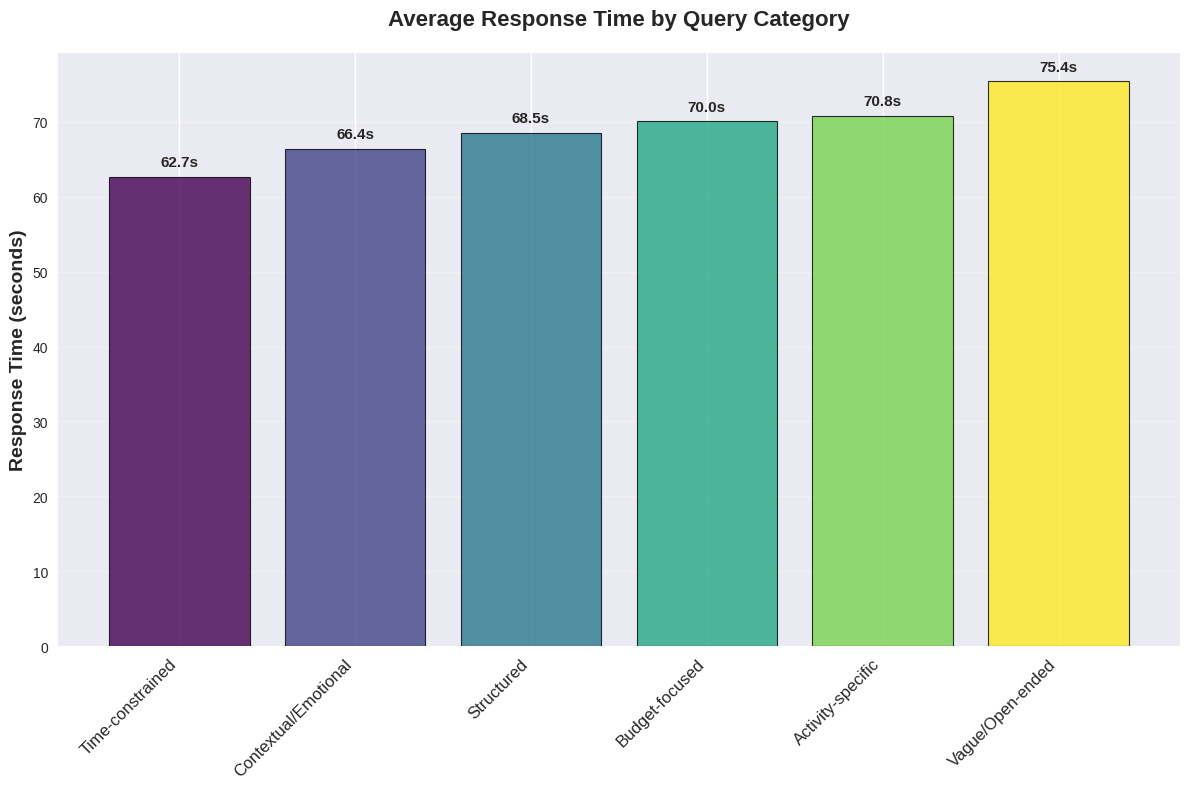

📊 Chart 1 saved as: chart_1_response_time_by_category.png


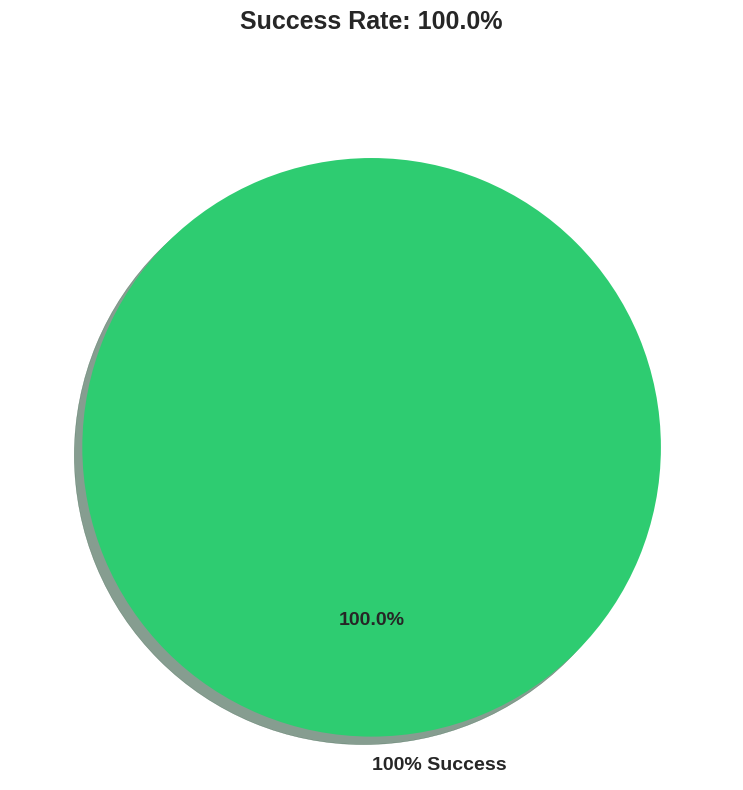

📊 Chart 2 saved as: chart_2_success_rate.png


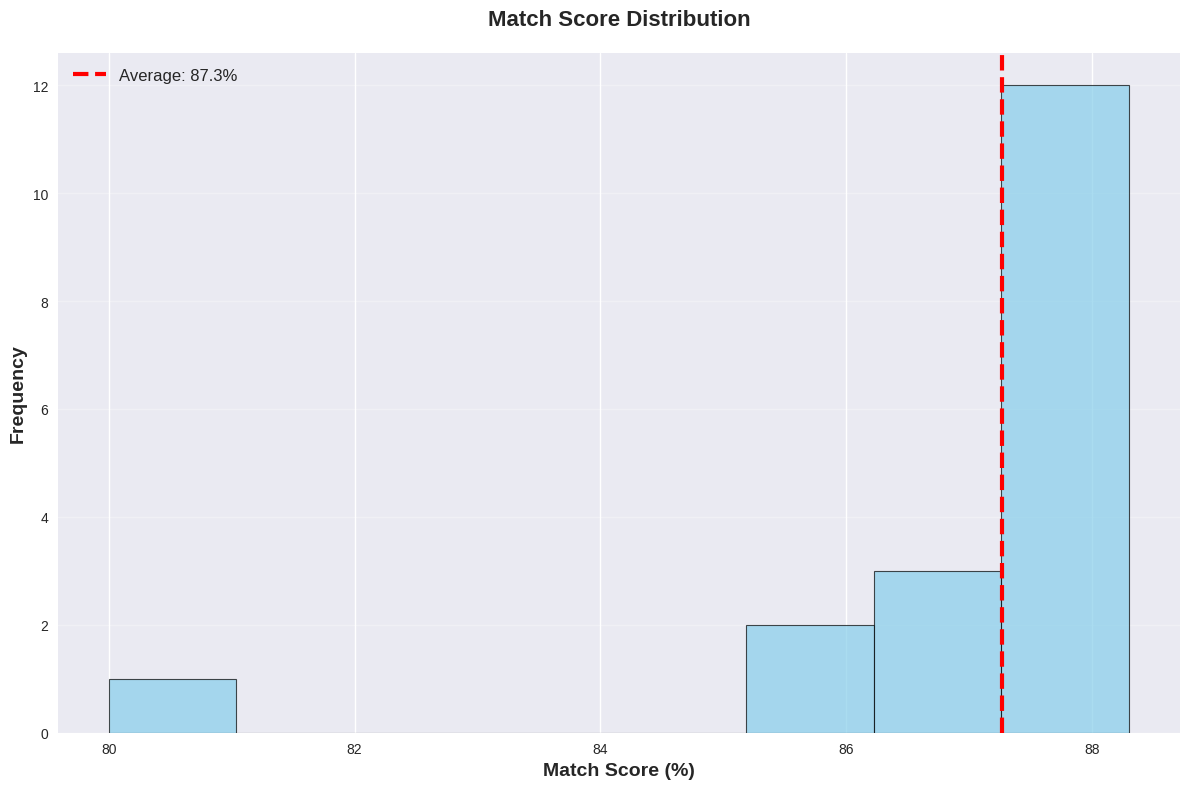

📊 Chart 3 saved as: chart_3_match_score_distribution.png


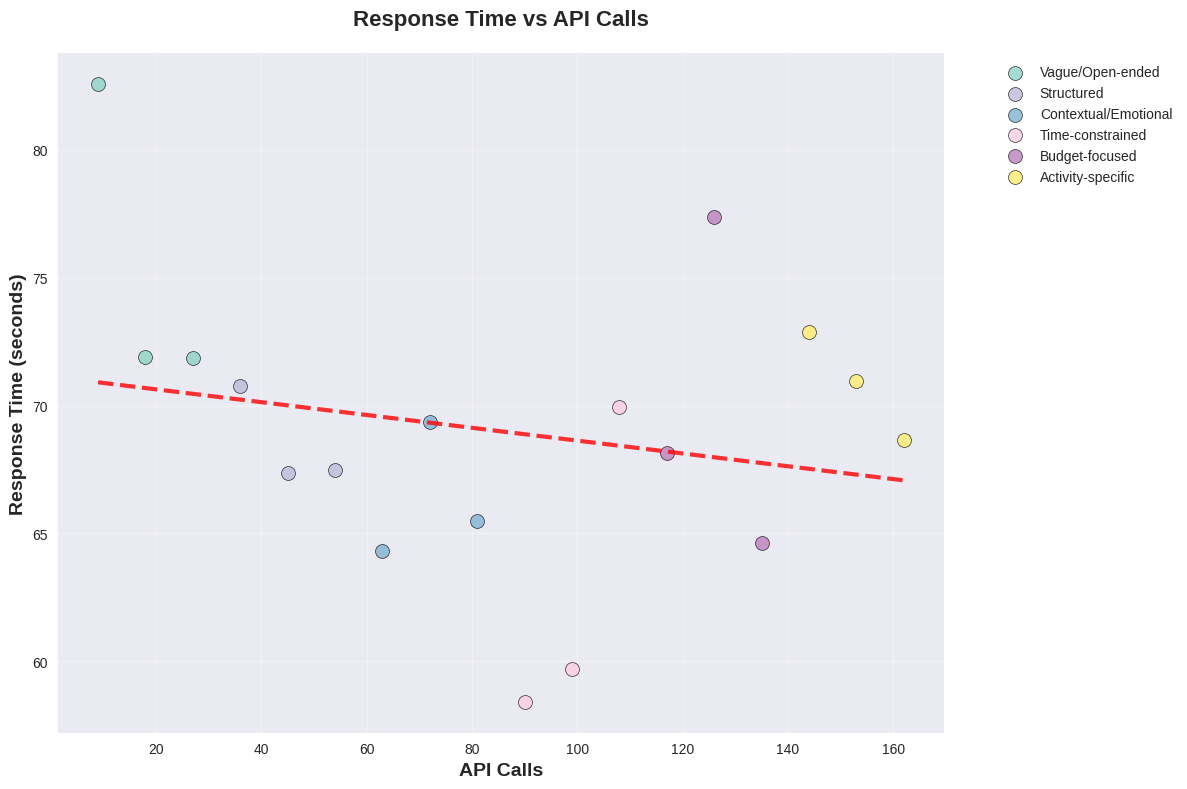

📊 Chart 4 saved as: chart_4_api_calls_vs_response_time.png


/tmp/ipython-input-681704411.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(diversity_data, labels=categories, patch_artist=True)


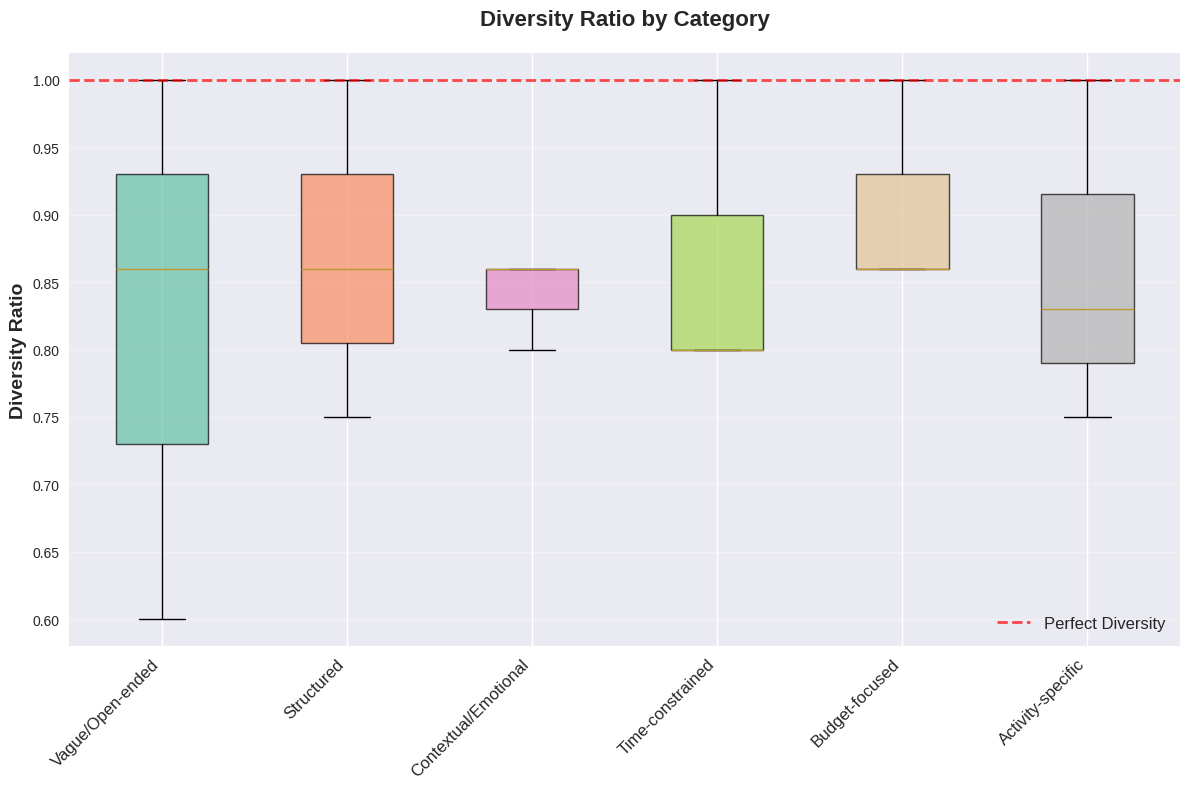

📊 Chart 5 saved as: chart_5_diversity_ratio_analysis.png


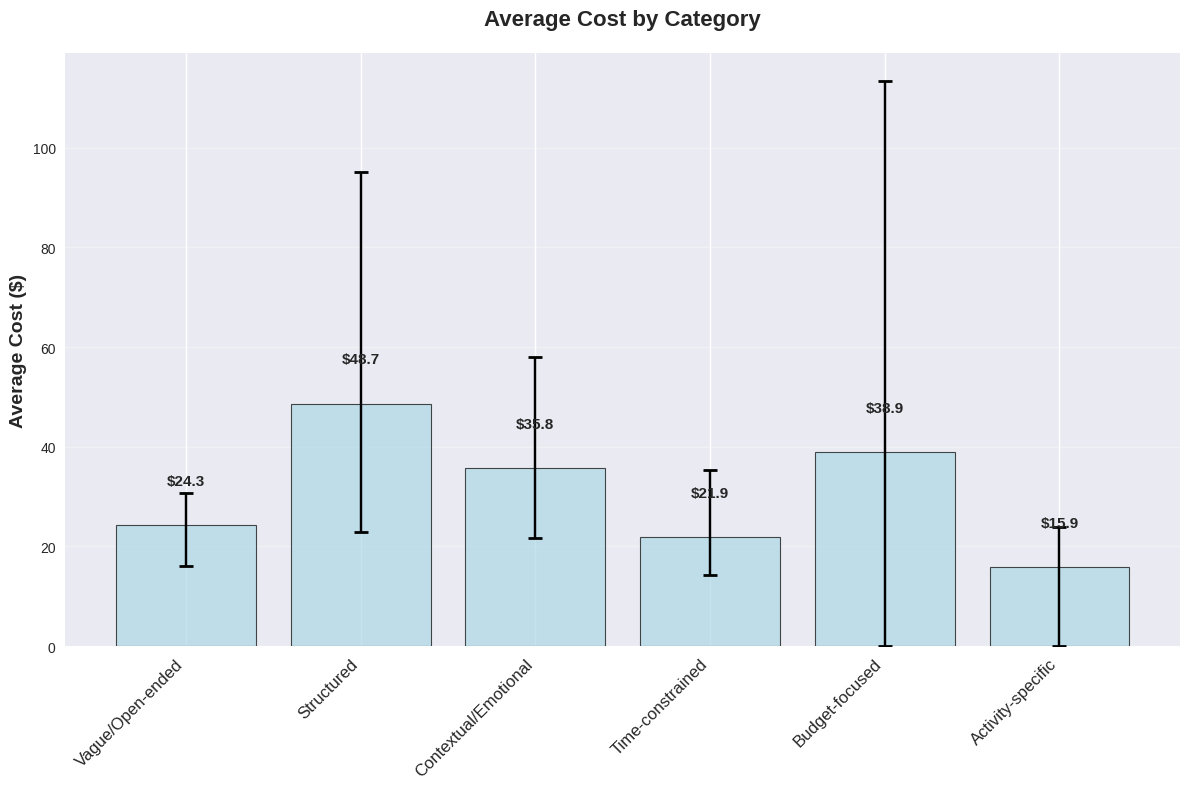

📊 Chart 6 saved as: chart_6_cost_analysis.png


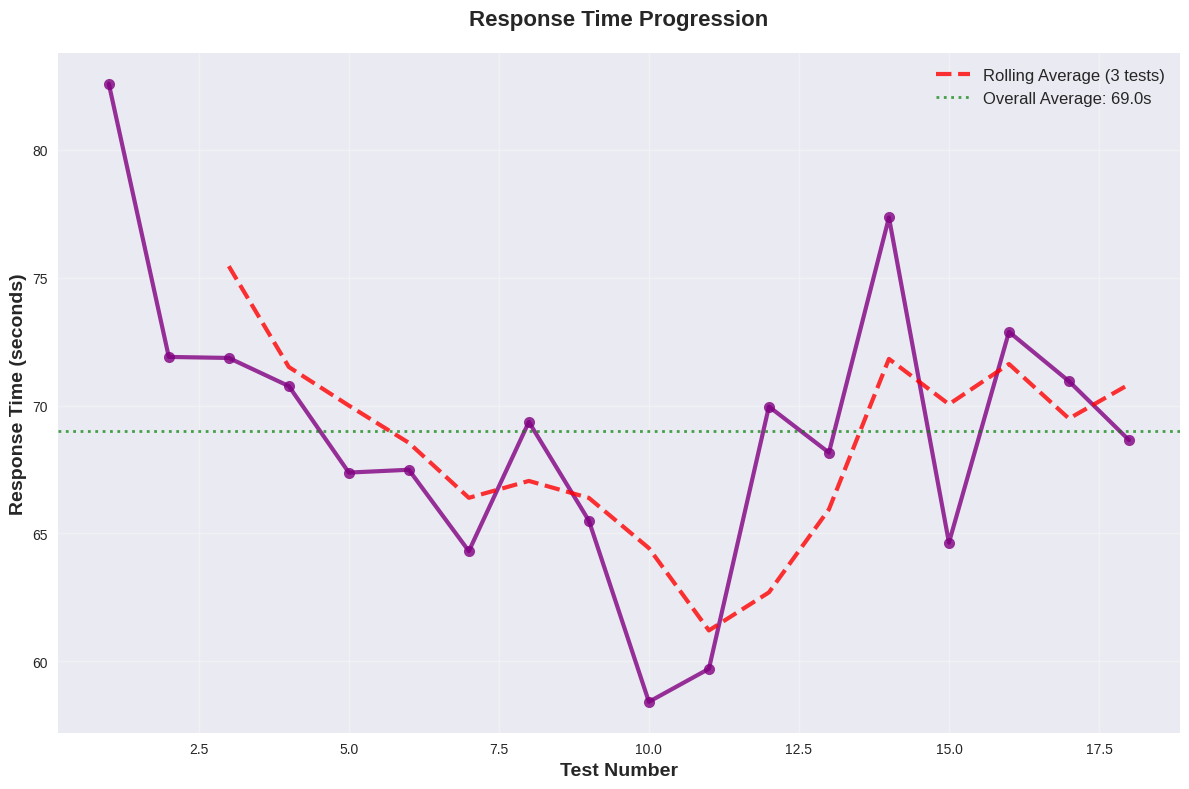

📊 Chart 7 saved as: chart_7_performance_over_time.png


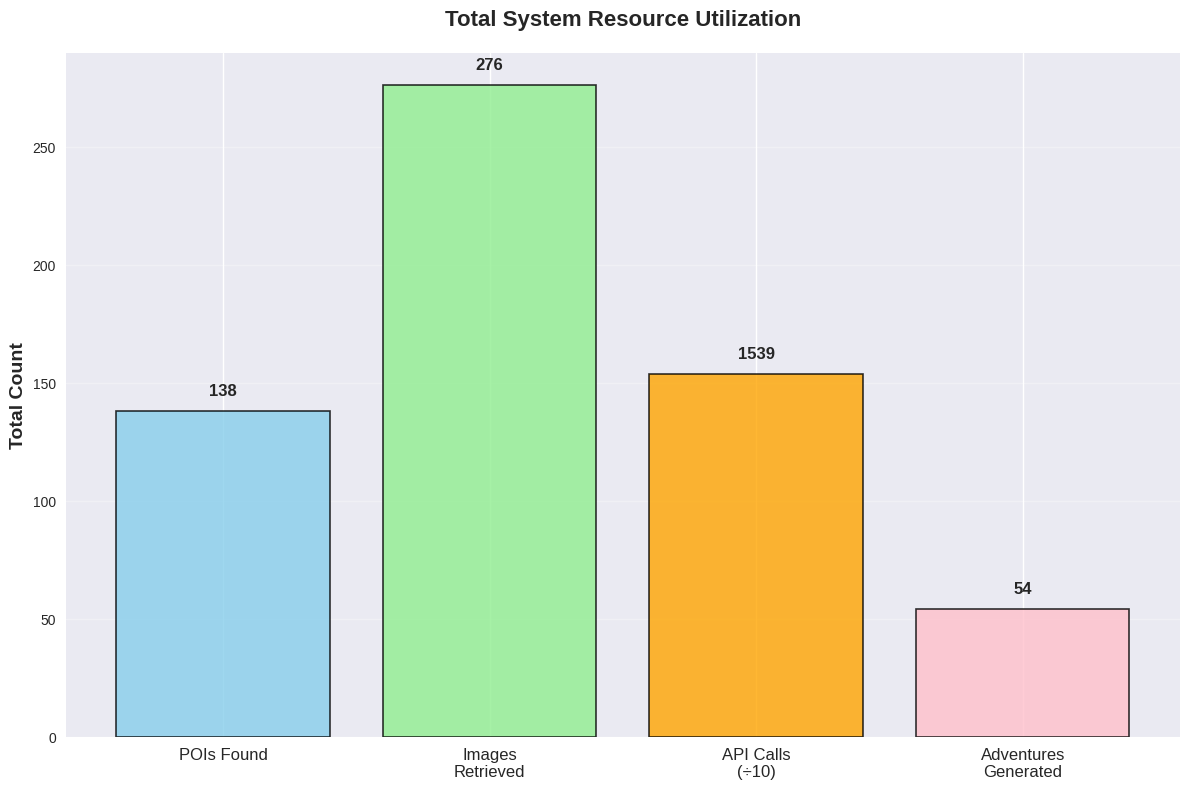

📊 Chart 8 saved as: chart_8_resource_utilization.png


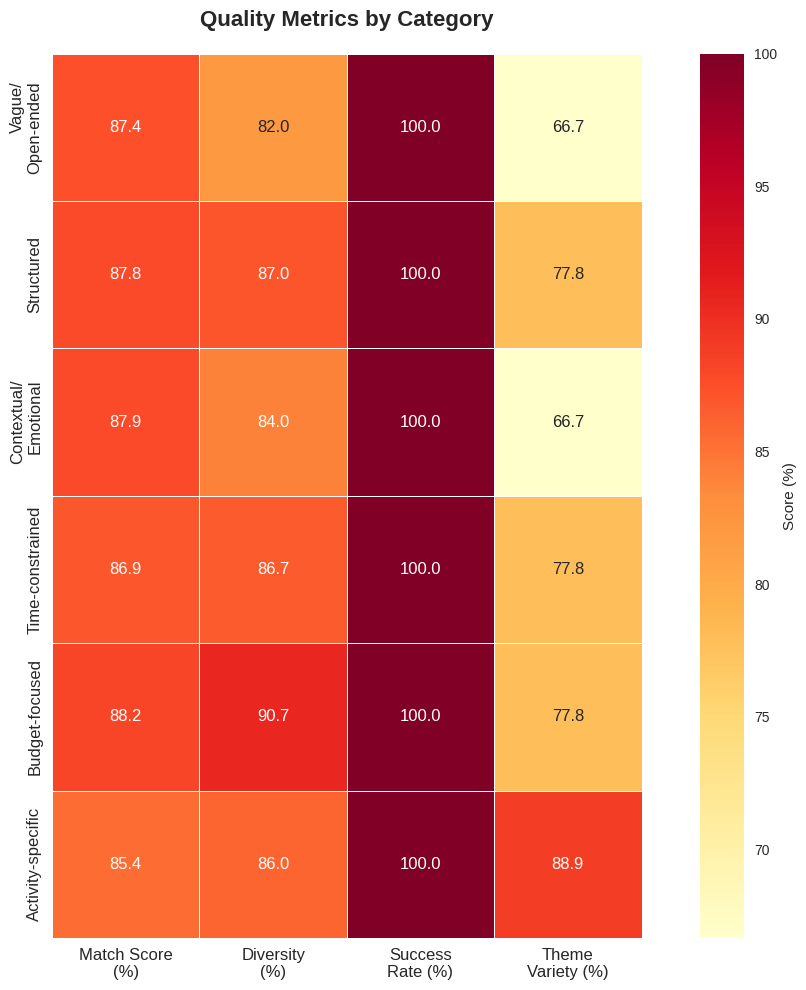

📊 Chart 9 saved as: chart_9_quality_metrics_heatmap.png

✅ ALL CHARTS GENERATED AND SAVED!
📁 Files saved:
   - chart_1_response_time_by_category.png
   - chart_2_success_rate.png
   - chart_3_match_score_distribution.png
   - chart_4_api_calls_vs_response_time.png
   - chart_5_diversity_ratio_analysis.png
   - chart_6_cost_analysis.png
   - chart_7_performance_over_time.png
   - chart_8_resource_utilization.png
   - chart_9_quality_metrics_heatmap.png

📊 All charts are high-resolution (300 DPI) and ready for your report!


In [ ]:
# Set style for professional-looking charts
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def save_chart_1_response_time_by_category(test_results_data):
    """Chart 1: Response Time by Category"""

    detailed_results = test_results_data['detailed_results']
    df = pd.DataFrame(detailed_results)

    plt.figure(figsize=(12, 8))

    # Calculate category averages
    category_times = df.groupby('category')['execution_time_seconds'].mean().sort_values()

    colors = plt.cm.viridis(np.linspace(0, 1, len(category_times)))
    bars = plt.bar(range(len(category_times)), category_times.values, color=colors,
                   alpha=0.8, edgecolor='black', linewidth=0.8)

    plt.title('Average Response Time by Query Category', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Response Time (seconds)', fontweight='bold', fontsize=14)
    plt.xticks(range(len(category_times)), category_times.index, rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (bar, time) in enumerate(zip(bars, category_times.values)):
        plt.text(i, bar.get_height() + 1, f'{time:.1f}s',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig('chart_1_response_time_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 1 saved as: chart_1_response_time_by_category.png")

def save_chart_2_success_rate(test_results_data):
    """Chart 2: Success Rate Visualization"""

    detailed_results = test_results_data['detailed_results']
    test_summary = test_results_data['test_summary']

    plt.figure(figsize=(10, 8))

    success_count = sum(1 for r in detailed_results if r['success'])
    total_count = len(detailed_results)
    failure_count = total_count - success_count

    if failure_count > 0:
        sizes = [success_count, failure_count]
        labels = [f'Successful ({success_count})', f'Failed ({failure_count})']
        colors_pie = ['#2ecc71', '#e74c3c']
        explode = (0.05, 0)
    else:
        sizes = [success_count]
        labels = ['100% Success']
        colors_pie = ['#2ecc71']
        explode = (0.1,)

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=colors_pie, explode=explode, shadow=True,
            textprops={'fontweight': 'bold', 'fontsize': 14})

    plt.title(f'Success Rate: {test_summary["success_rate"]}',
              fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('chart_2_success_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 2 saved as: chart_2_success_rate.png")

def save_chart_3_match_score_distribution(test_results_data):
    """Chart 3: Match Score Distribution"""

    detailed_results = test_results_data['detailed_results']

    plt.figure(figsize=(12, 8))

    match_scores = [r.get('average_match_score', 0) for r in detailed_results if r.get('average_match_score')]

    if match_scores:
        plt.hist(match_scores, bins=8, alpha=0.7, color='skyblue',
                edgecolor='black', linewidth=0.8)
        mean_score = np.mean(match_scores)
        plt.axvline(mean_score, color='red', linestyle='--', linewidth=3,
                   label=f'Average: {mean_score:.1f}%')

        plt.title('Match Score Distribution', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Match Score (%)', fontweight='bold', fontsize=14)
        plt.ylabel('Frequency', fontweight='bold', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('chart_3_match_score_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("📊 Chart 3 saved as: chart_3_match_score_distribution.png")

def save_chart_4_api_calls_vs_response_time(test_results_data):
    """Chart 4: API Calls vs Response Time"""

    detailed_results = test_results_data['detailed_results']
    df = pd.DataFrame(detailed_results)

    plt.figure(figsize=(12, 8))

    categories_unique = df['category'].unique()
    colors_scatter = plt.cm.Set3(np.linspace(0, 1, len(categories_unique)))

    for i, category in enumerate(categories_unique):
        cat_data = df[df['category'] == category]
        plt.scatter(cat_data['api_calls'], cat_data['execution_time_seconds'],
                   label=category, alpha=0.8, s=100, color=colors_scatter[i],
                   edgecolors='black', linewidth=0.5)

    # Add trend line
    all_api_calls = df['api_calls'].values
    all_times = df['execution_time_seconds'].values
    z = np.polyfit(all_api_calls, all_times, 1)
    p = np.poly1d(z)
    plt.plot(all_api_calls, p(all_api_calls), "r--", alpha=0.8, linewidth=3)

    plt.title('Response Time vs API Calls', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('API Calls', fontweight='bold', fontsize=14)
    plt.ylabel('Response Time (seconds)', fontweight='bold', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('chart_4_api_calls_vs_response_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 4 saved as: chart_4_api_calls_vs_response_time.png")

def save_chart_5_diversity_ratio_analysis(test_results_data):
    """Chart 5: Diversity Ratio Analysis"""

    detailed_results = test_results_data['detailed_results']

    plt.figure(figsize=(12, 8))

    category_diversity = defaultdict(list)
    for result in detailed_results:
        if result.get('diversity_ratio') is not None:
            category_diversity[result['category']].append(result['diversity_ratio'])

    categories = list(category_diversity.keys())
    diversity_data = [category_diversity[cat] for cat in categories]

    bp = plt.boxplot(diversity_data, labels=categories, patch_artist=True)

    colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.title('Diversity Ratio by Category', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Diversity Ratio', fontweight='bold', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add horizontal line at perfect diversity
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Perfect Diversity')
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('chart_5_diversity_ratio_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 5 saved as: chart_5_diversity_ratio_analysis.png")

def save_chart_6_cost_analysis(test_results_data):
    """Chart 6: Cost Analysis"""

    detailed_results = test_results_data['detailed_results']

    plt.figure(figsize=(12, 8))

    category_costs = defaultdict(list)
    for result in detailed_results:
        if result.get('average_cost') is not None:
            category_costs[result['category']].append(result['average_cost'])

    categories = list(category_costs.keys())
    cost_means = [np.mean(category_costs[cat]) for cat in categories]
    cost_mins = [np.min(category_costs[cat]) for cat in categories]
    cost_maxs = [np.max(category_costs[cat]) for cat in categories]

    x_pos = np.arange(len(categories))

    bars = plt.bar(x_pos, cost_means, alpha=0.7, color='lightblue',
                   edgecolor='black', linewidth=0.8)

    # Add error bars
    yerr_lower = [mean - min_val for mean, min_val in zip(cost_means, cost_mins)]
    yerr_upper = [max_val - mean for mean, max_val in zip(cost_means, cost_maxs)]
    plt.errorbar(x_pos, cost_means, yerr=[yerr_lower, yerr_upper],
                fmt='none', color='black', capsize=5, capthick=2)

    plt.title('Average Cost by Category', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Average Cost ($)', fontweight='bold', fontsize=14)
    plt.xticks(x_pos, categories, rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (bar, cost) in enumerate(zip(bars, cost_means)):
        plt.text(i, bar.get_height() + max(yerr_upper) * 0.1, f'${cost:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig('chart_6_cost_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 6 saved as: chart_6_cost_analysis.png")

def save_chart_7_performance_over_time(test_results_data):
    """Chart 7: Performance Over Time"""

    detailed_results = test_results_data['detailed_results']

    plt.figure(figsize=(12, 8))

    test_numbers = range(1, len(detailed_results) + 1)
    execution_times = [r['execution_time_seconds'] for r in detailed_results]

    plt.plot(test_numbers, execution_times, marker='o', linewidth=3,
             markersize=8, color='purple', alpha=0.8, markeredgecolor='black')

    # Add rolling average
    window_size = 3
    if len(execution_times) >= window_size:
        rolling_avg = pd.Series(execution_times).rolling(window=window_size).mean()
        plt.plot(test_numbers, rolling_avg, color='red', linestyle='--',
                linewidth=3, alpha=0.8, label=f'Rolling Average ({window_size} tests)')

    mean_time = np.mean(execution_times)
    plt.axhline(mean_time, color='green', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Overall Average: {mean_time:.1f}s')

    plt.title('Response Time Progression', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Test Number', fontweight='bold', fontsize=14)
    plt.ylabel('Response Time (seconds)', fontweight='bold', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('chart_7_performance_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 7 saved as: chart_7_performance_over_time.png")

def save_chart_8_resource_utilization(test_results_data):
    """Chart 8: System Resource Utilization"""

    detailed_results = test_results_data['detailed_results']

    plt.figure(figsize=(12, 8))

    total_pois = sum(r.get('total_pois_found', 0) for r in detailed_results)
    total_images = sum(r.get('total_images', 0) for r in detailed_results)
    total_api_calls = sum(r.get('api_calls', 0) for r in detailed_results)
    total_adventures = sum(r.get('adventures_generated', 0) for r in detailed_results)

    metrics = ['POIs Found', 'Images\nRetrieved', 'API Calls\n(÷10)', 'Adventures\nGenerated']
    values = [total_pois, total_images, total_api_calls/10, total_adventures]

    bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'orange', 'pink'],
                   alpha=0.8, edgecolor='black', linewidth=1.2)

    plt.title('Total System Resource Utilization', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Total Count', fontweight='bold', fontsize=14)
    plt.xticks(fontsize=12)

    # Add value labels
    actual_values = [total_pois, total_images, total_api_calls, total_adventures]
    for bar, value, actual in zip(bars, values, actual_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values) * 0.02,
                f'{int(actual)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('chart_8_resource_utilization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 8 saved as: chart_8_resource_utilization.png")

def save_chart_9_quality_metrics_heatmap(test_results_data):
    """Chart 9: Quality Metrics Heatmap"""

    detailed_results = test_results_data['detailed_results']
    df = pd.DataFrame(detailed_results)

    plt.figure(figsize=(12, 10))

    categories_unique = df['category'].unique()
    quality_metrics = []
    category_names = []

    for category in categories_unique:
        cat_data = df[df['category'] == category]
        avg_match_score = cat_data['average_match_score'].mean()
        avg_diversity = cat_data['diversity_ratio'].mean()
        success_rate = (cat_data['success'].sum() / len(cat_data)) * 100
        avg_themes = cat_data.get('unique_themes', pd.Series([2])).mean()

        quality_metrics.append([avg_match_score, avg_diversity * 100, success_rate, avg_themes * 33.33])
        category_names.append(category.replace('/', '/\n'))

    quality_df = pd.DataFrame(quality_metrics,
                             columns=['Match Score\n(%)', 'Diversity\n(%)', 'Success\nRate (%)', 'Theme\nVariety (%)'],
                             index=category_names)

    sns.heatmap(quality_df, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Score (%)'},
                fmt='.1f', linewidths=0.5, square=True, annot_kws={'fontsize': 12})

    plt.title('Quality Metrics by Category', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig('chart_9_quality_metrics_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Chart 9 saved as: chart_9_quality_metrics_heatmap.png")

def generate_all_individual_charts(test_results_data):
    """Generate all charts individually and save them"""

    print("🎯 GENERATING ALL INDIVIDUAL CHARTS FOR REPORT...")
    print("=" * 60)

    # Generate each chart
    save_chart_1_response_time_by_category(test_results_data)
    save_chart_2_success_rate(test_results_data)
    save_chart_3_match_score_distribution(test_results_data)
    save_chart_4_api_calls_vs_response_time(test_results_data)
    save_chart_5_diversity_ratio_analysis(test_results_data)
    save_chart_6_cost_analysis(test_results_data)
    save_chart_7_performance_over_time(test_results_data)
    save_chart_8_resource_utilization(test_results_data)
    save_chart_9_quality_metrics_heatmap(test_results_data)

    print("\n✅ ALL CHARTS GENERATED AND SAVED!")
    print("📁 Files saved:")
    print("   - chart_1_response_time_by_category.png")
    print("   - chart_2_success_rate.png")
    print("   - chart_3_match_score_distribution.png")
    print("   - chart_4_api_calls_vs_response_time.png")
    print("   - chart_5_diversity_ratio_analysis.png")
    print("   - chart_6_cost_analysis.png")
    print("   - chart_7_performance_over_time.png")
    print("   - chart_8_resource_utilization.png")
    print("   - chart_9_quality_metrics_heatmap.png")
    print("\n📊 All charts are high-resolution (300 DPI) and ready for your report!")

# Generate all charts if data is available
if 'miniquest_test_results' in globals():
    print("🎯 Found miniquest_test_results variable!")
    generate_all_individual_charts(miniquest_test_results)
else:
    print("❌ miniquest_test_results not found. Please run the test suite first.")
    print("\n🔧 To generate individual charts manually, use:")
    print("   save_chart_1_response_time_by_category(miniquest_test_results)")
    print("   save_chart_2_success_rate(miniquest_test_results)")
    print("   # ... and so on for each chart")